##### Copyright 2019 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS, 
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Bangla Article Classification With TF-Hub

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/bangla_article_classifier"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/bangla_article_classifier.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/hub/blob/master/examples/colab/bangla_article_classifier.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/hub/examples/colab/bangla_article_classifier.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Caution: In addition to installing Python packages with pip, this notebook uses
`sudo apt install` to install system packages: `unzip`.

This Colab is a demonstration of using [Tensorflow Hub](https://www.tensorflow.org/hub/) for text classification in non-English/local languages. Here we choose [Bangla](https://en.wikipedia.org/wiki/Bengali_language) as the local language and use pretrained word embeddings to solve a multiclass classification task where we classify Bangla news articles in 5 categories.  The pretrained embeddings for Bangla comes from [fastText](https://fasttext.cc/docs/en/crawl-vectors.html) which is a library by Facebook with released pretrained word vectors for 157 languages. 

We'll use TF-Hub's pretrained embedding exporter for converting the word embeddings to a text embedding module first and then use the module to train a classifier with [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras), Tensorflow's high level user friendly API to build deep learning models.  Even if we are using fastText embeddings here, it's possible to export any other embeddings pretrained from other tasks and quickly get results with Tensorflow hub. 

## Setup

In [2]:
%%bash
# https://github.com/pypa/setuptools/issues/1694#issuecomment-466010982
pip install gdown --no-use-pep517

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for gdown: filename=gdown-4.4.0-py3-none-any.whl size=14775 sha256=3d4f951d12014360d531608d86b98a50da800182356e120ea87989bc6036c344
  Stored in directory: /home/kbuilder/.cache/pip/wheels/fb/c3/0e/c4d8ff8bfcb0461afff199471449f642179b74968c15b7a69c
Successfully built gdown


In [3]:
%%bash
sudo apt-get install -y unzip

Reading package lists...
Building dependency tree...
Reading state information...
unzip is already the newest version (6.0-25ubuntu1).
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2 libnuma1
  libparted-fs-resize0
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 95 not upgraded.


In [4]:
import os

import tensorflow as tf
import tensorflow_hub as hub

import gdown
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset

We will use [BARD](https://www.researchgate.net/publication/328214545_BARD_Bangla_Article_Classification_Using_a_New_Comprehensive_Dataset) (Bangla Article Dataset) which has around 376,226 articles collected from different Bangla news portals and labelled with 5 categories: economy, state, international, sports, and entertainment. We download the file from Google Drive this ([bit.ly/BARD_DATASET](bit.ly/BARD_DATASET)) link is referring to from [this](https://github.com/tanvirfahim15/BARD-Bangla-Article-Classifier) GitHub repository.


In [5]:
gdown.download(
    url='https://drive.google.com/uc?id=1Ag0jd21oRwJhVFIBohmX_ogeojVtapLy',
    output='bard.zip',
    quiet=True
)

'bard.zip'

In [6]:
%%bash
unzip -qo bard.zip

# Export pretrained word vectors to TF-Hub module

TF-Hub provides some useful scripts for converting word embeddings to TF-hub text embedding modules [here](https://github.com/tensorflow/hub/tree/master/examples/text_embeddings_v2). To make the module for Bangla or any other languages, we simply have to download the word embedding `.txt` or `.vec` file to the same directory as `export_v2.py` and run the script.


The exporter reads the embedding vectors and exports it to a Tensorflow [SavedModel](https://www.tensorflow.org/beta/guide/saved_model). A SavedModel contains a complete TensorFlow program including weights and graph. TF-Hub can load the SavedModel as a [module](https://www.tensorflow.org/hub/api_docs/python/hub/Module), which we will use to build the model for text classification. Since we are using `tf.keras` to build the model, we will use [hub.KerasLayer](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer), which provides a wrapper for a TF-Hub module to use as a Keras Layer.

First we will get our word embeddings from fastText and embedding exporter from TF-Hub [repo](https://github.com/tensorflow/hub).


In [7]:
%%bash
curl -O https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.bn.300.vec.gz
curl -O https://raw.githubusercontent.com/tensorflow/hub/master/examples/text_embeddings_v2/export_v2.py
gunzip -qf cc.bn.300.vec.gz --k

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  840M  100  840M    0     0  43.0M      0  0:00:19  0:00:19 --:--:-- 40.8M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7469  100  7469    0     0  54919      0 --:--:-- --:--:-- --:--:-- 54919


Then, we will run the exporter script on our embedding file. Since fastText embeddings have a header line and are pretty large (around 3.3 GB for Bangla after converting to a module) we ignore the first line and export only the first 100, 000 tokens to the text embedding module.

In [8]:
%%bash
python export_v2.py --embedding_file=cc.bn.300.vec --export_path=text_module --num_lines_to_ignore=1 --num_lines_to_use=100000

INFO:tensorflow:Assets written to: text_module/assets
I0427 11:45:16.843295 139947948320576 builder_impl.py:780] Assets written to: text_module/assets


In [9]:
module_path = "text_module"
embedding_layer = hub.KerasLayer(module_path, trainable=False)

The text embedding module takes a batch of sentences in a 1D tensor of strings as input and outputs the embedding vectors of shape (batch_size, embedding_dim) corresponding to the sentences. It preprocesses the input by splitting on spaces. Word embeddings are combined to sentence embeddings with the `sqrtn` combiner(See [here](https://www.tensorflow.org/api_docs/python/tf/nn/embedding_lookup_sparse)). For demonstration we pass a list of Bangla words as input and get the corresponding embedding vectors.

In [10]:
embedding_layer(['বাস', 'বসবাস', 'ট্রেন', 'যাত্রী', 'ট্রাক']) 

<tf.Tensor: shape=(5, 300), dtype=float64, numpy=
array([[ 0.0462, -0.0355,  0.0129, ...,  0.0025, -0.0966,  0.0216],
       [-0.0631, -0.0051,  0.085 , ...,  0.0249, -0.0149,  0.0203],
       [ 0.1371, -0.069 , -0.1176, ...,  0.029 ,  0.0508, -0.026 ],
       [ 0.0532, -0.0465, -0.0504, ...,  0.02  , -0.0023,  0.0011],
       [ 0.0908, -0.0404, -0.0536, ..., -0.0275,  0.0528,  0.0253]])>

# Convert to Tensorflow Dataset 


Since the dataset is really large instead of loading the entire dataset in memory we will use a generator to yield samples in run-time in batches using [Tensorflow Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) functions. The dataset is also very imbalanced, so, before using the generator, we will shuffle the dataset. 


In [11]:
dir_names = ['economy', 'sports', 'entertainment', 'state', 'international']

file_paths = []
labels = []
for i, dir in enumerate(dir_names):
  file_names = ["/".join([dir, name]) for name in os.listdir(dir)]
  file_paths += file_names
  labels += [i] * len(os.listdir(dir))
  
np.random.seed(42)
permutation = np.random.permutation(len(file_paths))

file_paths = np.array(file_paths)[permutation]
labels = np.array(labels)[permutation]

We can check the distribution of labels in the training and validation examples after shuffling.

In [12]:
train_frac = 0.8
train_size = int(len(file_paths) * train_frac)

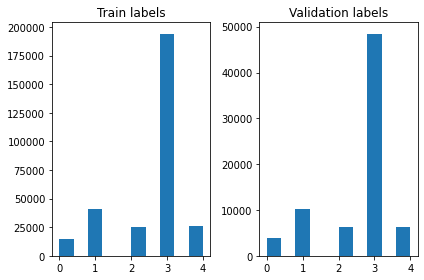

In [13]:
# plot training vs validation distribution
plt.subplot(1, 2, 1)
plt.hist(labels[0:train_size])
plt.title("Train labels")
plt.subplot(1, 2, 2)
plt.hist(labels[train_size:])
plt.title("Validation labels")
plt.tight_layout()

To create a [Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) using a generator, we first write a generator function which reads each of the articles from `file_paths` and the labels from the label array, and yields one training example at each step. We pass this generator function to the [`tf.data.Dataset.from_generator`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_generator) method and specify the output types. Each training example is a tuple containing an article of `tf.string` data type and one-hot encoded label. We split the dataset with a train-validation split of 80-20 using [`tf.data.Dataset.skip`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#skip) and [`tf.data.Dataset.take`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take) methods.

In [14]:
def load_file(path, label):
    return tf.io.read_file(path), label

In [15]:
def make_datasets(train_size):
  batch_size = 256

  train_files = file_paths[:train_size]
  train_labels = labels[:train_size]
  train_ds = tf.data.Dataset.from_tensor_slices((train_files, train_labels))
  train_ds = train_ds.map(load_file).shuffle(5000)
  train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

  test_files = file_paths[train_size:]
  test_labels = labels[train_size:]
  test_ds = tf.data.Dataset.from_tensor_slices((test_files, test_labels))
  test_ds = test_ds.map(load_file)
  test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


  return train_ds, test_ds

In [16]:
train_data, validation_data = make_datasets(train_size)

# Model Training and Evaluation

Since we have already added a wrapper around our module to use it as any other layer in Keras, we can create a small [Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) model which is a linear stack of layers. We can add our text embedding module with `model.add` just like any other layer. We compile the model by specifying the loss and optimizer and train it for 10 epochs. The `tf.keras` API can handle Tensorflow Datasets as input, so we can pass a Dataset instance to the fit method for model training. Since we are using the generator function, `tf.data` will handle generating the samples, batching them and feeding them to the model.

## Model

In [17]:
def create_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[], dtype=tf.string),
    embedding_layer,
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(5),
  ])
  model.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
      optimizer="adam", metrics=['accuracy'])
  return model

In [18]:
model = create_model()
# Create earlystopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3)

## Training

In [19]:

history = model.fit(train_data, 
                    validation_data=validation_data, 
                    epochs=5, 
                    callbacks=[early_stopping_callback])

Epoch 1/5


   1/1176 [..............................] - ETA: 15:44 - loss: 1.6081 - accuracy: 0.1211

   4/1176 [..............................] - ETA: 25s - loss: 1.5380 - accuracy: 0.4541  

   7/1176 [..............................] - ETA: 24s - loss: 1.4870 - accuracy: 0.5340

  10/1176 [..............................] - ETA: 23s - loss: 1.4355 - accuracy: 0.5758

  13/1176 [..............................] - ETA: 23s - loss: 1.3842 - accuracy: 0.5928

  16/1176 [..............................] - ETA: 23s - loss: 1.3446 - accuracy: 0.5981

  19/1176 [..............................] - ETA: 23s - loss: 1.3032 - accuracy: 0.6061

  22/1176 [..............................] - ETA: 23s - loss: 1.2705 - accuracy: 0.6106

  25/1176 [..............................] - ETA: 22s - loss: 1.2419 - accuracy: 0.6141

  28/1176 [..............................] - ETA: 22s - loss: 1.2179 - accuracy: 0.6218

  31/1176 [..............................] - ETA: 22s - loss: 1.1874 - accuracy: 0.6343

  34/1176 [..............................] - ETA: 22s - loss: 1.1582 - accuracy: 0.6473

  37/1176 [..............................] - ETA: 22s - loss: 1.1272 - accuracy: 0.6579

  40/1176 [>.............................] - ETA: 22s - loss: 1.1064 - accuracy: 0.6625

  43/1176 [>.............................] - ETA: 22s - loss: 1.0853 - accuracy: 0.6684

  46/1176 [>.............................] - ETA: 22s - loss: 1.0622 - accuracy: 0.6754

  49/1176 [>.............................] - ETA: 22s - loss: 1.0418 - accuracy: 0.6811

  52/1176 [>.............................] - ETA: 22s - loss: 1.0215 - accuracy: 0.6861

  55/1176 [>.............................] - ETA: 22s - loss: 1.0024 - accuracy: 0.6906

  58/1176 [>.............................] - ETA: 21s - loss: 0.9830 - accuracy: 0.6948

  61/1176 [>.............................] - ETA: 21s - loss: 0.9656 - accuracy: 0.6993

  64/1176 [>.............................] - ETA: 21s - loss: 0.9491 - accuracy: 0.7036

  67/1176 [>.............................] - ETA: 21s - loss: 0.9333 - accuracy: 0.7071

  70/1176 [>.............................] - ETA: 21s - loss: 0.9180 - accuracy: 0.7105

  73/1176 [>.............................] - ETA: 21s - loss: 0.9021 - accuracy: 0.7145

  76/1176 [>.............................] - ETA: 21s - loss: 0.8875 - accuracy: 0.7190

  79/1176 [=>............................] - ETA: 21s - loss: 0.8721 - accuracy: 0.7244

  82/1176 [=>............................] - ETA: 21s - loss: 0.8579 - accuracy: 0.7291

  85/1176 [=>............................] - ETA: 21s - loss: 0.8448 - accuracy: 0.7331

  88/1176 [=>............................] - ETA: 21s - loss: 0.8308 - accuracy: 0.7376

  91/1176 [=>............................] - ETA: 21s - loss: 0.8182 - accuracy: 0.7421

  94/1176 [=>............................] - ETA: 21s - loss: 0.8055 - accuracy: 0.7464

  97/1176 [=>............................] - ETA: 21s - loss: 0.7946 - accuracy: 0.7495

 100/1176 [=>............................] - ETA: 21s - loss: 0.7827 - accuracy: 0.7533

 103/1176 [=>............................] - ETA: 20s - loss: 0.7707 - accuracy: 0.7571

 106/1176 [=>............................] - ETA: 20s - loss: 0.7600 - accuracy: 0.7605

 109/1176 [=>............................] - ETA: 20s - loss: 0.7485 - accuracy: 0.7639

 112/1176 [=>............................] - ETA: 20s - loss: 0.7376 - accuracy: 0.7676

 115/1176 [=>............................] - ETA: 20s - loss: 0.7262 - accuracy: 0.7713

 118/1176 [==>...........................] - ETA: 20s - loss: 0.7161 - accuracy: 0.7745

 121/1176 [==>...........................] - ETA: 20s - loss: 0.7075 - accuracy: 0.7773

 124/1176 [==>...........................] - ETA: 20s - loss: 0.6981 - accuracy: 0.7804

 127/1176 [==>...........................] - ETA: 20s - loss: 0.6899 - accuracy: 0.7826

 130/1176 [==>...........................] - ETA: 20s - loss: 0.6815 - accuracy: 0.7849

 133/1176 [==>...........................] - ETA: 20s - loss: 0.6730 - accuracy: 0.7872

 136/1176 [==>...........................] - ETA: 20s - loss: 0.6647 - accuracy: 0.7898

 139/1176 [==>...........................] - ETA: 20s - loss: 0.6563 - accuracy: 0.7926

 142/1176 [==>...........................] - ETA: 20s - loss: 0.6484 - accuracy: 0.7950

 145/1176 [==>...........................] - ETA: 20s - loss: 0.6411 - accuracy: 0.7973

 148/1176 [==>...........................] - ETA: 19s - loss: 0.6337 - accuracy: 0.7997

 151/1176 [==>...........................] - ETA: 19s - loss: 0.6263 - accuracy: 0.8021

 154/1176 [==>...........................] - ETA: 19s - loss: 0.6190 - accuracy: 0.8045

 157/1176 [===>..........................] - ETA: 19s - loss: 0.6116 - accuracy: 0.8068

 160/1176 [===>..........................] - ETA: 19s - loss: 0.6055 - accuracy: 0.8086

 163/1176 [===>..........................] - ETA: 19s - loss: 0.5991 - accuracy: 0.8105

 166/1176 [===>..........................] - ETA: 19s - loss: 0.5930 - accuracy: 0.8124

 169/1176 [===>..........................] - ETA: 19s - loss: 0.5870 - accuracy: 0.8142

 172/1176 [===>..........................] - ETA: 19s - loss: 0.5808 - accuracy: 0.8161

 175/1176 [===>..........................] - ETA: 19s - loss: 0.5754 - accuracy: 0.8178

 178/1176 [===>..........................] - ETA: 19s - loss: 0.5700 - accuracy: 0.8195

 181/1176 [===>..........................] - ETA: 19s - loss: 0.5643 - accuracy: 0.8214

 184/1176 [===>..........................] - ETA: 19s - loss: 0.5595 - accuracy: 0.8228

 187/1176 [===>..........................] - ETA: 19s - loss: 0.5547 - accuracy: 0.8242

 190/1176 [===>..........................] - ETA: 19s - loss: 0.5495 - accuracy: 0.8257

 193/1176 [===>..........................] - ETA: 19s - loss: 0.5449 - accuracy: 0.8273

 196/1176 [====>.........................] - ETA: 18s - loss: 0.5407 - accuracy: 0.8285

 199/1176 [====>.........................] - ETA: 18s - loss: 0.5361 - accuracy: 0.8300

 202/1176 [====>.........................] - ETA: 18s - loss: 0.5317 - accuracy: 0.8314

 205/1176 [====>.........................] - ETA: 18s - loss: 0.5273 - accuracy: 0.8326

 208/1176 [====>.........................] - ETA: 18s - loss: 0.5225 - accuracy: 0.8342

 211/1176 [====>.........................] - ETA: 18s - loss: 0.5185 - accuracy: 0.8354

 214/1176 [====>.........................] - ETA: 18s - loss: 0.5142 - accuracy: 0.8368

 217/1176 [====>.........................] - ETA: 18s - loss: 0.5100 - accuracy: 0.8380

 220/1176 [====>.........................] - ETA: 18s - loss: 0.5058 - accuracy: 0.8393

 223/1176 [====>.........................] - ETA: 18s - loss: 0.5021 - accuracy: 0.8404

 226/1176 [====>.........................] - ETA: 18s - loss: 0.4986 - accuracy: 0.8415

 229/1176 [====>.........................] - ETA: 18s - loss: 0.4949 - accuracy: 0.8426

 232/1176 [====>.........................] - ETA: 18s - loss: 0.4912 - accuracy: 0.8436

 235/1176 [====>.........................] - ETA: 18s - loss: 0.4879 - accuracy: 0.8446

 238/1176 [=====>........................] - ETA: 18s - loss: 0.4846 - accuracy: 0.8454

 241/1176 [=====>........................] - ETA: 18s - loss: 0.4815 - accuracy: 0.8463

 244/1176 [=====>........................] - ETA: 17s - loss: 0.4786 - accuracy: 0.8473

 247/1176 [=====>........................] - ETA: 17s - loss: 0.4756 - accuracy: 0.8483

 250/1176 [=====>........................] - ETA: 17s - loss: 0.4727 - accuracy: 0.8490

 253/1176 [=====>........................] - ETA: 17s - loss: 0.4695 - accuracy: 0.8501

 255/1176 [=====>........................] - ETA: 17s - loss: 0.4679 - accuracy: 0.8505

 258/1176 [=====>........................] - ETA: 17s - loss: 0.4648 - accuracy: 0.8515

 261/1176 [=====>........................] - ETA: 17s - loss: 0.4624 - accuracy: 0.8523

 264/1176 [=====>........................] - ETA: 17s - loss: 0.4598 - accuracy: 0.8530

 267/1176 [=====>........................] - ETA: 17s - loss: 0.4570 - accuracy: 0.8538

 270/1176 [=====>........................] - ETA: 17s - loss: 0.4541 - accuracy: 0.8547

 273/1176 [=====>........................] - ETA: 17s - loss: 0.4516 - accuracy: 0.8555

 276/1176 [======>.......................] - ETA: 17s - loss: 0.4489 - accuracy: 0.8564

 279/1176 [======>.......................] - ETA: 17s - loss: 0.4461 - accuracy: 0.8573

 282/1176 [======>.......................] - ETA: 17s - loss: 0.4435 - accuracy: 0.8580

 285/1176 [======>.......................] - ETA: 17s - loss: 0.4410 - accuracy: 0.8587

 288/1176 [======>.......................] - ETA: 17s - loss: 0.4383 - accuracy: 0.8595

 291/1176 [======>.......................] - ETA: 17s - loss: 0.4360 - accuracy: 0.8602

 294/1176 [======>.......................] - ETA: 17s - loss: 0.4339 - accuracy: 0.8608

 297/1176 [======>.......................] - ETA: 16s - loss: 0.4316 - accuracy: 0.8615

 300/1176 [======>.......................] - ETA: 16s - loss: 0.4299 - accuracy: 0.8621

 303/1176 [======>.......................] - ETA: 16s - loss: 0.4278 - accuracy: 0.8628

 306/1176 [======>.......................] - ETA: 16s - loss: 0.4258 - accuracy: 0.8633

 309/1176 [======>.......................] - ETA: 16s - loss: 0.4236 - accuracy: 0.8639

 312/1176 [======>.......................] - ETA: 16s - loss: 0.4214 - accuracy: 0.8645

 315/1176 [=======>......................] - ETA: 16s - loss: 0.4192 - accuracy: 0.8653

 318/1176 [=======>......................] - ETA: 16s - loss: 0.4173 - accuracy: 0.8659

 321/1176 [=======>......................] - ETA: 16s - loss: 0.4158 - accuracy: 0.8662

 324/1176 [=======>......................] - ETA: 16s - loss: 0.4141 - accuracy: 0.8667

 327/1176 [=======>......................] - ETA: 16s - loss: 0.4119 - accuracy: 0.8674

 330/1176 [=======>......................] - ETA: 16s - loss: 0.4100 - accuracy: 0.8679

 333/1176 [=======>......................] - ETA: 16s - loss: 0.4081 - accuracy: 0.8685

 336/1176 [=======>......................] - ETA: 16s - loss: 0.4062 - accuracy: 0.8691

 339/1176 [=======>......................] - ETA: 16s - loss: 0.4045 - accuracy: 0.8697

 342/1176 [=======>......................] - ETA: 16s - loss: 0.4027 - accuracy: 0.8702

 345/1176 [=======>......................] - ETA: 16s - loss: 0.4009 - accuracy: 0.8708

 348/1176 [=======>......................] - ETA: 16s - loss: 0.3990 - accuracy: 0.8714

 351/1176 [=======>......................] - ETA: 15s - loss: 0.3972 - accuracy: 0.8719

 354/1176 [========>.....................] - ETA: 15s - loss: 0.3957 - accuracy: 0.8724

 357/1176 [========>.....................] - ETA: 15s - loss: 0.3940 - accuracy: 0.8728

 360/1176 [========>.....................] - ETA: 15s - loss: 0.3923 - accuracy: 0.8733

 363/1176 [========>.....................] - ETA: 15s - loss: 0.3905 - accuracy: 0.8739

 366/1176 [========>.....................] - ETA: 15s - loss: 0.3888 - accuracy: 0.8745

 369/1176 [========>.....................] - ETA: 15s - loss: 0.3871 - accuracy: 0.8751

 372/1176 [========>.....................] - ETA: 15s - loss: 0.3855 - accuracy: 0.8756

 375/1176 [========>.....................] - ETA: 15s - loss: 0.3842 - accuracy: 0.8761

 378/1176 [========>.....................] - ETA: 15s - loss: 0.3825 - accuracy: 0.8766

 381/1176 [========>.....................] - ETA: 15s - loss: 0.3809 - accuracy: 0.8770

 384/1176 [========>.....................] - ETA: 15s - loss: 0.3794 - accuracy: 0.8774

 387/1176 [========>.....................] - ETA: 15s - loss: 0.3778 - accuracy: 0.8780

 390/1176 [========>.....................] - ETA: 15s - loss: 0.3763 - accuracy: 0.8785

 393/1176 [=========>....................] - ETA: 15s - loss: 0.3751 - accuracy: 0.8788

 396/1176 [=========>....................] - ETA: 15s - loss: 0.3736 - accuracy: 0.8793

 399/1176 [=========>....................] - ETA: 15s - loss: 0.3721 - accuracy: 0.8797

 402/1176 [=========>....................] - ETA: 15s - loss: 0.3707 - accuracy: 0.8801

 405/1176 [=========>....................] - ETA: 14s - loss: 0.3695 - accuracy: 0.8805

 408/1176 [=========>....................] - ETA: 14s - loss: 0.3683 - accuracy: 0.8809

 411/1176 [=========>....................] - ETA: 14s - loss: 0.3674 - accuracy: 0.8811

 414/1176 [=========>....................] - ETA: 14s - loss: 0.3661 - accuracy: 0.8815

 417/1176 [=========>....................] - ETA: 14s - loss: 0.3651 - accuracy: 0.8819

 420/1176 [=========>....................] - ETA: 14s - loss: 0.3635 - accuracy: 0.8824

 423/1176 [=========>....................] - ETA: 14s - loss: 0.3622 - accuracy: 0.8827

 426/1176 [=========>....................] - ETA: 14s - loss: 0.3608 - accuracy: 0.8832

 429/1176 [=========>....................] - ETA: 14s - loss: 0.3597 - accuracy: 0.8836

 432/1176 [==========>...................] - ETA: 14s - loss: 0.3585 - accuracy: 0.8840

 435/1176 [==========>...................] - ETA: 14s - loss: 0.3573 - accuracy: 0.8843

 438/1176 [==========>...................] - ETA: 14s - loss: 0.3563 - accuracy: 0.8846

 441/1176 [==========>...................] - ETA: 14s - loss: 0.3550 - accuracy: 0.8851

 444/1176 [==========>...................] - ETA: 14s - loss: 0.3537 - accuracy: 0.8854

 447/1176 [==========>...................] - ETA: 14s - loss: 0.3526 - accuracy: 0.8857

 450/1176 [==========>...................] - ETA: 14s - loss: 0.3513 - accuracy: 0.8861

 453/1176 [==========>...................] - ETA: 14s - loss: 0.3503 - accuracy: 0.8864

 456/1176 [==========>...................] - ETA: 13s - loss: 0.3492 - accuracy: 0.8868

 459/1176 [==========>...................] - ETA: 13s - loss: 0.3480 - accuracy: 0.8871

 462/1176 [==========>...................] - ETA: 13s - loss: 0.3469 - accuracy: 0.8875

 465/1176 [==========>...................] - ETA: 13s - loss: 0.3457 - accuracy: 0.8879

 468/1176 [==========>...................] - ETA: 13s - loss: 0.3447 - accuracy: 0.8882

 471/1176 [===========>..................] - ETA: 13s - loss: 0.3437 - accuracy: 0.8885

 474/1176 [===========>..................] - ETA: 13s - loss: 0.3425 - accuracy: 0.8889

 477/1176 [===========>..................] - ETA: 13s - loss: 0.3415 - accuracy: 0.8892

 480/1176 [===========>..................] - ETA: 13s - loss: 0.3402 - accuracy: 0.8897

 483/1176 [===========>..................] - ETA: 13s - loss: 0.3392 - accuracy: 0.8900

 486/1176 [===========>..................] - ETA: 13s - loss: 0.3381 - accuracy: 0.8904

 489/1176 [===========>..................] - ETA: 13s - loss: 0.3371 - accuracy: 0.8907

 492/1176 [===========>..................] - ETA: 13s - loss: 0.3362 - accuracy: 0.8909

 495/1176 [===========>..................] - ETA: 13s - loss: 0.3352 - accuracy: 0.8912

 498/1176 [===========>..................] - ETA: 13s - loss: 0.3342 - accuracy: 0.8916

 501/1176 [===========>..................] - ETA: 13s - loss: 0.3332 - accuracy: 0.8919

 504/1176 [===========>..................] - ETA: 13s - loss: 0.3322 - accuracy: 0.8923

 507/1176 [===========>..................] - ETA: 12s - loss: 0.3315 - accuracy: 0.8925

 510/1176 [============>.................] - ETA: 12s - loss: 0.3307 - accuracy: 0.8927

 513/1176 [============>.................] - ETA: 12s - loss: 0.3298 - accuracy: 0.8929

 516/1176 [============>.................] - ETA: 12s - loss: 0.3288 - accuracy: 0.8933

 519/1176 [============>.................] - ETA: 12s - loss: 0.3279 - accuracy: 0.8936

 522/1176 [============>.................] - ETA: 12s - loss: 0.3269 - accuracy: 0.8939

 525/1176 [============>.................] - ETA: 12s - loss: 0.3260 - accuracy: 0.8942

 528/1176 [============>.................] - ETA: 12s - loss: 0.3253 - accuracy: 0.8944

 531/1176 [============>.................] - ETA: 12s - loss: 0.3244 - accuracy: 0.8947

 534/1176 [============>.................] - ETA: 12s - loss: 0.3235 - accuracy: 0.8950

 537/1176 [============>.................] - ETA: 12s - loss: 0.3227 - accuracy: 0.8952

 540/1176 [============>.................] - ETA: 12s - loss: 0.3217 - accuracy: 0.8955

 543/1176 [============>.................] - ETA: 12s - loss: 0.3210 - accuracy: 0.8957

 546/1176 [============>.................] - ETA: 12s - loss: 0.3204 - accuracy: 0.8959

 549/1176 [=============>................] - ETA: 12s - loss: 0.3198 - accuracy: 0.8961

 552/1176 [=============>................] - ETA: 12s - loss: 0.3189 - accuracy: 0.8964

 555/1176 [=============>................] - ETA: 12s - loss: 0.3181 - accuracy: 0.8966

 558/1176 [=============>................] - ETA: 11s - loss: 0.3174 - accuracy: 0.8969

 561/1176 [=============>................] - ETA: 11s - loss: 0.3167 - accuracy: 0.8971

 564/1176 [=============>................] - ETA: 11s - loss: 0.3158 - accuracy: 0.8973

 567/1176 [=============>................] - ETA: 11s - loss: 0.3151 - accuracy: 0.8975

 570/1176 [=============>................] - ETA: 11s - loss: 0.3143 - accuracy: 0.8977

 573/1176 [=============>................] - ETA: 11s - loss: 0.3135 - accuracy: 0.8980

 576/1176 [=============>................] - ETA: 11s - loss: 0.3126 - accuracy: 0.8983

 579/1176 [=============>................] - ETA: 11s - loss: 0.3119 - accuracy: 0.8985

 582/1176 [=============>................] - ETA: 11s - loss: 0.3112 - accuracy: 0.8987

 585/1176 [=============>................] - ETA: 11s - loss: 0.3106 - accuracy: 0.8990

 588/1176 [==============>...............] - ETA: 11s - loss: 0.3099 - accuracy: 0.8992

 591/1176 [==============>...............] - ETA: 11s - loss: 0.3093 - accuracy: 0.8994

 594/1176 [==============>...............] - ETA: 11s - loss: 0.3087 - accuracy: 0.8996

 597/1176 [==============>...............] - ETA: 11s - loss: 0.3080 - accuracy: 0.8998

 600/1176 [==============>...............] - ETA: 11s - loss: 0.3075 - accuracy: 0.9000

 603/1176 [==============>...............] - ETA: 11s - loss: 0.3068 - accuracy: 0.9001

 606/1176 [==============>...............] - ETA: 11s - loss: 0.3060 - accuracy: 0.9004

 609/1176 [==============>...............] - ETA: 10s - loss: 0.3054 - accuracy: 0.9007

 612/1176 [==============>...............] - ETA: 10s - loss: 0.3048 - accuracy: 0.9008

 615/1176 [==============>...............] - ETA: 10s - loss: 0.3041 - accuracy: 0.9010

 618/1176 [==============>...............] - ETA: 10s - loss: 0.3035 - accuracy: 0.9012

 621/1176 [==============>...............] - ETA: 10s - loss: 0.3028 - accuracy: 0.9014

 624/1176 [==============>...............] - ETA: 10s - loss: 0.3022 - accuracy: 0.9015

 627/1176 [==============>...............] - ETA: 10s - loss: 0.3015 - accuracy: 0.9017

 630/1176 [===============>..............] - ETA: 10s - loss: 0.3011 - accuracy: 0.9019

 633/1176 [===============>..............] - ETA: 10s - loss: 0.3005 - accuracy: 0.9020

 636/1176 [===============>..............] - ETA: 10s - loss: 0.2999 - accuracy: 0.9022

 639/1176 [===============>..............] - ETA: 10s - loss: 0.2993 - accuracy: 0.9024

 642/1176 [===============>..............] - ETA: 10s - loss: 0.2989 - accuracy: 0.9025

 645/1176 [===============>..............] - ETA: 10s - loss: 0.2982 - accuracy: 0.9027

 648/1176 [===============>..............] - ETA: 10s - loss: 0.2978 - accuracy: 0.9028

 651/1176 [===============>..............] - ETA: 10s - loss: 0.2973 - accuracy: 0.9030

 654/1176 [===============>..............] - ETA: 10s - loss: 0.2967 - accuracy: 0.9031

 657/1176 [===============>..............] - ETA: 10s - loss: 0.2961 - accuracy: 0.9033

 660/1176 [===============>..............] - ETA: 9s - loss: 0.2956 - accuracy: 0.9035 

 663/1176 [===============>..............] - ETA: 9s - loss: 0.2949 - accuracy: 0.9037

 666/1176 [===============>..............] - ETA: 9s - loss: 0.2943 - accuracy: 0.9039

 669/1176 [================>.............] - ETA: 9s - loss: 0.2937 - accuracy: 0.9040

 672/1176 [================>.............] - ETA: 9s - loss: 0.2932 - accuracy: 0.9042

 675/1176 [================>.............] - ETA: 9s - loss: 0.2927 - accuracy: 0.9044

 678/1176 [================>.............] - ETA: 9s - loss: 0.2921 - accuracy: 0.9046

 681/1176 [================>.............] - ETA: 9s - loss: 0.2915 - accuracy: 0.9047

 684/1176 [================>.............] - ETA: 9s - loss: 0.2910 - accuracy: 0.9049

 687/1176 [================>.............] - ETA: 9s - loss: 0.2905 - accuracy: 0.9051

 690/1176 [================>.............] - ETA: 9s - loss: 0.2900 - accuracy: 0.9053

 693/1176 [================>.............] - ETA: 9s - loss: 0.2895 - accuracy: 0.9054

 696/1176 [================>.............] - ETA: 9s - loss: 0.2890 - accuracy: 0.9056

 699/1176 [================>.............] - ETA: 9s - loss: 0.2886 - accuracy: 0.9057

 702/1176 [================>.............] - ETA: 9s - loss: 0.2881 - accuracy: 0.9058

 705/1176 [================>.............] - ETA: 9s - loss: 0.2875 - accuracy: 0.9060

 708/1176 [=================>............] - ETA: 9s - loss: 0.2871 - accuracy: 0.9061

 711/1176 [=================>............] - ETA: 8s - loss: 0.2867 - accuracy: 0.9062

 714/1176 [=================>............] - ETA: 8s - loss: 0.2861 - accuracy: 0.9064

 717/1176 [=================>............] - ETA: 8s - loss: 0.2856 - accuracy: 0.9066

 720/1176 [=================>............] - ETA: 8s - loss: 0.2852 - accuracy: 0.9067

 723/1176 [=================>............] - ETA: 8s - loss: 0.2847 - accuracy: 0.9068

 726/1176 [=================>............] - ETA: 8s - loss: 0.2843 - accuracy: 0.9070

 729/1176 [=================>............] - ETA: 8s - loss: 0.2836 - accuracy: 0.9072

 732/1176 [=================>............] - ETA: 8s - loss: 0.2830 - accuracy: 0.9074

 735/1176 [=================>............] - ETA: 8s - loss: 0.2826 - accuracy: 0.9075

 738/1176 [=================>............] - ETA: 8s - loss: 0.2821 - accuracy: 0.9077

 741/1176 [=================>............] - ETA: 8s - loss: 0.2818 - accuracy: 0.9078

 744/1176 [=================>............] - ETA: 8s - loss: 0.2814 - accuracy: 0.9079

 747/1176 [==================>...........] - ETA: 8s - loss: 0.2810 - accuracy: 0.9080

 750/1176 [==================>...........] - ETA: 8s - loss: 0.2805 - accuracy: 0.9081

 753/1176 [==================>...........] - ETA: 8s - loss: 0.2800 - accuracy: 0.9083

 756/1176 [==================>...........] - ETA: 8s - loss: 0.2795 - accuracy: 0.9084

 759/1176 [==================>...........] - ETA: 8s - loss: 0.2789 - accuracy: 0.9086

 762/1176 [==================>...........] - ETA: 7s - loss: 0.2784 - accuracy: 0.9087

 765/1176 [==================>...........] - ETA: 7s - loss: 0.2779 - accuracy: 0.9089

 768/1176 [==================>...........] - ETA: 7s - loss: 0.2776 - accuracy: 0.9090

 771/1176 [==================>...........] - ETA: 7s - loss: 0.2771 - accuracy: 0.9091

 774/1176 [==================>...........] - ETA: 7s - loss: 0.2768 - accuracy: 0.9092

 777/1176 [==================>...........] - ETA: 7s - loss: 0.2763 - accuracy: 0.9093

 780/1176 [==================>...........] - ETA: 7s - loss: 0.2760 - accuracy: 0.9095

 783/1176 [==================>...........] - ETA: 7s - loss: 0.2755 - accuracy: 0.9096

 786/1176 [===================>..........] - ETA: 7s - loss: 0.2752 - accuracy: 0.9097

 789/1176 [===================>..........] - ETA: 7s - loss: 0.2748 - accuracy: 0.9098

 792/1176 [===================>..........] - ETA: 7s - loss: 0.2745 - accuracy: 0.9099

 795/1176 [===================>..........] - ETA: 7s - loss: 0.2740 - accuracy: 0.9101

 798/1176 [===================>..........] - ETA: 7s - loss: 0.2737 - accuracy: 0.9102

 801/1176 [===================>..........] - ETA: 7s - loss: 0.2734 - accuracy: 0.9103

 804/1176 [===================>..........] - ETA: 7s - loss: 0.2730 - accuracy: 0.9104

 807/1176 [===================>..........] - ETA: 7s - loss: 0.2725 - accuracy: 0.9106

 810/1176 [===================>..........] - ETA: 7s - loss: 0.2722 - accuracy: 0.9106

 813/1176 [===================>..........] - ETA: 7s - loss: 0.2718 - accuracy: 0.9107

 816/1176 [===================>..........] - ETA: 6s - loss: 0.2713 - accuracy: 0.9109

 819/1176 [===================>..........] - ETA: 6s - loss: 0.2708 - accuracy: 0.9110

 822/1176 [===================>..........] - ETA: 6s - loss: 0.2706 - accuracy: 0.9111

 825/1176 [====================>.........] - ETA: 6s - loss: 0.2703 - accuracy: 0.9112

 828/1176 [====================>.........] - ETA: 6s - loss: 0.2697 - accuracy: 0.9114

 831/1176 [====================>.........] - ETA: 6s - loss: 0.2693 - accuracy: 0.9116

 834/1176 [====================>.........] - ETA: 6s - loss: 0.2688 - accuracy: 0.9117

 837/1176 [====================>.........] - ETA: 6s - loss: 0.2685 - accuracy: 0.9118

 840/1176 [====================>.........] - ETA: 6s - loss: 0.2681 - accuracy: 0.9119

 843/1176 [====================>.........] - ETA: 6s - loss: 0.2678 - accuracy: 0.9120

 846/1176 [====================>.........] - ETA: 6s - loss: 0.2675 - accuracy: 0.9121

 849/1176 [====================>.........] - ETA: 6s - loss: 0.2671 - accuracy: 0.9122

 852/1176 [====================>.........] - ETA: 6s - loss: 0.2667 - accuracy: 0.9124

 855/1176 [====================>.........] - ETA: 6s - loss: 0.2663 - accuracy: 0.9125

 858/1176 [====================>.........] - ETA: 6s - loss: 0.2658 - accuracy: 0.9126

 861/1176 [====================>.........] - ETA: 6s - loss: 0.2654 - accuracy: 0.9127

 864/1176 [=====================>........] - ETA: 6s - loss: 0.2651 - accuracy: 0.9129

 867/1176 [=====================>........] - ETA: 5s - loss: 0.2648 - accuracy: 0.9130

 870/1176 [=====================>........] - ETA: 5s - loss: 0.2644 - accuracy: 0.9131

 873/1176 [=====================>........] - ETA: 5s - loss: 0.2641 - accuracy: 0.9132

 876/1176 [=====================>........] - ETA: 5s - loss: 0.2637 - accuracy: 0.9133

 879/1176 [=====================>........] - ETA: 5s - loss: 0.2633 - accuracy: 0.9135

 882/1176 [=====================>........] - ETA: 5s - loss: 0.2629 - accuracy: 0.9136

 885/1176 [=====================>........] - ETA: 5s - loss: 0.2625 - accuracy: 0.9137

 888/1176 [=====================>........] - ETA: 5s - loss: 0.2623 - accuracy: 0.9138

 891/1176 [=====================>........] - ETA: 5s - loss: 0.2618 - accuracy: 0.9139

 894/1176 [=====================>........] - ETA: 5s - loss: 0.2615 - accuracy: 0.9140

 897/1176 [=====================>........] - ETA: 5s - loss: 0.2611 - accuracy: 0.9141

 900/1176 [=====================>........] - ETA: 5s - loss: 0.2609 - accuracy: 0.9142

 903/1176 [======================>.......] - ETA: 5s - loss: 0.2607 - accuracy: 0.9143

 906/1176 [======================>.......] - ETA: 5s - loss: 0.2604 - accuracy: 0.9144

 909/1176 [======================>.......] - ETA: 5s - loss: 0.2602 - accuracy: 0.9144

 912/1176 [======================>.......] - ETA: 5s - loss: 0.2600 - accuracy: 0.9145

 915/1176 [======================>.......] - ETA: 5s - loss: 0.2596 - accuracy: 0.9147

 918/1176 [======================>.......] - ETA: 4s - loss: 0.2592 - accuracy: 0.9148

 921/1176 [======================>.......] - ETA: 4s - loss: 0.2589 - accuracy: 0.9148

 924/1176 [======================>.......] - ETA: 4s - loss: 0.2586 - accuracy: 0.9150

 927/1176 [======================>.......] - ETA: 4s - loss: 0.2583 - accuracy: 0.9151

 930/1176 [======================>.......] - ETA: 4s - loss: 0.2579 - accuracy: 0.9152

 933/1176 [======================>.......] - ETA: 4s - loss: 0.2577 - accuracy: 0.9153

 936/1176 [======================>.......] - ETA: 4s - loss: 0.2575 - accuracy: 0.9154

 939/1176 [======================>.......] - ETA: 4s - loss: 0.2571 - accuracy: 0.9155

 942/1176 [=======================>......] - ETA: 4s - loss: 0.2568 - accuracy: 0.9156

 945/1176 [=======================>......] - ETA: 4s - loss: 0.2564 - accuracy: 0.9157

 948/1176 [=======================>......] - ETA: 4s - loss: 0.2560 - accuracy: 0.9159

 951/1176 [=======================>......] - ETA: 4s - loss: 0.2557 - accuracy: 0.9160

 954/1176 [=======================>......] - ETA: 4s - loss: 0.2555 - accuracy: 0.9160

 957/1176 [=======================>......] - ETA: 4s - loss: 0.2551 - accuracy: 0.9162

 960/1176 [=======================>......] - ETA: 4s - loss: 0.2548 - accuracy: 0.9163

 963/1176 [=======================>......] - ETA: 4s - loss: 0.2546 - accuracy: 0.9164

 966/1176 [=======================>......] - ETA: 4s - loss: 0.2542 - accuracy: 0.9165

 969/1176 [=======================>......] - ETA: 3s - loss: 0.2539 - accuracy: 0.9166

 972/1176 [=======================>......] - ETA: 3s - loss: 0.2536 - accuracy: 0.9167

 975/1176 [=======================>......] - ETA: 3s - loss: 0.2533 - accuracy: 0.9168

 978/1176 [=======================>......] - ETA: 3s - loss: 0.2530 - accuracy: 0.9169

 981/1176 [========================>.....] - ETA: 3s - loss: 0.2527 - accuracy: 0.9170

 984/1176 [========================>.....] - ETA: 3s - loss: 0.2525 - accuracy: 0.9171

 987/1176 [========================>.....] - ETA: 3s - loss: 0.2522 - accuracy: 0.9172

 990/1176 [========================>.....] - ETA: 3s - loss: 0.2518 - accuracy: 0.9173

 993/1176 [========================>.....] - ETA: 3s - loss: 0.2516 - accuracy: 0.9173

 996/1176 [========================>.....] - ETA: 3s - loss: 0.2513 - accuracy: 0.9174

 999/1176 [========================>.....] - ETA: 3s - loss: 0.2512 - accuracy: 0.9175

1002/1176 [========================>.....] - ETA: 3s - loss: 0.2509 - accuracy: 0.9175

1005/1176 [========================>.....] - ETA: 3s - loss: 0.2508 - accuracy: 0.9175

1008/1176 [========================>.....] - ETA: 3s - loss: 0.2505 - accuracy: 0.9177

1011/1176 [========================>.....] - ETA: 3s - loss: 0.2503 - accuracy: 0.9177

1014/1176 [========================>.....] - ETA: 3s - loss: 0.2501 - accuracy: 0.9178

1017/1176 [========================>.....] - ETA: 3s - loss: 0.2497 - accuracy: 0.9179

1020/1176 [=========================>....] - ETA: 3s - loss: 0.2495 - accuracy: 0.9180

1023/1176 [=========================>....] - ETA: 2s - loss: 0.2492 - accuracy: 0.9181

1026/1176 [=========================>....] - ETA: 2s - loss: 0.2489 - accuracy: 0.9182

1029/1176 [=========================>....] - ETA: 2s - loss: 0.2485 - accuracy: 0.9182

1032/1176 [=========================>....] - ETA: 2s - loss: 0.2482 - accuracy: 0.9184

1035/1176 [=========================>....] - ETA: 2s - loss: 0.2479 - accuracy: 0.9185

1038/1176 [=========================>....] - ETA: 2s - loss: 0.2476 - accuracy: 0.9186

1041/1176 [=========================>....] - ETA: 2s - loss: 0.2474 - accuracy: 0.9186

1044/1176 [=========================>....] - ETA: 2s - loss: 0.2471 - accuracy: 0.9187

1047/1176 [=========================>....] - ETA: 2s - loss: 0.2468 - accuracy: 0.9188

1050/1176 [=========================>....] - ETA: 2s - loss: 0.2466 - accuracy: 0.9188

1053/1176 [=========================>....] - ETA: 2s - loss: 0.2464 - accuracy: 0.9189

1056/1176 [=========================>....] - ETA: 2s - loss: 0.2461 - accuracy: 0.9189

1059/1176 [==========================>...] - ETA: 2s - loss: 0.2459 - accuracy: 0.9190

1062/1176 [==========================>...] - ETA: 2s - loss: 0.2457 - accuracy: 0.9191

1065/1176 [==========================>...] - ETA: 2s - loss: 0.2455 - accuracy: 0.9191

1068/1176 [==========================>...] - ETA: 2s - loss: 0.2454 - accuracy: 0.9191

1071/1176 [==========================>...] - ETA: 2s - loss: 0.2451 - accuracy: 0.9192

1074/1176 [==========================>...] - ETA: 1s - loss: 0.2449 - accuracy: 0.9193

1077/1176 [==========================>...] - ETA: 1s - loss: 0.2445 - accuracy: 0.9194

1080/1176 [==========================>...] - ETA: 1s - loss: 0.2443 - accuracy: 0.9195

1083/1176 [==========================>...] - ETA: 1s - loss: 0.2441 - accuracy: 0.9195

1086/1176 [==========================>...] - ETA: 1s - loss: 0.2438 - accuracy: 0.9196

1089/1176 [==========================>...] - ETA: 1s - loss: 0.2436 - accuracy: 0.9196

1092/1176 [==========================>...] - ETA: 1s - loss: 0.2434 - accuracy: 0.9197

1095/1176 [==========================>...] - ETA: 1s - loss: 0.2431 - accuracy: 0.9198

1098/1176 [===========================>..] - ETA: 1s - loss: 0.2428 - accuracy: 0.9199

1101/1176 [===========================>..] - ETA: 1s - loss: 0.2425 - accuracy: 0.9200

1104/1176 [===========================>..] - ETA: 1s - loss: 0.2422 - accuracy: 0.9201

1107/1176 [===========================>..] - ETA: 1s - loss: 0.2419 - accuracy: 0.9202

1110/1176 [===========================>..] - ETA: 1s - loss: 0.2416 - accuracy: 0.9203

1113/1176 [===========================>..] - ETA: 1s - loss: 0.2415 - accuracy: 0.9204

1116/1176 [===========================>..] - ETA: 1s - loss: 0.2414 - accuracy: 0.9204

1119/1176 [===========================>..] - ETA: 1s - loss: 0.2412 - accuracy: 0.9204

1122/1176 [===========================>..] - ETA: 1s - loss: 0.2409 - accuracy: 0.9205

1125/1176 [===========================>..] - ETA: 0s - loss: 0.2407 - accuracy: 0.9205

1128/1176 [===========================>..] - ETA: 0s - loss: 0.2404 - accuracy: 0.9206

1131/1176 [===========================>..] - ETA: 0s - loss: 0.2402 - accuracy: 0.9207

1134/1176 [===========================>..] - ETA: 0s - loss: 0.2399 - accuracy: 0.9208

1137/1176 [============================>.] - ETA: 0s - loss: 0.2398 - accuracy: 0.9208

1140/1176 [============================>.] - ETA: 0s - loss: 0.2395 - accuracy: 0.9209

1143/1176 [============================>.] - ETA: 0s - loss: 0.2392 - accuracy: 0.9210

1146/1176 [============================>.] - ETA: 0s - loss: 0.2390 - accuracy: 0.9211

1149/1176 [============================>.] - ETA: 0s - loss: 0.2388 - accuracy: 0.9212

1152/1176 [============================>.] - ETA: 0s - loss: 0.2386 - accuracy: 0.9212

1155/1176 [============================>.] - ETA: 0s - loss: 0.2384 - accuracy: 0.9212

1158/1176 [============================>.] - ETA: 0s - loss: 0.2382 - accuracy: 0.9213

1161/1176 [============================>.] - ETA: 0s - loss: 0.2380 - accuracy: 0.9214

1164/1176 [============================>.] - ETA: 0s - loss: 0.2378 - accuracy: 0.9215

1167/1176 [============================>.] - ETA: 0s - loss: 0.2376 - accuracy: 0.9215

1171/1176 [============================>.] - ETA: 0s - loss: 0.2373 - accuracy: 0.9216

1174/1176 [============================>.] - ETA: 0s - loss: 0.2371 - accuracy: 0.9217

1176/1176 [==============================] - 29s 24ms/step - loss: 0.2371 - accuracy: 0.9217 - val_loss: 0.1550 - val_accuracy: 0.9477


Epoch 2/5


   1/1176 [..............................] - ETA: 1:52 - loss: 0.1529 - accuracy: 0.9414

   4/1176 [..............................] - ETA: 22s - loss: 0.1769 - accuracy: 0.9404 

   7/1176 [..............................] - ETA: 22s - loss: 0.1914 - accuracy: 0.9358

  10/1176 [..............................] - ETA: 21s - loss: 0.1762 - accuracy: 0.9395

  13/1176 [..............................] - ETA: 21s - loss: 0.1750 - accuracy: 0.9408

  16/1176 [..............................] - ETA: 21s - loss: 0.1672 - accuracy: 0.9434

  19/1176 [..............................] - ETA: 21s - loss: 0.1678 - accuracy: 0.9422

  22/1176 [..............................] - ETA: 21s - loss: 0.1631 - accuracy: 0.9437

  25/1176 [..............................] - ETA: 21s - loss: 0.1653 - accuracy: 0.9433

  28/1176 [..............................] - ETA: 21s - loss: 0.1674 - accuracy: 0.9424

  31/1176 [..............................] - ETA: 21s - loss: 0.1642 - accuracy: 0.9442

  34/1176 [..............................] - ETA: 21s - loss: 0.1629 - accuracy: 0.9434

  37/1176 [..............................] - ETA: 21s - loss: 0.1626 - accuracy: 0.9434

  40/1176 [>.............................] - ETA: 21s - loss: 0.1623 - accuracy: 0.9425

  43/1176 [>.............................] - ETA: 21s - loss: 0.1601 - accuracy: 0.9435

  46/1176 [>.............................] - ETA: 21s - loss: 0.1600 - accuracy: 0.9432

  49/1176 [>.............................] - ETA: 21s - loss: 0.1593 - accuracy: 0.9433

  52/1176 [>.............................] - ETA: 21s - loss: 0.1596 - accuracy: 0.9438

  55/1176 [>.............................] - ETA: 21s - loss: 0.1601 - accuracy: 0.9438

  58/1176 [>.............................] - ETA: 21s - loss: 0.1598 - accuracy: 0.9434

  61/1176 [>.............................] - ETA: 21s - loss: 0.1583 - accuracy: 0.9436

  64/1176 [>.............................] - ETA: 21s - loss: 0.1588 - accuracy: 0.9435

  67/1176 [>.............................] - ETA: 21s - loss: 0.1591 - accuracy: 0.9434

  70/1176 [>.............................] - ETA: 21s - loss: 0.1589 - accuracy: 0.9436

  73/1176 [>.............................] - ETA: 21s - loss: 0.1594 - accuracy: 0.9434

  76/1176 [>.............................] - ETA: 20s - loss: 0.1594 - accuracy: 0.9429

  79/1176 [=>............................] - ETA: 20s - loss: 0.1584 - accuracy: 0.9435

  82/1176 [=>............................] - ETA: 20s - loss: 0.1598 - accuracy: 0.9429

  85/1176 [=>............................] - ETA: 20s - loss: 0.1595 - accuracy: 0.9430

  88/1176 [=>............................] - ETA: 20s - loss: 0.1586 - accuracy: 0.9434

  91/1176 [=>............................] - ETA: 20s - loss: 0.1573 - accuracy: 0.9438

  94/1176 [=>............................] - ETA: 20s - loss: 0.1583 - accuracy: 0.9438

  97/1176 [=>............................] - ETA: 20s - loss: 0.1576 - accuracy: 0.9440

 100/1176 [=>............................] - ETA: 20s - loss: 0.1570 - accuracy: 0.9444

 103/1176 [=>............................] - ETA: 20s - loss: 0.1577 - accuracy: 0.9442

 106/1176 [=>............................] - ETA: 20s - loss: 0.1580 - accuracy: 0.9439

 109/1176 [=>............................] - ETA: 20s - loss: 0.1585 - accuracy: 0.9437

 112/1176 [=>............................] - ETA: 20s - loss: 0.1588 - accuracy: 0.9435

 115/1176 [=>............................] - ETA: 20s - loss: 0.1582 - accuracy: 0.9438

 118/1176 [==>...........................] - ETA: 20s - loss: 0.1569 - accuracy: 0.9441

 121/1176 [==>...........................] - ETA: 20s - loss: 0.1573 - accuracy: 0.9438

 124/1176 [==>...........................] - ETA: 20s - loss: 0.1573 - accuracy: 0.9438

 127/1176 [==>...........................] - ETA: 20s - loss: 0.1567 - accuracy: 0.9442

 130/1176 [==>...........................] - ETA: 19s - loss: 0.1572 - accuracy: 0.9439

 133/1176 [==>...........................] - ETA: 19s - loss: 0.1574 - accuracy: 0.9440

 136/1176 [==>...........................] - ETA: 19s - loss: 0.1572 - accuracy: 0.9441

 139/1176 [==>...........................] - ETA: 19s - loss: 0.1571 - accuracy: 0.9442

 142/1176 [==>...........................] - ETA: 19s - loss: 0.1566 - accuracy: 0.9442

 145/1176 [==>...........................] - ETA: 19s - loss: 0.1568 - accuracy: 0.9442

 148/1176 [==>...........................] - ETA: 19s - loss: 0.1564 - accuracy: 0.9444

 151/1176 [==>...........................] - ETA: 19s - loss: 0.1560 - accuracy: 0.9446

 154/1176 [==>...........................] - ETA: 19s - loss: 0.1557 - accuracy: 0.9448

 157/1176 [===>..........................] - ETA: 19s - loss: 0.1553 - accuracy: 0.9448

 160/1176 [===>..........................] - ETA: 19s - loss: 0.1560 - accuracy: 0.9446

 163/1176 [===>..........................] - ETA: 19s - loss: 0.1558 - accuracy: 0.9448

 166/1176 [===>..........................] - ETA: 19s - loss: 0.1558 - accuracy: 0.9449

 169/1176 [===>..........................] - ETA: 19s - loss: 0.1555 - accuracy: 0.9451

 172/1176 [===>..........................] - ETA: 19s - loss: 0.1553 - accuracy: 0.9451

 175/1176 [===>..........................] - ETA: 19s - loss: 0.1553 - accuracy: 0.9451

 178/1176 [===>..........................] - ETA: 19s - loss: 0.1552 - accuracy: 0.9453

 181/1176 [===>..........................] - ETA: 18s - loss: 0.1553 - accuracy: 0.9452

 184/1176 [===>..........................] - ETA: 18s - loss: 0.1553 - accuracy: 0.9452

 187/1176 [===>..........................] - ETA: 18s - loss: 0.1550 - accuracy: 0.9452

 190/1176 [===>..........................] - ETA: 18s - loss: 0.1552 - accuracy: 0.9453

 193/1176 [===>..........................] - ETA: 18s - loss: 0.1557 - accuracy: 0.9452

 196/1176 [====>.........................] - ETA: 18s - loss: 0.1552 - accuracy: 0.9454

 199/1176 [====>.........................] - ETA: 18s - loss: 0.1551 - accuracy: 0.9454

 202/1176 [====>.........................] - ETA: 18s - loss: 0.1552 - accuracy: 0.9454

 205/1176 [====>.........................] - ETA: 18s - loss: 0.1548 - accuracy: 0.9454

 208/1176 [====>.........................] - ETA: 18s - loss: 0.1549 - accuracy: 0.9453

 211/1176 [====>.........................] - ETA: 18s - loss: 0.1551 - accuracy: 0.9453

 214/1176 [====>.........................] - ETA: 18s - loss: 0.1552 - accuracy: 0.9453

 217/1176 [====>.........................] - ETA: 18s - loss: 0.1550 - accuracy: 0.9453

 220/1176 [====>.........................] - ETA: 18s - loss: 0.1551 - accuracy: 0.9452

 223/1176 [====>.........................] - ETA: 18s - loss: 0.1549 - accuracy: 0.9452

 226/1176 [====>.........................] - ETA: 18s - loss: 0.1552 - accuracy: 0.9452

 229/1176 [====>.........................] - ETA: 17s - loss: 0.1552 - accuracy: 0.9453

 232/1176 [====>.........................] - ETA: 17s - loss: 0.1548 - accuracy: 0.9456

 235/1176 [====>.........................] - ETA: 17s - loss: 0.1545 - accuracy: 0.9458

 238/1176 [=====>........................] - ETA: 17s - loss: 0.1542 - accuracy: 0.9458

 241/1176 [=====>........................] - ETA: 17s - loss: 0.1544 - accuracy: 0.9458

 244/1176 [=====>........................] - ETA: 17s - loss: 0.1546 - accuracy: 0.9459

 247/1176 [=====>........................] - ETA: 17s - loss: 0.1546 - accuracy: 0.9459

 250/1176 [=====>........................] - ETA: 17s - loss: 0.1548 - accuracy: 0.9459

 253/1176 [=====>........................] - ETA: 17s - loss: 0.1547 - accuracy: 0.9458

 256/1176 [=====>........................] - ETA: 17s - loss: 0.1547 - accuracy: 0.9457

 259/1176 [=====>........................] - ETA: 17s - loss: 0.1550 - accuracy: 0.9457

 262/1176 [=====>........................] - ETA: 17s - loss: 0.1552 - accuracy: 0.9456

 265/1176 [=====>........................] - ETA: 17s - loss: 0.1555 - accuracy: 0.9455

 268/1176 [=====>........................] - ETA: 17s - loss: 0.1555 - accuracy: 0.9454

 271/1176 [=====>........................] - ETA: 17s - loss: 0.1551 - accuracy: 0.9456

 274/1176 [=====>........................] - ETA: 17s - loss: 0.1552 - accuracy: 0.9456

 277/1176 [======>.......................] - ETA: 17s - loss: 0.1550 - accuracy: 0.9456

 280/1176 [======>.......................] - ETA: 17s - loss: 0.1551 - accuracy: 0.9456

 283/1176 [======>.......................] - ETA: 16s - loss: 0.1551 - accuracy: 0.9457

 286/1176 [======>.......................] - ETA: 16s - loss: 0.1552 - accuracy: 0.9456

 289/1176 [======>.......................] - ETA: 16s - loss: 0.1550 - accuracy: 0.9457

 292/1176 [======>.......................] - ETA: 16s - loss: 0.1550 - accuracy: 0.9457

 295/1176 [======>.......................] - ETA: 16s - loss: 0.1550 - accuracy: 0.9458

 298/1176 [======>.......................] - ETA: 16s - loss: 0.1550 - accuracy: 0.9458

 301/1176 [======>.......................] - ETA: 16s - loss: 0.1548 - accuracy: 0.9459

 304/1176 [======>.......................] - ETA: 16s - loss: 0.1548 - accuracy: 0.9459

 307/1176 [======>.......................] - ETA: 16s - loss: 0.1549 - accuracy: 0.9459

 310/1176 [======>.......................] - ETA: 16s - loss: 0.1549 - accuracy: 0.9458

 313/1176 [======>.......................] - ETA: 16s - loss: 0.1549 - accuracy: 0.9457

 316/1176 [=======>......................] - ETA: 16s - loss: 0.1548 - accuracy: 0.9458

 319/1176 [=======>......................] - ETA: 16s - loss: 0.1546 - accuracy: 0.9459

 322/1176 [=======>......................] - ETA: 16s - loss: 0.1548 - accuracy: 0.9458

 325/1176 [=======>......................] - ETA: 16s - loss: 0.1548 - accuracy: 0.9458

 328/1176 [=======>......................] - ETA: 16s - loss: 0.1551 - accuracy: 0.9458

 331/1176 [=======>......................] - ETA: 16s - loss: 0.1551 - accuracy: 0.9457

 334/1176 [=======>......................] - ETA: 15s - loss: 0.1549 - accuracy: 0.9458

 337/1176 [=======>......................] - ETA: 15s - loss: 0.1550 - accuracy: 0.9458

 340/1176 [=======>......................] - ETA: 15s - loss: 0.1548 - accuracy: 0.9459

 343/1176 [=======>......................] - ETA: 15s - loss: 0.1547 - accuracy: 0.9460

 346/1176 [=======>......................] - ETA: 15s - loss: 0.1545 - accuracy: 0.9461

 349/1176 [=======>......................] - ETA: 15s - loss: 0.1547 - accuracy: 0.9460

 352/1176 [=======>......................] - ETA: 15s - loss: 0.1548 - accuracy: 0.9460

 355/1176 [========>.....................] - ETA: 15s - loss: 0.1550 - accuracy: 0.9459

 358/1176 [========>.....................] - ETA: 15s - loss: 0.1553 - accuracy: 0.9458

 361/1176 [========>.....................] - ETA: 15s - loss: 0.1553 - accuracy: 0.9459

 364/1176 [========>.....................] - ETA: 15s - loss: 0.1555 - accuracy: 0.9458

 367/1176 [========>.....................] - ETA: 15s - loss: 0.1557 - accuracy: 0.9457

 370/1176 [========>.....................] - ETA: 15s - loss: 0.1555 - accuracy: 0.9458

 373/1176 [========>.....................] - ETA: 15s - loss: 0.1554 - accuracy: 0.9458

 376/1176 [========>.....................] - ETA: 15s - loss: 0.1552 - accuracy: 0.9459

 379/1176 [========>.....................] - ETA: 15s - loss: 0.1552 - accuracy: 0.9459

 382/1176 [========>.....................] - ETA: 15s - loss: 0.1551 - accuracy: 0.9460

 385/1176 [========>.....................] - ETA: 15s - loss: 0.1549 - accuracy: 0.9460

 388/1176 [========>.....................] - ETA: 14s - loss: 0.1551 - accuracy: 0.9460

 391/1176 [========>.....................] - ETA: 14s - loss: 0.1551 - accuracy: 0.9459

 394/1176 [=========>....................] - ETA: 14s - loss: 0.1548 - accuracy: 0.9461

 397/1176 [=========>....................] - ETA: 14s - loss: 0.1549 - accuracy: 0.9460

 400/1176 [=========>....................] - ETA: 14s - loss: 0.1547 - accuracy: 0.9461

 403/1176 [=========>....................] - ETA: 14s - loss: 0.1548 - accuracy: 0.9461

 406/1176 [=========>....................] - ETA: 14s - loss: 0.1550 - accuracy: 0.9460

 409/1176 [=========>....................] - ETA: 14s - loss: 0.1549 - accuracy: 0.9460

 412/1176 [=========>....................] - ETA: 14s - loss: 0.1549 - accuracy: 0.9461

 415/1176 [=========>....................] - ETA: 14s - loss: 0.1546 - accuracy: 0.9462

 418/1176 [=========>....................] - ETA: 14s - loss: 0.1544 - accuracy: 0.9462

 421/1176 [=========>....................] - ETA: 14s - loss: 0.1544 - accuracy: 0.9462

 424/1176 [=========>....................] - ETA: 14s - loss: 0.1546 - accuracy: 0.9462

 427/1176 [=========>....................] - ETA: 14s - loss: 0.1545 - accuracy: 0.9462

 430/1176 [=========>....................] - ETA: 14s - loss: 0.1543 - accuracy: 0.9463

 433/1176 [==========>...................] - ETA: 14s - loss: 0.1543 - accuracy: 0.9463

 436/1176 [==========>...................] - ETA: 14s - loss: 0.1542 - accuracy: 0.9463

 439/1176 [==========>...................] - ETA: 14s - loss: 0.1541 - accuracy: 0.9464

 442/1176 [==========>...................] - ETA: 13s - loss: 0.1541 - accuracy: 0.9464

 445/1176 [==========>...................] - ETA: 13s - loss: 0.1542 - accuracy: 0.9462

 448/1176 [==========>...................] - ETA: 13s - loss: 0.1544 - accuracy: 0.9462

 451/1176 [==========>...................] - ETA: 13s - loss: 0.1542 - accuracy: 0.9463

 454/1176 [==========>...................] - ETA: 13s - loss: 0.1542 - accuracy: 0.9463

 457/1176 [==========>...................] - ETA: 13s - loss: 0.1542 - accuracy: 0.9463

 460/1176 [==========>...................] - ETA: 13s - loss: 0.1541 - accuracy: 0.9464

 463/1176 [==========>...................] - ETA: 13s - loss: 0.1540 - accuracy: 0.9464

 466/1176 [==========>...................] - ETA: 13s - loss: 0.1537 - accuracy: 0.9465

 469/1176 [==========>...................] - ETA: 13s - loss: 0.1537 - accuracy: 0.9465

 472/1176 [===========>..................] - ETA: 13s - loss: 0.1539 - accuracy: 0.9465

 475/1176 [===========>..................] - ETA: 13s - loss: 0.1540 - accuracy: 0.9464

 478/1176 [===========>..................] - ETA: 13s - loss: 0.1540 - accuracy: 0.9464

 481/1176 [===========>..................] - ETA: 13s - loss: 0.1540 - accuracy: 0.9465

 484/1176 [===========>..................] - ETA: 13s - loss: 0.1536 - accuracy: 0.9467

 487/1176 [===========>..................] - ETA: 13s - loss: 0.1535 - accuracy: 0.9467

 490/1176 [===========>..................] - ETA: 13s - loss: 0.1534 - accuracy: 0.9467

 493/1176 [===========>..................] - ETA: 12s - loss: 0.1532 - accuracy: 0.9468

 496/1176 [===========>..................] - ETA: 12s - loss: 0.1530 - accuracy: 0.9468

 499/1176 [===========>..................] - ETA: 12s - loss: 0.1529 - accuracy: 0.9469

 502/1176 [===========>..................] - ETA: 12s - loss: 0.1529 - accuracy: 0.9469

 505/1176 [===========>..................] - ETA: 12s - loss: 0.1529 - accuracy: 0.9469

 508/1176 [===========>..................] - ETA: 12s - loss: 0.1528 - accuracy: 0.9469

 511/1176 [============>.................] - ETA: 12s - loss: 0.1529 - accuracy: 0.9469

 514/1176 [============>.................] - ETA: 12s - loss: 0.1528 - accuracy: 0.9469

 517/1176 [============>.................] - ETA: 12s - loss: 0.1527 - accuracy: 0.9470

 520/1176 [============>.................] - ETA: 12s - loss: 0.1528 - accuracy: 0.9469

 523/1176 [============>.................] - ETA: 12s - loss: 0.1529 - accuracy: 0.9469

 526/1176 [============>.................] - ETA: 12s - loss: 0.1528 - accuracy: 0.9470

 529/1176 [============>.................] - ETA: 12s - loss: 0.1527 - accuracy: 0.9470

 532/1176 [============>.................] - ETA: 12s - loss: 0.1526 - accuracy: 0.9471

 535/1176 [============>.................] - ETA: 12s - loss: 0.1524 - accuracy: 0.9471

 538/1176 [============>.................] - ETA: 12s - loss: 0.1526 - accuracy: 0.9471

 541/1176 [============>.................] - ETA: 12s - loss: 0.1525 - accuracy: 0.9471

 544/1176 [============>.................] - ETA: 12s - loss: 0.1525 - accuracy: 0.9471

 547/1176 [============>.................] - ETA: 12s - loss: 0.1524 - accuracy: 0.9471

 550/1176 [=============>................] - ETA: 11s - loss: 0.1523 - accuracy: 0.9471

 553/1176 [=============>................] - ETA: 11s - loss: 0.1524 - accuracy: 0.9470

 556/1176 [=============>................] - ETA: 11s - loss: 0.1522 - accuracy: 0.9471

 559/1176 [=============>................] - ETA: 11s - loss: 0.1521 - accuracy: 0.9471

 562/1176 [=============>................] - ETA: 11s - loss: 0.1519 - accuracy: 0.9471

 565/1176 [=============>................] - ETA: 11s - loss: 0.1520 - accuracy: 0.9471

 568/1176 [=============>................] - ETA: 11s - loss: 0.1520 - accuracy: 0.9471

 571/1176 [=============>................] - ETA: 11s - loss: 0.1520 - accuracy: 0.9471

 574/1176 [=============>................] - ETA: 11s - loss: 0.1521 - accuracy: 0.9471

 577/1176 [=============>................] - ETA: 11s - loss: 0.1519 - accuracy: 0.9472

 580/1176 [=============>................] - ETA: 11s - loss: 0.1519 - accuracy: 0.9472

 583/1176 [=============>................] - ETA: 11s - loss: 0.1519 - accuracy: 0.9472

 586/1176 [=============>................] - ETA: 11s - loss: 0.1519 - accuracy: 0.9472

 589/1176 [==============>...............] - ETA: 11s - loss: 0.1517 - accuracy: 0.9472

 592/1176 [==============>...............] - ETA: 11s - loss: 0.1519 - accuracy: 0.9472

 595/1176 [==============>...............] - ETA: 11s - loss: 0.1518 - accuracy: 0.9472

 598/1176 [==============>...............] - ETA: 11s - loss: 0.1518 - accuracy: 0.9472

 601/1176 [==============>...............] - ETA: 10s - loss: 0.1520 - accuracy: 0.9471

 604/1176 [==============>...............] - ETA: 10s - loss: 0.1521 - accuracy: 0.9470

 607/1176 [==============>...............] - ETA: 10s - loss: 0.1521 - accuracy: 0.9470

 610/1176 [==============>...............] - ETA: 10s - loss: 0.1520 - accuracy: 0.9470

 613/1176 [==============>...............] - ETA: 10s - loss: 0.1520 - accuracy: 0.9470

 616/1176 [==============>...............] - ETA: 10s - loss: 0.1521 - accuracy: 0.9470

 619/1176 [==============>...............] - ETA: 10s - loss: 0.1520 - accuracy: 0.9470

 622/1176 [==============>...............] - ETA: 10s - loss: 0.1519 - accuracy: 0.9471

 625/1176 [==============>...............] - ETA: 10s - loss: 0.1521 - accuracy: 0.9470

 628/1176 [===============>..............] - ETA: 10s - loss: 0.1520 - accuracy: 0.9471

 631/1176 [===============>..............] - ETA: 10s - loss: 0.1519 - accuracy: 0.9471

 634/1176 [===============>..............] - ETA: 10s - loss: 0.1518 - accuracy: 0.9471

 637/1176 [===============>..............] - ETA: 10s - loss: 0.1516 - accuracy: 0.9471

 640/1176 [===============>..............] - ETA: 10s - loss: 0.1515 - accuracy: 0.9472

 643/1176 [===============>..............] - ETA: 10s - loss: 0.1515 - accuracy: 0.9472

 646/1176 [===============>..............] - ETA: 10s - loss: 0.1515 - accuracy: 0.9472

 649/1176 [===============>..............] - ETA: 10s - loss: 0.1515 - accuracy: 0.9471

 652/1176 [===============>..............] - ETA: 10s - loss: 0.1515 - accuracy: 0.9471

 655/1176 [===============>..............] - ETA: 9s - loss: 0.1515 - accuracy: 0.9471 

 658/1176 [===============>..............] - ETA: 9s - loss: 0.1513 - accuracy: 0.9472

 661/1176 [===============>..............] - ETA: 9s - loss: 0.1513 - accuracy: 0.9472

 664/1176 [===============>..............] - ETA: 9s - loss: 0.1513 - accuracy: 0.9472

 667/1176 [================>.............] - ETA: 9s - loss: 0.1515 - accuracy: 0.9471

 670/1176 [================>.............] - ETA: 9s - loss: 0.1513 - accuracy: 0.9472

 673/1176 [================>.............] - ETA: 9s - loss: 0.1513 - accuracy: 0.9472

 676/1176 [================>.............] - ETA: 9s - loss: 0.1512 - accuracy: 0.9472

 679/1176 [================>.............] - ETA: 9s - loss: 0.1513 - accuracy: 0.9472

 682/1176 [================>.............] - ETA: 9s - loss: 0.1513 - accuracy: 0.9472

 685/1176 [================>.............] - ETA: 9s - loss: 0.1514 - accuracy: 0.9471

 688/1176 [================>.............] - ETA: 9s - loss: 0.1514 - accuracy: 0.9472

 691/1176 [================>.............] - ETA: 9s - loss: 0.1514 - accuracy: 0.9471

 694/1176 [================>.............] - ETA: 9s - loss: 0.1514 - accuracy: 0.9471

 697/1176 [================>.............] - ETA: 9s - loss: 0.1514 - accuracy: 0.9471

 700/1176 [================>.............] - ETA: 9s - loss: 0.1512 - accuracy: 0.9472

 703/1176 [================>.............] - ETA: 9s - loss: 0.1512 - accuracy: 0.9472

 706/1176 [=================>............] - ETA: 8s - loss: 0.1512 - accuracy: 0.9472

 709/1176 [=================>............] - ETA: 8s - loss: 0.1512 - accuracy: 0.9471

 712/1176 [=================>............] - ETA: 8s - loss: 0.1512 - accuracy: 0.9471

 715/1176 [=================>............] - ETA: 8s - loss: 0.1511 - accuracy: 0.9472

 718/1176 [=================>............] - ETA: 8s - loss: 0.1511 - accuracy: 0.9472

 721/1176 [=================>............] - ETA: 8s - loss: 0.1509 - accuracy: 0.9472

 724/1176 [=================>............] - ETA: 8s - loss: 0.1510 - accuracy: 0.9472

 727/1176 [=================>............] - ETA: 8s - loss: 0.1510 - accuracy: 0.9472

 730/1176 [=================>............] - ETA: 8s - loss: 0.1509 - accuracy: 0.9472

 733/1176 [=================>............] - ETA: 8s - loss: 0.1510 - accuracy: 0.9472

 736/1176 [=================>............] - ETA: 8s - loss: 0.1510 - accuracy: 0.9472

 739/1176 [=================>............] - ETA: 8s - loss: 0.1510 - accuracy: 0.9472

 742/1176 [=================>............] - ETA: 8s - loss: 0.1509 - accuracy: 0.9472

 745/1176 [==================>...........] - ETA: 8s - loss: 0.1508 - accuracy: 0.9472

 748/1176 [==================>...........] - ETA: 8s - loss: 0.1509 - accuracy: 0.9472

 751/1176 [==================>...........] - ETA: 8s - loss: 0.1507 - accuracy: 0.9473

 754/1176 [==================>...........] - ETA: 8s - loss: 0.1507 - accuracy: 0.9473

 757/1176 [==================>...........] - ETA: 8s - loss: 0.1508 - accuracy: 0.9473

 760/1176 [==================>...........] - ETA: 7s - loss: 0.1507 - accuracy: 0.9474

 763/1176 [==================>...........] - ETA: 7s - loss: 0.1506 - accuracy: 0.9474

 766/1176 [==================>...........] - ETA: 7s - loss: 0.1505 - accuracy: 0.9474

 769/1176 [==================>...........] - ETA: 7s - loss: 0.1505 - accuracy: 0.9474

 772/1176 [==================>...........] - ETA: 7s - loss: 0.1505 - accuracy: 0.9474

 775/1176 [==================>...........] - ETA: 7s - loss: 0.1505 - accuracy: 0.9474

 778/1176 [==================>...........] - ETA: 7s - loss: 0.1504 - accuracy: 0.9474

 781/1176 [==================>...........] - ETA: 7s - loss: 0.1505 - accuracy: 0.9474

 784/1176 [===================>..........] - ETA: 7s - loss: 0.1504 - accuracy: 0.9474

 787/1176 [===================>..........] - ETA: 7s - loss: 0.1504 - accuracy: 0.9474

 790/1176 [===================>..........] - ETA: 7s - loss: 0.1504 - accuracy: 0.9474

 793/1176 [===================>..........] - ETA: 7s - loss: 0.1504 - accuracy: 0.9475

 796/1176 [===================>..........] - ETA: 7s - loss: 0.1503 - accuracy: 0.9475

 799/1176 [===================>..........] - ETA: 7s - loss: 0.1503 - accuracy: 0.9475

 802/1176 [===================>..........] - ETA: 7s - loss: 0.1504 - accuracy: 0.9475

 805/1176 [===================>..........] - ETA: 7s - loss: 0.1503 - accuracy: 0.9475

 808/1176 [===================>..........] - ETA: 7s - loss: 0.1503 - accuracy: 0.9475

 811/1176 [===================>..........] - ETA: 6s - loss: 0.1503 - accuracy: 0.9475

 814/1176 [===================>..........] - ETA: 6s - loss: 0.1503 - accuracy: 0.9475

 817/1176 [===================>..........] - ETA: 6s - loss: 0.1504 - accuracy: 0.9474

 820/1176 [===================>..........] - ETA: 6s - loss: 0.1503 - accuracy: 0.9475

 823/1176 [===================>..........] - ETA: 6s - loss: 0.1503 - accuracy: 0.9474

 826/1176 [====================>.........] - ETA: 6s - loss: 0.1502 - accuracy: 0.9475

 829/1176 [====================>.........] - ETA: 6s - loss: 0.1501 - accuracy: 0.9475

 832/1176 [====================>.........] - ETA: 6s - loss: 0.1500 - accuracy: 0.9475

 835/1176 [====================>.........] - ETA: 6s - loss: 0.1500 - accuracy: 0.9475

 838/1176 [====================>.........] - ETA: 6s - loss: 0.1500 - accuracy: 0.9476

 841/1176 [====================>.........] - ETA: 6s - loss: 0.1501 - accuracy: 0.9475

 844/1176 [====================>.........] - ETA: 6s - loss: 0.1501 - accuracy: 0.9475

 847/1176 [====================>.........] - ETA: 6s - loss: 0.1500 - accuracy: 0.9475

 850/1176 [====================>.........] - ETA: 6s - loss: 0.1500 - accuracy: 0.9475

 853/1176 [====================>.........] - ETA: 6s - loss: 0.1499 - accuracy: 0.9475

 856/1176 [====================>.........] - ETA: 6s - loss: 0.1498 - accuracy: 0.9476

 859/1176 [====================>.........] - ETA: 6s - loss: 0.1497 - accuracy: 0.9476

 862/1176 [====================>.........] - ETA: 5s - loss: 0.1497 - accuracy: 0.9476

 865/1176 [=====================>........] - ETA: 5s - loss: 0.1497 - accuracy: 0.9477

 868/1176 [=====================>........] - ETA: 5s - loss: 0.1496 - accuracy: 0.9477

 871/1176 [=====================>........] - ETA: 5s - loss: 0.1496 - accuracy: 0.9477

 874/1176 [=====================>........] - ETA: 5s - loss: 0.1495 - accuracy: 0.9477

 877/1176 [=====================>........] - ETA: 5s - loss: 0.1495 - accuracy: 0.9477

 880/1176 [=====================>........] - ETA: 5s - loss: 0.1494 - accuracy: 0.9478

 883/1176 [=====================>........] - ETA: 5s - loss: 0.1495 - accuracy: 0.9477

 886/1176 [=====================>........] - ETA: 5s - loss: 0.1495 - accuracy: 0.9477

 889/1176 [=====================>........] - ETA: 5s - loss: 0.1494 - accuracy: 0.9477

 892/1176 [=====================>........] - ETA: 5s - loss: 0.1494 - accuracy: 0.9478

 895/1176 [=====================>........] - ETA: 5s - loss: 0.1494 - accuracy: 0.9478

 898/1176 [=====================>........] - ETA: 5s - loss: 0.1494 - accuracy: 0.9478

 901/1176 [=====================>........] - ETA: 5s - loss: 0.1495 - accuracy: 0.9477

 904/1176 [======================>.......] - ETA: 5s - loss: 0.1495 - accuracy: 0.9477

 907/1176 [======================>.......] - ETA: 5s - loss: 0.1496 - accuracy: 0.9477

 910/1176 [======================>.......] - ETA: 5s - loss: 0.1496 - accuracy: 0.9478

 913/1176 [======================>.......] - ETA: 5s - loss: 0.1496 - accuracy: 0.9478

 916/1176 [======================>.......] - ETA: 4s - loss: 0.1496 - accuracy: 0.9477

 919/1176 [======================>.......] - ETA: 4s - loss: 0.1496 - accuracy: 0.9478

 922/1176 [======================>.......] - ETA: 4s - loss: 0.1496 - accuracy: 0.9478

 925/1176 [======================>.......] - ETA: 4s - loss: 0.1496 - accuracy: 0.9478

 928/1176 [======================>.......] - ETA: 4s - loss: 0.1495 - accuracy: 0.9478

 931/1176 [======================>.......] - ETA: 4s - loss: 0.1494 - accuracy: 0.9479

 934/1176 [======================>.......] - ETA: 4s - loss: 0.1493 - accuracy: 0.9479

 937/1176 [======================>.......] - ETA: 4s - loss: 0.1492 - accuracy: 0.9479

 940/1176 [======================>.......] - ETA: 4s - loss: 0.1493 - accuracy: 0.9479

 943/1176 [=======================>......] - ETA: 4s - loss: 0.1492 - accuracy: 0.9479

 946/1176 [=======================>......] - ETA: 4s - loss: 0.1492 - accuracy: 0.9479

 949/1176 [=======================>......] - ETA: 4s - loss: 0.1491 - accuracy: 0.9479

 952/1176 [=======================>......] - ETA: 4s - loss: 0.1492 - accuracy: 0.9479

 955/1176 [=======================>......] - ETA: 4s - loss: 0.1492 - accuracy: 0.9479

 958/1176 [=======================>......] - ETA: 4s - loss: 0.1491 - accuracy: 0.9479

 961/1176 [=======================>......] - ETA: 4s - loss: 0.1491 - accuracy: 0.9479

 964/1176 [=======================>......] - ETA: 4s - loss: 0.1491 - accuracy: 0.9479

 967/1176 [=======================>......] - ETA: 3s - loss: 0.1492 - accuracy: 0.9479

 970/1176 [=======================>......] - ETA: 3s - loss: 0.1492 - accuracy: 0.9479

 973/1176 [=======================>......] - ETA: 3s - loss: 0.1492 - accuracy: 0.9479

 976/1176 [=======================>......] - ETA: 3s - loss: 0.1491 - accuracy: 0.9479

 979/1176 [=======================>......] - ETA: 3s - loss: 0.1491 - accuracy: 0.9479

 982/1176 [========================>.....] - ETA: 3s - loss: 0.1491 - accuracy: 0.9479

 985/1176 [========================>.....] - ETA: 3s - loss: 0.1490 - accuracy: 0.9480

 988/1176 [========================>.....] - ETA: 3s - loss: 0.1491 - accuracy: 0.9480

 991/1176 [========================>.....] - ETA: 3s - loss: 0.1490 - accuracy: 0.9480

 994/1176 [========================>.....] - ETA: 3s - loss: 0.1490 - accuracy: 0.9480

 997/1176 [========================>.....] - ETA: 3s - loss: 0.1490 - accuracy: 0.9480

1000/1176 [========================>.....] - ETA: 3s - loss: 0.1490 - accuracy: 0.9480

1003/1176 [========================>.....] - ETA: 3s - loss: 0.1490 - accuracy: 0.9480

1006/1176 [========================>.....] - ETA: 3s - loss: 0.1489 - accuracy: 0.9480

1009/1176 [========================>.....] - ETA: 3s - loss: 0.1489 - accuracy: 0.9480

1012/1176 [========================>.....] - ETA: 3s - loss: 0.1490 - accuracy: 0.9479

1015/1176 [========================>.....] - ETA: 3s - loss: 0.1490 - accuracy: 0.9479

1018/1176 [========================>.....] - ETA: 3s - loss: 0.1490 - accuracy: 0.9479

1021/1176 [=========================>....] - ETA: 2s - loss: 0.1489 - accuracy: 0.9480

1024/1176 [=========================>....] - ETA: 2s - loss: 0.1489 - accuracy: 0.9480

1027/1176 [=========================>....] - ETA: 2s - loss: 0.1489 - accuracy: 0.9480

1030/1176 [=========================>....] - ETA: 2s - loss: 0.1488 - accuracy: 0.9480

1033/1176 [=========================>....] - ETA: 2s - loss: 0.1488 - accuracy: 0.9480

1036/1176 [=========================>....] - ETA: 2s - loss: 0.1487 - accuracy: 0.9481

1039/1176 [=========================>....] - ETA: 2s - loss: 0.1486 - accuracy: 0.9481

1042/1176 [=========================>....] - ETA: 2s - loss: 0.1486 - accuracy: 0.9481

1045/1176 [=========================>....] - ETA: 2s - loss: 0.1486 - accuracy: 0.9481

1048/1176 [=========================>....] - ETA: 2s - loss: 0.1485 - accuracy: 0.9481

1051/1176 [=========================>....] - ETA: 2s - loss: 0.1485 - accuracy: 0.9481

1054/1176 [=========================>....] - ETA: 2s - loss: 0.1485 - accuracy: 0.9481

1057/1176 [=========================>....] - ETA: 2s - loss: 0.1485 - accuracy: 0.9481

1060/1176 [==========================>...] - ETA: 2s - loss: 0.1484 - accuracy: 0.9481

1063/1176 [==========================>...] - ETA: 2s - loss: 0.1484 - accuracy: 0.9481

1066/1176 [==========================>...] - ETA: 2s - loss: 0.1484 - accuracy: 0.9481

1069/1176 [==========================>...] - ETA: 2s - loss: 0.1484 - accuracy: 0.9481

1072/1176 [==========================>...] - ETA: 1s - loss: 0.1483 - accuracy: 0.9481

1075/1176 [==========================>...] - ETA: 1s - loss: 0.1483 - accuracy: 0.9481

1078/1176 [==========================>...] - ETA: 1s - loss: 0.1482 - accuracy: 0.9481

1081/1176 [==========================>...] - ETA: 1s - loss: 0.1482 - accuracy: 0.9481

1084/1176 [==========================>...] - ETA: 1s - loss: 0.1481 - accuracy: 0.9481

1087/1176 [==========================>...] - ETA: 1s - loss: 0.1481 - accuracy: 0.9481

1090/1176 [==========================>...] - ETA: 1s - loss: 0.1480 - accuracy: 0.9482

1093/1176 [==========================>...] - ETA: 1s - loss: 0.1481 - accuracy: 0.9482

1096/1176 [==========================>...] - ETA: 1s - loss: 0.1480 - accuracy: 0.9482

1099/1176 [===========================>..] - ETA: 1s - loss: 0.1480 - accuracy: 0.9482

1102/1176 [===========================>..] - ETA: 1s - loss: 0.1480 - accuracy: 0.9482

1105/1176 [===========================>..] - ETA: 1s - loss: 0.1480 - accuracy: 0.9482

1108/1176 [===========================>..] - ETA: 1s - loss: 0.1479 - accuracy: 0.9482

1111/1176 [===========================>..] - ETA: 1s - loss: 0.1480 - accuracy: 0.9482

1114/1176 [===========================>..] - ETA: 1s - loss: 0.1481 - accuracy: 0.9481

1117/1176 [===========================>..] - ETA: 1s - loss: 0.1480 - accuracy: 0.9482

1120/1176 [===========================>..] - ETA: 1s - loss: 0.1480 - accuracy: 0.9481

1123/1176 [===========================>..] - ETA: 1s - loss: 0.1478 - accuracy: 0.9482

1126/1176 [===========================>..] - ETA: 0s - loss: 0.1478 - accuracy: 0.9482

1129/1176 [===========================>..] - ETA: 0s - loss: 0.1477 - accuracy: 0.9483

1132/1176 [===========================>..] - ETA: 0s - loss: 0.1477 - accuracy: 0.9482

1135/1176 [===========================>..] - ETA: 0s - loss: 0.1477 - accuracy: 0.9483

1138/1176 [============================>.] - ETA: 0s - loss: 0.1477 - accuracy: 0.9483

1141/1176 [============================>.] - ETA: 0s - loss: 0.1477 - accuracy: 0.9483

1144/1176 [============================>.] - ETA: 0s - loss: 0.1477 - accuracy: 0.9483

1147/1176 [============================>.] - ETA: 0s - loss: 0.1478 - accuracy: 0.9482

1150/1176 [============================>.] - ETA: 0s - loss: 0.1477 - accuracy: 0.9483

1153/1176 [============================>.] - ETA: 0s - loss: 0.1477 - accuracy: 0.9483

1156/1176 [============================>.] - ETA: 0s - loss: 0.1477 - accuracy: 0.9483

1159/1176 [============================>.] - ETA: 0s - loss: 0.1477 - accuracy: 0.9483

1162/1176 [============================>.] - ETA: 0s - loss: 0.1478 - accuracy: 0.9482

1165/1176 [============================>.] - ETA: 0s - loss: 0.1477 - accuracy: 0.9482

1168/1176 [============================>.] - ETA: 0s - loss: 0.1477 - accuracy: 0.9482

1171/1176 [============================>.] - ETA: 0s - loss: 0.1477 - accuracy: 0.9483

1174/1176 [============================>.] - ETA: 0s - loss: 0.1476 - accuracy: 0.9483

1176/1176 [==============================] - 28s 24ms/step - loss: 0.1476 - accuracy: 0.9483 - val_loss: 0.1381 - val_accuracy: 0.9513


Epoch 3/5


   1/1176 [..............................] - ETA: 1:52 - loss: 0.1444 - accuracy: 0.9453

   4/1176 [..............................] - ETA: 22s - loss: 0.1376 - accuracy: 0.9551 

   7/1176 [..............................] - ETA: 23s - loss: 0.1411 - accuracy: 0.9537

  10/1176 [..............................] - ETA: 22s - loss: 0.1446 - accuracy: 0.9500

  13/1176 [..............................] - ETA: 22s - loss: 0.1388 - accuracy: 0.9525

  16/1176 [..............................] - ETA: 23s - loss: 0.1344 - accuracy: 0.9543

  19/1176 [..............................] - ETA: 22s - loss: 0.1335 - accuracy: 0.9548

  22/1176 [..............................] - ETA: 22s - loss: 0.1362 - accuracy: 0.9529

  25/1176 [..............................] - ETA: 22s - loss: 0.1382 - accuracy: 0.9525

  28/1176 [..............................] - ETA: 22s - loss: 0.1413 - accuracy: 0.9512

  31/1176 [..............................] - ETA: 22s - loss: 0.1385 - accuracy: 0.9520

  34/1176 [..............................] - ETA: 22s - loss: 0.1389 - accuracy: 0.9524

  37/1176 [..............................] - ETA: 22s - loss: 0.1360 - accuracy: 0.9535

  40/1176 [>.............................] - ETA: 22s - loss: 0.1371 - accuracy: 0.9528

  43/1176 [>.............................] - ETA: 22s - loss: 0.1384 - accuracy: 0.9524

  46/1176 [>.............................] - ETA: 22s - loss: 0.1375 - accuracy: 0.9525

  49/1176 [>.............................] - ETA: 22s - loss: 0.1387 - accuracy: 0.9521

  52/1176 [>.............................] - ETA: 22s - loss: 0.1400 - accuracy: 0.9519

  55/1176 [>.............................] - ETA: 21s - loss: 0.1432 - accuracy: 0.9506

  58/1176 [>.............................] - ETA: 21s - loss: 0.1430 - accuracy: 0.9505

  61/1176 [>.............................] - ETA: 21s - loss: 0.1423 - accuracy: 0.9511

  64/1176 [>.............................] - ETA: 21s - loss: 0.1410 - accuracy: 0.9517

  67/1176 [>.............................] - ETA: 21s - loss: 0.1415 - accuracy: 0.9519

  70/1176 [>.............................] - ETA: 21s - loss: 0.1421 - accuracy: 0.9515

  73/1176 [>.............................] - ETA: 21s - loss: 0.1416 - accuracy: 0.9515

  76/1176 [>.............................] - ETA: 21s - loss: 0.1425 - accuracy: 0.9515

  79/1176 [=>............................] - ETA: 21s - loss: 0.1432 - accuracy: 0.9509

  82/1176 [=>............................] - ETA: 21s - loss: 0.1430 - accuracy: 0.9510

  85/1176 [=>............................] - ETA: 21s - loss: 0.1418 - accuracy: 0.9513

  88/1176 [=>............................] - ETA: 21s - loss: 0.1415 - accuracy: 0.9515

  91/1176 [=>............................] - ETA: 20s - loss: 0.1412 - accuracy: 0.9519

  94/1176 [=>............................] - ETA: 20s - loss: 0.1409 - accuracy: 0.9518

  97/1176 [=>............................] - ETA: 20s - loss: 0.1413 - accuracy: 0.9513

 100/1176 [=>............................] - ETA: 20s - loss: 0.1412 - accuracy: 0.9513

 103/1176 [=>............................] - ETA: 20s - loss: 0.1403 - accuracy: 0.9515

 106/1176 [=>............................] - ETA: 20s - loss: 0.1408 - accuracy: 0.9513

 109/1176 [=>............................] - ETA: 20s - loss: 0.1413 - accuracy: 0.9510

 112/1176 [=>............................] - ETA: 20s - loss: 0.1410 - accuracy: 0.9511

 115/1176 [=>............................] - ETA: 20s - loss: 0.1409 - accuracy: 0.9506

 118/1176 [==>...........................] - ETA: 20s - loss: 0.1408 - accuracy: 0.9507

 121/1176 [==>...........................] - ETA: 20s - loss: 0.1405 - accuracy: 0.9506

 124/1176 [==>...........................] - ETA: 20s - loss: 0.1402 - accuracy: 0.9505

 127/1176 [==>...........................] - ETA: 20s - loss: 0.1400 - accuracy: 0.9505

 130/1176 [==>...........................] - ETA: 20s - loss: 0.1401 - accuracy: 0.9504

 133/1176 [==>...........................] - ETA: 20s - loss: 0.1405 - accuracy: 0.9503

 136/1176 [==>...........................] - ETA: 20s - loss: 0.1401 - accuracy: 0.9504

 139/1176 [==>...........................] - ETA: 19s - loss: 0.1403 - accuracy: 0.9505

 142/1176 [==>...........................] - ETA: 19s - loss: 0.1403 - accuracy: 0.9504

 145/1176 [==>...........................] - ETA: 19s - loss: 0.1398 - accuracy: 0.9506

 148/1176 [==>...........................] - ETA: 19s - loss: 0.1399 - accuracy: 0.9507

 151/1176 [==>...........................] - ETA: 19s - loss: 0.1408 - accuracy: 0.9504

 154/1176 [==>...........................] - ETA: 19s - loss: 0.1405 - accuracy: 0.9504

 157/1176 [===>..........................] - ETA: 19s - loss: 0.1400 - accuracy: 0.9505

 160/1176 [===>..........................] - ETA: 19s - loss: 0.1403 - accuracy: 0.9503

 163/1176 [===>..........................] - ETA: 19s - loss: 0.1407 - accuracy: 0.9502

 166/1176 [===>..........................] - ETA: 19s - loss: 0.1404 - accuracy: 0.9504

 169/1176 [===>..........................] - ETA: 19s - loss: 0.1401 - accuracy: 0.9504

 172/1176 [===>..........................] - ETA: 19s - loss: 0.1403 - accuracy: 0.9505

 175/1176 [===>..........................] - ETA: 19s - loss: 0.1398 - accuracy: 0.9508

 178/1176 [===>..........................] - ETA: 19s - loss: 0.1398 - accuracy: 0.9508

 181/1176 [===>..........................] - ETA: 19s - loss: 0.1408 - accuracy: 0.9506

 184/1176 [===>..........................] - ETA: 18s - loss: 0.1407 - accuracy: 0.9505

 187/1176 [===>..........................] - ETA: 18s - loss: 0.1408 - accuracy: 0.9505

 190/1176 [===>..........................] - ETA: 18s - loss: 0.1410 - accuracy: 0.9504

 193/1176 [===>..........................] - ETA: 18s - loss: 0.1408 - accuracy: 0.9505

 196/1176 [====>.........................] - ETA: 18s - loss: 0.1410 - accuracy: 0.9506

 199/1176 [====>.........................] - ETA: 18s - loss: 0.1410 - accuracy: 0.9506

 202/1176 [====>.........................] - ETA: 18s - loss: 0.1409 - accuracy: 0.9506

 205/1176 [====>.........................] - ETA: 18s - loss: 0.1407 - accuracy: 0.9506

 208/1176 [====>.........................] - ETA: 18s - loss: 0.1403 - accuracy: 0.9507

 211/1176 [====>.........................] - ETA: 18s - loss: 0.1398 - accuracy: 0.9508

 214/1176 [====>.........................] - ETA: 18s - loss: 0.1396 - accuracy: 0.9510

 217/1176 [====>.........................] - ETA: 18s - loss: 0.1395 - accuracy: 0.9510

 220/1176 [====>.........................] - ETA: 18s - loss: 0.1394 - accuracy: 0.9511

 223/1176 [====>.........................] - ETA: 18s - loss: 0.1391 - accuracy: 0.9512

 226/1176 [====>.........................] - ETA: 18s - loss: 0.1388 - accuracy: 0.9513

 229/1176 [====>.........................] - ETA: 18s - loss: 0.1387 - accuracy: 0.9513

 232/1176 [====>.........................] - ETA: 18s - loss: 0.1388 - accuracy: 0.9513

 235/1176 [====>.........................] - ETA: 17s - loss: 0.1391 - accuracy: 0.9511

 238/1176 [=====>........................] - ETA: 17s - loss: 0.1387 - accuracy: 0.9512

 241/1176 [=====>........................] - ETA: 17s - loss: 0.1388 - accuracy: 0.9513

 244/1176 [=====>........................] - ETA: 17s - loss: 0.1385 - accuracy: 0.9513

 247/1176 [=====>........................] - ETA: 17s - loss: 0.1384 - accuracy: 0.9513

 250/1176 [=====>........................] - ETA: 17s - loss: 0.1386 - accuracy: 0.9513

 253/1176 [=====>........................] - ETA: 17s - loss: 0.1387 - accuracy: 0.9512

 256/1176 [=====>........................] - ETA: 17s - loss: 0.1390 - accuracy: 0.9510

 259/1176 [=====>........................] - ETA: 17s - loss: 0.1392 - accuracy: 0.9510

 262/1176 [=====>........................] - ETA: 17s - loss: 0.1390 - accuracy: 0.9510

 265/1176 [=====>........................] - ETA: 17s - loss: 0.1391 - accuracy: 0.9510

 268/1176 [=====>........................] - ETA: 17s - loss: 0.1391 - accuracy: 0.9510

 271/1176 [=====>........................] - ETA: 17s - loss: 0.1395 - accuracy: 0.9509

 274/1176 [=====>........................] - ETA: 17s - loss: 0.1396 - accuracy: 0.9509

 277/1176 [======>.......................] - ETA: 17s - loss: 0.1395 - accuracy: 0.9509

 280/1176 [======>.......................] - ETA: 17s - loss: 0.1396 - accuracy: 0.9509

 283/1176 [======>.......................] - ETA: 17s - loss: 0.1396 - accuracy: 0.9509

 286/1176 [======>.......................] - ETA: 16s - loss: 0.1397 - accuracy: 0.9509

 289/1176 [======>.......................] - ETA: 16s - loss: 0.1397 - accuracy: 0.9509

 292/1176 [======>.......................] - ETA: 16s - loss: 0.1394 - accuracy: 0.9510

 295/1176 [======>.......................] - ETA: 16s - loss: 0.1396 - accuracy: 0.9511

 298/1176 [======>.......................] - ETA: 16s - loss: 0.1397 - accuracy: 0.9510

 301/1176 [======>.......................] - ETA: 16s - loss: 0.1397 - accuracy: 0.9510

 304/1176 [======>.......................] - ETA: 16s - loss: 0.1394 - accuracy: 0.9511

 307/1176 [======>.......................] - ETA: 16s - loss: 0.1397 - accuracy: 0.9511

 310/1176 [======>.......................] - ETA: 16s - loss: 0.1403 - accuracy: 0.9509

 313/1176 [======>.......................] - ETA: 16s - loss: 0.1402 - accuracy: 0.9509

 316/1176 [=======>......................] - ETA: 16s - loss: 0.1404 - accuracy: 0.9509

 319/1176 [=======>......................] - ETA: 16s - loss: 0.1402 - accuracy: 0.9510

 322/1176 [=======>......................] - ETA: 16s - loss: 0.1402 - accuracy: 0.9510

 325/1176 [=======>......................] - ETA: 16s - loss: 0.1401 - accuracy: 0.9510

 328/1176 [=======>......................] - ETA: 16s - loss: 0.1402 - accuracy: 0.9511

 331/1176 [=======>......................] - ETA: 16s - loss: 0.1400 - accuracy: 0.9511

 334/1176 [=======>......................] - ETA: 16s - loss: 0.1401 - accuracy: 0.9511

 337/1176 [=======>......................] - ETA: 15s - loss: 0.1400 - accuracy: 0.9512

 340/1176 [=======>......................] - ETA: 15s - loss: 0.1397 - accuracy: 0.9513

 343/1176 [=======>......................] - ETA: 15s - loss: 0.1396 - accuracy: 0.9513

 346/1176 [=======>......................] - ETA: 15s - loss: 0.1396 - accuracy: 0.9512

 349/1176 [=======>......................] - ETA: 15s - loss: 0.1395 - accuracy: 0.9513

 352/1176 [=======>......................] - ETA: 15s - loss: 0.1396 - accuracy: 0.9513

 355/1176 [========>.....................] - ETA: 15s - loss: 0.1398 - accuracy: 0.9513

 358/1176 [========>.....................] - ETA: 15s - loss: 0.1396 - accuracy: 0.9514

 361/1176 [========>.....................] - ETA: 15s - loss: 0.1394 - accuracy: 0.9515

 364/1176 [========>.....................] - ETA: 15s - loss: 0.1393 - accuracy: 0.9516

 367/1176 [========>.....................] - ETA: 15s - loss: 0.1395 - accuracy: 0.9515

 370/1176 [========>.....................] - ETA: 15s - loss: 0.1396 - accuracy: 0.9515

 373/1176 [========>.....................] - ETA: 15s - loss: 0.1394 - accuracy: 0.9516

 376/1176 [========>.....................] - ETA: 15s - loss: 0.1396 - accuracy: 0.9515

 379/1176 [========>.....................] - ETA: 15s - loss: 0.1399 - accuracy: 0.9513

 382/1176 [========>.....................] - ETA: 15s - loss: 0.1400 - accuracy: 0.9513

 385/1176 [========>.....................] - ETA: 15s - loss: 0.1403 - accuracy: 0.9512

 388/1176 [========>.....................] - ETA: 14s - loss: 0.1403 - accuracy: 0.9512

 391/1176 [========>.....................] - ETA: 14s - loss: 0.1401 - accuracy: 0.9512

 394/1176 [=========>....................] - ETA: 14s - loss: 0.1400 - accuracy: 0.9513

 397/1176 [=========>....................] - ETA: 14s - loss: 0.1399 - accuracy: 0.9513

 400/1176 [=========>....................] - ETA: 14s - loss: 0.1398 - accuracy: 0.9513

 403/1176 [=========>....................] - ETA: 14s - loss: 0.1399 - accuracy: 0.9513

 406/1176 [=========>....................] - ETA: 14s - loss: 0.1398 - accuracy: 0.9513

 409/1176 [=========>....................] - ETA: 14s - loss: 0.1398 - accuracy: 0.9513

 412/1176 [=========>....................] - ETA: 14s - loss: 0.1397 - accuracy: 0.9513

 415/1176 [=========>....................] - ETA: 14s - loss: 0.1398 - accuracy: 0.9513

 418/1176 [=========>....................] - ETA: 14s - loss: 0.1399 - accuracy: 0.9513

 421/1176 [=========>....................] - ETA: 14s - loss: 0.1399 - accuracy: 0.9513

 424/1176 [=========>....................] - ETA: 14s - loss: 0.1399 - accuracy: 0.9513

 427/1176 [=========>....................] - ETA: 14s - loss: 0.1397 - accuracy: 0.9514

 430/1176 [=========>....................] - ETA: 14s - loss: 0.1397 - accuracy: 0.9514

 433/1176 [==========>...................] - ETA: 14s - loss: 0.1396 - accuracy: 0.9515

 436/1176 [==========>...................] - ETA: 14s - loss: 0.1394 - accuracy: 0.9515

 439/1176 [==========>...................] - ETA: 13s - loss: 0.1394 - accuracy: 0.9515

 442/1176 [==========>...................] - ETA: 13s - loss: 0.1395 - accuracy: 0.9515

 445/1176 [==========>...................] - ETA: 13s - loss: 0.1394 - accuracy: 0.9515

 448/1176 [==========>...................] - ETA: 13s - loss: 0.1394 - accuracy: 0.9515

 451/1176 [==========>...................] - ETA: 13s - loss: 0.1395 - accuracy: 0.9515

 454/1176 [==========>...................] - ETA: 13s - loss: 0.1393 - accuracy: 0.9515

 457/1176 [==========>...................] - ETA: 13s - loss: 0.1392 - accuracy: 0.9516

 460/1176 [==========>...................] - ETA: 13s - loss: 0.1392 - accuracy: 0.9516

 463/1176 [==========>...................] - ETA: 13s - loss: 0.1392 - accuracy: 0.9516

 466/1176 [==========>...................] - ETA: 13s - loss: 0.1391 - accuracy: 0.9516

 469/1176 [==========>...................] - ETA: 13s - loss: 0.1388 - accuracy: 0.9517

 472/1176 [===========>..................] - ETA: 13s - loss: 0.1389 - accuracy: 0.9518

 475/1176 [===========>..................] - ETA: 13s - loss: 0.1387 - accuracy: 0.9519

 478/1176 [===========>..................] - ETA: 13s - loss: 0.1387 - accuracy: 0.9519

 481/1176 [===========>..................] - ETA: 13s - loss: 0.1386 - accuracy: 0.9519

 484/1176 [===========>..................] - ETA: 13s - loss: 0.1385 - accuracy: 0.9520

 487/1176 [===========>..................] - ETA: 13s - loss: 0.1387 - accuracy: 0.9519

 490/1176 [===========>..................] - ETA: 13s - loss: 0.1388 - accuracy: 0.9519

 493/1176 [===========>..................] - ETA: 12s - loss: 0.1386 - accuracy: 0.9520

 496/1176 [===========>..................] - ETA: 12s - loss: 0.1386 - accuracy: 0.9519

 499/1176 [===========>..................] - ETA: 12s - loss: 0.1384 - accuracy: 0.9520

 502/1176 [===========>..................] - ETA: 12s - loss: 0.1384 - accuracy: 0.9519

 505/1176 [===========>..................] - ETA: 12s - loss: 0.1384 - accuracy: 0.9519

 508/1176 [===========>..................] - ETA: 12s - loss: 0.1383 - accuracy: 0.9519

 511/1176 [============>.................] - ETA: 12s - loss: 0.1384 - accuracy: 0.9518

 514/1176 [============>.................] - ETA: 12s - loss: 0.1383 - accuracy: 0.9519

 517/1176 [============>.................] - ETA: 12s - loss: 0.1382 - accuracy: 0.9519

 520/1176 [============>.................] - ETA: 12s - loss: 0.1382 - accuracy: 0.9519

 523/1176 [============>.................] - ETA: 12s - loss: 0.1381 - accuracy: 0.9519

 526/1176 [============>.................] - ETA: 12s - loss: 0.1381 - accuracy: 0.9519

 529/1176 [============>.................] - ETA: 12s - loss: 0.1381 - accuracy: 0.9519

 532/1176 [============>.................] - ETA: 12s - loss: 0.1381 - accuracy: 0.9519

 535/1176 [============>.................] - ETA: 12s - loss: 0.1381 - accuracy: 0.9519

 538/1176 [============>.................] - ETA: 12s - loss: 0.1381 - accuracy: 0.9519

 541/1176 [============>.................] - ETA: 12s - loss: 0.1380 - accuracy: 0.9519

 544/1176 [============>.................] - ETA: 11s - loss: 0.1380 - accuracy: 0.9519

 547/1176 [============>.................] - ETA: 11s - loss: 0.1380 - accuracy: 0.9519

 550/1176 [=============>................] - ETA: 11s - loss: 0.1380 - accuracy: 0.9519

 553/1176 [=============>................] - ETA: 11s - loss: 0.1380 - accuracy: 0.9519

 556/1176 [=============>................] - ETA: 11s - loss: 0.1378 - accuracy: 0.9520

 559/1176 [=============>................] - ETA: 11s - loss: 0.1377 - accuracy: 0.9519

 562/1176 [=============>................] - ETA: 11s - loss: 0.1376 - accuracy: 0.9520

 565/1176 [=============>................] - ETA: 11s - loss: 0.1375 - accuracy: 0.9520

 568/1176 [=============>................] - ETA: 11s - loss: 0.1374 - accuracy: 0.9519

 571/1176 [=============>................] - ETA: 11s - loss: 0.1376 - accuracy: 0.9519

 574/1176 [=============>................] - ETA: 11s - loss: 0.1375 - accuracy: 0.9519

 577/1176 [=============>................] - ETA: 11s - loss: 0.1375 - accuracy: 0.9519

 580/1176 [=============>................] - ETA: 11s - loss: 0.1375 - accuracy: 0.9519

 583/1176 [=============>................] - ETA: 11s - loss: 0.1376 - accuracy: 0.9519

 586/1176 [=============>................] - ETA: 11s - loss: 0.1376 - accuracy: 0.9519

 589/1176 [==============>...............] - ETA: 11s - loss: 0.1375 - accuracy: 0.9519

 592/1176 [==============>...............] - ETA: 11s - loss: 0.1375 - accuracy: 0.9518

 595/1176 [==============>...............] - ETA: 10s - loss: 0.1375 - accuracy: 0.9518

 598/1176 [==============>...............] - ETA: 10s - loss: 0.1374 - accuracy: 0.9519

 601/1176 [==============>...............] - ETA: 10s - loss: 0.1374 - accuracy: 0.9519

 604/1176 [==============>...............] - ETA: 10s - loss: 0.1375 - accuracy: 0.9519

 607/1176 [==============>...............] - ETA: 10s - loss: 0.1375 - accuracy: 0.9519

 610/1176 [==============>...............] - ETA: 10s - loss: 0.1375 - accuracy: 0.9519

 613/1176 [==============>...............] - ETA: 10s - loss: 0.1375 - accuracy: 0.9519

 616/1176 [==============>...............] - ETA: 10s - loss: 0.1375 - accuracy: 0.9518

 619/1176 [==============>...............] - ETA: 10s - loss: 0.1375 - accuracy: 0.9518

 622/1176 [==============>...............] - ETA: 10s - loss: 0.1376 - accuracy: 0.9518

 625/1176 [==============>...............] - ETA: 10s - loss: 0.1377 - accuracy: 0.9517

 628/1176 [===============>..............] - ETA: 10s - loss: 0.1377 - accuracy: 0.9517

 631/1176 [===============>..............] - ETA: 10s - loss: 0.1376 - accuracy: 0.9517

 634/1176 [===============>..............] - ETA: 10s - loss: 0.1377 - accuracy: 0.9516

 637/1176 [===============>..............] - ETA: 10s - loss: 0.1377 - accuracy: 0.9516

 640/1176 [===============>..............] - ETA: 10s - loss: 0.1376 - accuracy: 0.9517

 643/1176 [===============>..............] - ETA: 10s - loss: 0.1376 - accuracy: 0.9517

 646/1176 [===============>..............] - ETA: 10s - loss: 0.1377 - accuracy: 0.9517

 649/1176 [===============>..............] - ETA: 9s - loss: 0.1376 - accuracy: 0.9517 

 652/1176 [===============>..............] - ETA: 9s - loss: 0.1375 - accuracy: 0.9517

 655/1176 [===============>..............] - ETA: 9s - loss: 0.1374 - accuracy: 0.9518

 658/1176 [===============>..............] - ETA: 9s - loss: 0.1373 - accuracy: 0.9518

 661/1176 [===============>..............] - ETA: 9s - loss: 0.1373 - accuracy: 0.9518

 664/1176 [===============>..............] - ETA: 9s - loss: 0.1375 - accuracy: 0.9517

 667/1176 [================>.............] - ETA: 9s - loss: 0.1375 - accuracy: 0.9517

 670/1176 [================>.............] - ETA: 9s - loss: 0.1374 - accuracy: 0.9517

 673/1176 [================>.............] - ETA: 9s - loss: 0.1375 - accuracy: 0.9516

 676/1176 [================>.............] - ETA: 9s - loss: 0.1376 - accuracy: 0.9516

 679/1176 [================>.............] - ETA: 9s - loss: 0.1377 - accuracy: 0.9516

 682/1176 [================>.............] - ETA: 9s - loss: 0.1377 - accuracy: 0.9516

 685/1176 [================>.............] - ETA: 9s - loss: 0.1377 - accuracy: 0.9516

 688/1176 [================>.............] - ETA: 9s - loss: 0.1377 - accuracy: 0.9516

 691/1176 [================>.............] - ETA: 9s - loss: 0.1377 - accuracy: 0.9516

 694/1176 [================>.............] - ETA: 9s - loss: 0.1377 - accuracy: 0.9516

 697/1176 [================>.............] - ETA: 9s - loss: 0.1375 - accuracy: 0.9517

 700/1176 [================>.............] - ETA: 9s - loss: 0.1376 - accuracy: 0.9517

 703/1176 [================>.............] - ETA: 8s - loss: 0.1375 - accuracy: 0.9517

 706/1176 [=================>............] - ETA: 8s - loss: 0.1375 - accuracy: 0.9517

 709/1176 [=================>............] - ETA: 8s - loss: 0.1374 - accuracy: 0.9518

 712/1176 [=================>............] - ETA: 8s - loss: 0.1373 - accuracy: 0.9518

 715/1176 [=================>............] - ETA: 8s - loss: 0.1373 - accuracy: 0.9517

 718/1176 [=================>............] - ETA: 8s - loss: 0.1372 - accuracy: 0.9518

 721/1176 [=================>............] - ETA: 8s - loss: 0.1372 - accuracy: 0.9518

 724/1176 [=================>............] - ETA: 8s - loss: 0.1373 - accuracy: 0.9518

 727/1176 [=================>............] - ETA: 8s - loss: 0.1372 - accuracy: 0.9518

 730/1176 [=================>............] - ETA: 8s - loss: 0.1371 - accuracy: 0.9518

 733/1176 [=================>............] - ETA: 8s - loss: 0.1370 - accuracy: 0.9518

 736/1176 [=================>............] - ETA: 8s - loss: 0.1371 - accuracy: 0.9517

 739/1176 [=================>............] - ETA: 8s - loss: 0.1370 - accuracy: 0.9518

 742/1176 [=================>............] - ETA: 8s - loss: 0.1369 - accuracy: 0.9518

 745/1176 [==================>...........] - ETA: 8s - loss: 0.1369 - accuracy: 0.9518

 748/1176 [==================>...........] - ETA: 8s - loss: 0.1369 - accuracy: 0.9518

 751/1176 [==================>...........] - ETA: 8s - loss: 0.1368 - accuracy: 0.9518

 754/1176 [==================>...........] - ETA: 8s - loss: 0.1367 - accuracy: 0.9519

 757/1176 [==================>...........] - ETA: 7s - loss: 0.1367 - accuracy: 0.9519

 760/1176 [==================>...........] - ETA: 7s - loss: 0.1367 - accuracy: 0.9519

 763/1176 [==================>...........] - ETA: 7s - loss: 0.1367 - accuracy: 0.9519

 766/1176 [==================>...........] - ETA: 7s - loss: 0.1367 - accuracy: 0.9518

 769/1176 [==================>...........] - ETA: 7s - loss: 0.1367 - accuracy: 0.9518

 772/1176 [==================>...........] - ETA: 7s - loss: 0.1367 - accuracy: 0.9518

 775/1176 [==================>...........] - ETA: 7s - loss: 0.1368 - accuracy: 0.9518

 778/1176 [==================>...........] - ETA: 7s - loss: 0.1369 - accuracy: 0.9517

 781/1176 [==================>...........] - ETA: 7s - loss: 0.1369 - accuracy: 0.9518

 784/1176 [===================>..........] - ETA: 7s - loss: 0.1369 - accuracy: 0.9518

 787/1176 [===================>..........] - ETA: 7s - loss: 0.1369 - accuracy: 0.9518

 790/1176 [===================>..........] - ETA: 7s - loss: 0.1369 - accuracy: 0.9518

 793/1176 [===================>..........] - ETA: 7s - loss: 0.1369 - accuracy: 0.9518

 796/1176 [===================>..........] - ETA: 7s - loss: 0.1368 - accuracy: 0.9518

 799/1176 [===================>..........] - ETA: 7s - loss: 0.1368 - accuracy: 0.9518

 802/1176 [===================>..........] - ETA: 7s - loss: 0.1370 - accuracy: 0.9517

 805/1176 [===================>..........] - ETA: 7s - loss: 0.1369 - accuracy: 0.9517

 808/1176 [===================>..........] - ETA: 6s - loss: 0.1370 - accuracy: 0.9517

 811/1176 [===================>..........] - ETA: 6s - loss: 0.1369 - accuracy: 0.9517

 814/1176 [===================>..........] - ETA: 6s - loss: 0.1368 - accuracy: 0.9517

 817/1176 [===================>..........] - ETA: 6s - loss: 0.1368 - accuracy: 0.9517

 820/1176 [===================>..........] - ETA: 6s - loss: 0.1368 - accuracy: 0.9517

 823/1176 [===================>..........] - ETA: 6s - loss: 0.1367 - accuracy: 0.9518

 826/1176 [====================>.........] - ETA: 6s - loss: 0.1367 - accuracy: 0.9518

 829/1176 [====================>.........] - ETA: 6s - loss: 0.1366 - accuracy: 0.9518

 832/1176 [====================>.........] - ETA: 6s - loss: 0.1365 - accuracy: 0.9519

 835/1176 [====================>.........] - ETA: 6s - loss: 0.1364 - accuracy: 0.9519

 838/1176 [====================>.........] - ETA: 6s - loss: 0.1364 - accuracy: 0.9519

 841/1176 [====================>.........] - ETA: 6s - loss: 0.1364 - accuracy: 0.9519

 844/1176 [====================>.........] - ETA: 6s - loss: 0.1363 - accuracy: 0.9519

 847/1176 [====================>.........] - ETA: 6s - loss: 0.1363 - accuracy: 0.9519

 850/1176 [====================>.........] - ETA: 6s - loss: 0.1363 - accuracy: 0.9519

 853/1176 [====================>.........] - ETA: 6s - loss: 0.1362 - accuracy: 0.9519

 856/1176 [====================>.........] - ETA: 6s - loss: 0.1362 - accuracy: 0.9520

 859/1176 [====================>.........] - ETA: 6s - loss: 0.1362 - accuracy: 0.9520

 862/1176 [====================>.........] - ETA: 5s - loss: 0.1361 - accuracy: 0.9520

 865/1176 [=====================>........] - ETA: 5s - loss: 0.1361 - accuracy: 0.9520

 868/1176 [=====================>........] - ETA: 5s - loss: 0.1361 - accuracy: 0.9520

 871/1176 [=====================>........] - ETA: 5s - loss: 0.1362 - accuracy: 0.9520

 874/1176 [=====================>........] - ETA: 5s - loss: 0.1363 - accuracy: 0.9519

 877/1176 [=====================>........] - ETA: 5s - loss: 0.1363 - accuracy: 0.9519

 880/1176 [=====================>........] - ETA: 5s - loss: 0.1363 - accuracy: 0.9520

 883/1176 [=====================>........] - ETA: 5s - loss: 0.1362 - accuracy: 0.9520

 886/1176 [=====================>........] - ETA: 5s - loss: 0.1362 - accuracy: 0.9520

 889/1176 [=====================>........] - ETA: 5s - loss: 0.1361 - accuracy: 0.9521

 892/1176 [=====================>........] - ETA: 5s - loss: 0.1361 - accuracy: 0.9521

 895/1176 [=====================>........] - ETA: 5s - loss: 0.1361 - accuracy: 0.9520

 898/1176 [=====================>........] - ETA: 5s - loss: 0.1361 - accuracy: 0.9521

 901/1176 [=====================>........] - ETA: 5s - loss: 0.1360 - accuracy: 0.9521

 904/1176 [======================>.......] - ETA: 5s - loss: 0.1360 - accuracy: 0.9521

 907/1176 [======================>.......] - ETA: 5s - loss: 0.1360 - accuracy: 0.9521

 910/1176 [======================>.......] - ETA: 5s - loss: 0.1361 - accuracy: 0.9520

 913/1176 [======================>.......] - ETA: 4s - loss: 0.1360 - accuracy: 0.9521

 916/1176 [======================>.......] - ETA: 4s - loss: 0.1361 - accuracy: 0.9521

 919/1176 [======================>.......] - ETA: 4s - loss: 0.1361 - accuracy: 0.9521

 922/1176 [======================>.......] - ETA: 4s - loss: 0.1362 - accuracy: 0.9521

 925/1176 [======================>.......] - ETA: 4s - loss: 0.1361 - accuracy: 0.9521

 928/1176 [======================>.......] - ETA: 4s - loss: 0.1361 - accuracy: 0.9521

 931/1176 [======================>.......] - ETA: 4s - loss: 0.1361 - accuracy: 0.9521

 934/1176 [======================>.......] - ETA: 4s - loss: 0.1361 - accuracy: 0.9521

 937/1176 [======================>.......] - ETA: 4s - loss: 0.1360 - accuracy: 0.9521

 940/1176 [======================>.......] - ETA: 4s - loss: 0.1360 - accuracy: 0.9522

 943/1176 [=======================>......] - ETA: 4s - loss: 0.1358 - accuracy: 0.9522

 946/1176 [=======================>......] - ETA: 4s - loss: 0.1358 - accuracy: 0.9522

 949/1176 [=======================>......] - ETA: 4s - loss: 0.1358 - accuracy: 0.9522

 952/1176 [=======================>......] - ETA: 4s - loss: 0.1358 - accuracy: 0.9522

 955/1176 [=======================>......] - ETA: 4s - loss: 0.1358 - accuracy: 0.9522

 958/1176 [=======================>......] - ETA: 4s - loss: 0.1358 - accuracy: 0.9522

 961/1176 [=======================>......] - ETA: 4s - loss: 0.1357 - accuracy: 0.9522

 964/1176 [=======================>......] - ETA: 4s - loss: 0.1358 - accuracy: 0.9522

 967/1176 [=======================>......] - ETA: 3s - loss: 0.1358 - accuracy: 0.9522

 970/1176 [=======================>......] - ETA: 3s - loss: 0.1357 - accuracy: 0.9522

 973/1176 [=======================>......] - ETA: 3s - loss: 0.1357 - accuracy: 0.9522

 976/1176 [=======================>......] - ETA: 3s - loss: 0.1356 - accuracy: 0.9523

 979/1176 [=======================>......] - ETA: 3s - loss: 0.1357 - accuracy: 0.9522

 982/1176 [========================>.....] - ETA: 3s - loss: 0.1356 - accuracy: 0.9522

 985/1176 [========================>.....] - ETA: 3s - loss: 0.1355 - accuracy: 0.9523

 988/1176 [========================>.....] - ETA: 3s - loss: 0.1356 - accuracy: 0.9522

 991/1176 [========================>.....] - ETA: 3s - loss: 0.1356 - accuracy: 0.9522

 994/1176 [========================>.....] - ETA: 3s - loss: 0.1356 - accuracy: 0.9522

 997/1176 [========================>.....] - ETA: 3s - loss: 0.1357 - accuracy: 0.9522

1000/1176 [========================>.....] - ETA: 3s - loss: 0.1356 - accuracy: 0.9522

1003/1176 [========================>.....] - ETA: 3s - loss: 0.1356 - accuracy: 0.9522

1006/1176 [========================>.....] - ETA: 3s - loss: 0.1355 - accuracy: 0.9522

1009/1176 [========================>.....] - ETA: 3s - loss: 0.1356 - accuracy: 0.9522

1012/1176 [========================>.....] - ETA: 3s - loss: 0.1355 - accuracy: 0.9522

1015/1176 [========================>.....] - ETA: 3s - loss: 0.1356 - accuracy: 0.9522

1018/1176 [========================>.....] - ETA: 2s - loss: 0.1356 - accuracy: 0.9522

1021/1176 [=========================>....] - ETA: 2s - loss: 0.1357 - accuracy: 0.9522

1024/1176 [=========================>....] - ETA: 2s - loss: 0.1357 - accuracy: 0.9522

1027/1176 [=========================>....] - ETA: 2s - loss: 0.1357 - accuracy: 0.9522

1030/1176 [=========================>....] - ETA: 2s - loss: 0.1356 - accuracy: 0.9522

1033/1176 [=========================>....] - ETA: 2s - loss: 0.1355 - accuracy: 0.9522

1036/1176 [=========================>....] - ETA: 2s - loss: 0.1355 - accuracy: 0.9522

1039/1176 [=========================>....] - ETA: 2s - loss: 0.1354 - accuracy: 0.9522

1042/1176 [=========================>....] - ETA: 2s - loss: 0.1353 - accuracy: 0.9522

1045/1176 [=========================>....] - ETA: 2s - loss: 0.1353 - accuracy: 0.9522

1048/1176 [=========================>....] - ETA: 2s - loss: 0.1353 - accuracy: 0.9522

1051/1176 [=========================>....] - ETA: 2s - loss: 0.1353 - accuracy: 0.9522

1054/1176 [=========================>....] - ETA: 2s - loss: 0.1353 - accuracy: 0.9523

1057/1176 [=========================>....] - ETA: 2s - loss: 0.1353 - accuracy: 0.9522

1060/1176 [==========================>...] - ETA: 2s - loss: 0.1353 - accuracy: 0.9522

1063/1176 [==========================>...] - ETA: 2s - loss: 0.1353 - accuracy: 0.9522

1066/1176 [==========================>...] - ETA: 2s - loss: 0.1354 - accuracy: 0.9522

1069/1176 [==========================>...] - ETA: 2s - loss: 0.1354 - accuracy: 0.9522

1072/1176 [==========================>...] - ETA: 1s - loss: 0.1354 - accuracy: 0.9521

1075/1176 [==========================>...] - ETA: 1s - loss: 0.1354 - accuracy: 0.9522

1078/1176 [==========================>...] - ETA: 1s - loss: 0.1354 - accuracy: 0.9521

1081/1176 [==========================>...] - ETA: 1s - loss: 0.1353 - accuracy: 0.9522

1084/1176 [==========================>...] - ETA: 1s - loss: 0.1354 - accuracy: 0.9521

1087/1176 [==========================>...] - ETA: 1s - loss: 0.1353 - accuracy: 0.9522

1090/1176 [==========================>...] - ETA: 1s - loss: 0.1352 - accuracy: 0.9522

1093/1176 [==========================>...] - ETA: 1s - loss: 0.1352 - accuracy: 0.9522

1096/1176 [==========================>...] - ETA: 1s - loss: 0.1351 - accuracy: 0.9522

1099/1176 [===========================>..] - ETA: 1s - loss: 0.1351 - accuracy: 0.9522

1102/1176 [===========================>..] - ETA: 1s - loss: 0.1351 - accuracy: 0.9522

1105/1176 [===========================>..] - ETA: 1s - loss: 0.1351 - accuracy: 0.9522

1108/1176 [===========================>..] - ETA: 1s - loss: 0.1352 - accuracy: 0.9522

1111/1176 [===========================>..] - ETA: 1s - loss: 0.1352 - accuracy: 0.9522

1114/1176 [===========================>..] - ETA: 1s - loss: 0.1351 - accuracy: 0.9522

1117/1176 [===========================>..] - ETA: 1s - loss: 0.1351 - accuracy: 0.9522

1120/1176 [===========================>..] - ETA: 1s - loss: 0.1351 - accuracy: 0.9522

1123/1176 [===========================>..] - ETA: 1s - loss: 0.1351 - accuracy: 0.9522

1126/1176 [===========================>..] - ETA: 0s - loss: 0.1350 - accuracy: 0.9522

1129/1176 [===========================>..] - ETA: 0s - loss: 0.1350 - accuracy: 0.9522

1132/1176 [===========================>..] - ETA: 0s - loss: 0.1349 - accuracy: 0.9522

1135/1176 [===========================>..] - ETA: 0s - loss: 0.1349 - accuracy: 0.9523

1138/1176 [============================>.] - ETA: 0s - loss: 0.1349 - accuracy: 0.9523

1141/1176 [============================>.] - ETA: 0s - loss: 0.1349 - accuracy: 0.9523

1144/1176 [============================>.] - ETA: 0s - loss: 0.1349 - accuracy: 0.9523

1147/1176 [============================>.] - ETA: 0s - loss: 0.1349 - accuracy: 0.9522

1150/1176 [============================>.] - ETA: 0s - loss: 0.1349 - accuracy: 0.9522

1153/1176 [============================>.] - ETA: 0s - loss: 0.1348 - accuracy: 0.9523

1156/1176 [============================>.] - ETA: 0s - loss: 0.1348 - accuracy: 0.9523

1159/1176 [============================>.] - ETA: 0s - loss: 0.1348 - accuracy: 0.9523

1162/1176 [============================>.] - ETA: 0s - loss: 0.1349 - accuracy: 0.9522

1165/1176 [============================>.] - ETA: 0s - loss: 0.1350 - accuracy: 0.9522

1168/1176 [============================>.] - ETA: 0s - loss: 0.1350 - accuracy: 0.9522

1171/1176 [============================>.] - ETA: 0s - loss: 0.1350 - accuracy: 0.9522

1174/1176 [============================>.] - ETA: 0s - loss: 0.1350 - accuracy: 0.9522

1176/1176 [==============================] - 28s 24ms/step - loss: 0.1349 - accuracy: 0.9522 - val_loss: 0.1276 - val_accuracy: 0.9546


Epoch 4/5


   1/1176 [..............................] - ETA: 1:36 - loss: 0.1515 - accuracy: 0.9609

   4/1176 [..............................] - ETA: 22s - loss: 0.1374 - accuracy: 0.9561 

   7/1176 [..............................] - ETA: 22s - loss: 0.1300 - accuracy: 0.9570

  10/1176 [..............................] - ETA: 22s - loss: 0.1333 - accuracy: 0.9563

  13/1176 [..............................] - ETA: 22s - loss: 0.1337 - accuracy: 0.9552

  16/1176 [..............................] - ETA: 22s - loss: 0.1315 - accuracy: 0.9553

  19/1176 [..............................] - ETA: 21s - loss: 0.1280 - accuracy: 0.9566

  22/1176 [..............................] - ETA: 22s - loss: 0.1299 - accuracy: 0.9547

  25/1176 [..............................] - ETA: 21s - loss: 0.1331 - accuracy: 0.9530

  28/1176 [..............................] - ETA: 21s - loss: 0.1334 - accuracy: 0.9530

  31/1176 [..............................] - ETA: 21s - loss: 0.1339 - accuracy: 0.9525

  34/1176 [..............................] - ETA: 21s - loss: 0.1343 - accuracy: 0.9529

  37/1176 [..............................] - ETA: 21s - loss: 0.1346 - accuracy: 0.9525

  40/1176 [>.............................] - ETA: 21s - loss: 0.1327 - accuracy: 0.9530

  43/1176 [>.............................] - ETA: 21s - loss: 0.1310 - accuracy: 0.9539

  46/1176 [>.............................] - ETA: 21s - loss: 0.1313 - accuracy: 0.9533

  49/1176 [>.............................] - ETA: 21s - loss: 0.1314 - accuracy: 0.9532

  52/1176 [>.............................] - ETA: 21s - loss: 0.1301 - accuracy: 0.9536

  55/1176 [>.............................] - ETA: 21s - loss: 0.1301 - accuracy: 0.9536

  58/1176 [>.............................] - ETA: 21s - loss: 0.1295 - accuracy: 0.9541

  61/1176 [>.............................] - ETA: 21s - loss: 0.1293 - accuracy: 0.9541

  64/1176 [>.............................] - ETA: 21s - loss: 0.1293 - accuracy: 0.9540

  67/1176 [>.............................] - ETA: 21s - loss: 0.1318 - accuracy: 0.9534

  70/1176 [>.............................] - ETA: 21s - loss: 0.1322 - accuracy: 0.9532

  73/1176 [>.............................] - ETA: 20s - loss: 0.1311 - accuracy: 0.9536

  76/1176 [>.............................] - ETA: 20s - loss: 0.1317 - accuracy: 0.9533

  79/1176 [=>............................] - ETA: 20s - loss: 0.1312 - accuracy: 0.9533

  82/1176 [=>............................] - ETA: 20s - loss: 0.1303 - accuracy: 0.9536

  85/1176 [=>............................] - ETA: 20s - loss: 0.1296 - accuracy: 0.9538

  88/1176 [=>............................] - ETA: 20s - loss: 0.1300 - accuracy: 0.9536

  91/1176 [=>............................] - ETA: 20s - loss: 0.1297 - accuracy: 0.9537

  94/1176 [=>............................] - ETA: 20s - loss: 0.1297 - accuracy: 0.9539

  97/1176 [=>............................] - ETA: 20s - loss: 0.1299 - accuracy: 0.9539

 100/1176 [=>............................] - ETA: 20s - loss: 0.1298 - accuracy: 0.9538

 103/1176 [=>............................] - ETA: 20s - loss: 0.1302 - accuracy: 0.9537

 106/1176 [=>............................] - ETA: 20s - loss: 0.1307 - accuracy: 0.9533

 109/1176 [=>............................] - ETA: 20s - loss: 0.1299 - accuracy: 0.9536

 112/1176 [=>............................] - ETA: 20s - loss: 0.1300 - accuracy: 0.9535

 115/1176 [=>............................] - ETA: 20s - loss: 0.1301 - accuracy: 0.9534

 118/1176 [==>...........................] - ETA: 20s - loss: 0.1299 - accuracy: 0.9534

 121/1176 [==>...........................] - ETA: 20s - loss: 0.1294 - accuracy: 0.9534

 124/1176 [==>...........................] - ETA: 20s - loss: 0.1294 - accuracy: 0.9533

 127/1176 [==>...........................] - ETA: 20s - loss: 0.1294 - accuracy: 0.9532

 130/1176 [==>...........................] - ETA: 19s - loss: 0.1299 - accuracy: 0.9530

 133/1176 [==>...........................] - ETA: 19s - loss: 0.1296 - accuracy: 0.9532

 136/1176 [==>...........................] - ETA: 19s - loss: 0.1299 - accuracy: 0.9532

 139/1176 [==>...........................] - ETA: 19s - loss: 0.1300 - accuracy: 0.9532

 142/1176 [==>...........................] - ETA: 19s - loss: 0.1298 - accuracy: 0.9532

 145/1176 [==>...........................] - ETA: 19s - loss: 0.1299 - accuracy: 0.9532

 148/1176 [==>...........................] - ETA: 19s - loss: 0.1298 - accuracy: 0.9532

 151/1176 [==>...........................] - ETA: 19s - loss: 0.1300 - accuracy: 0.9531

 154/1176 [==>...........................] - ETA: 19s - loss: 0.1300 - accuracy: 0.9531

 157/1176 [===>..........................] - ETA: 19s - loss: 0.1297 - accuracy: 0.9531

 160/1176 [===>..........................] - ETA: 19s - loss: 0.1298 - accuracy: 0.9530

 163/1176 [===>..........................] - ETA: 19s - loss: 0.1294 - accuracy: 0.9532

 166/1176 [===>..........................] - ETA: 19s - loss: 0.1290 - accuracy: 0.9534

 169/1176 [===>..........................] - ETA: 19s - loss: 0.1293 - accuracy: 0.9533

 172/1176 [===>..........................] - ETA: 19s - loss: 0.1295 - accuracy: 0.9533

 175/1176 [===>..........................] - ETA: 19s - loss: 0.1292 - accuracy: 0.9534

 178/1176 [===>..........................] - ETA: 18s - loss: 0.1291 - accuracy: 0.9535

 181/1176 [===>..........................] - ETA: 18s - loss: 0.1288 - accuracy: 0.9537

 184/1176 [===>..........................] - ETA: 18s - loss: 0.1292 - accuracy: 0.9537

 187/1176 [===>..........................] - ETA: 18s - loss: 0.1292 - accuracy: 0.9536

 190/1176 [===>..........................] - ETA: 18s - loss: 0.1295 - accuracy: 0.9535

 193/1176 [===>..........................] - ETA: 18s - loss: 0.1291 - accuracy: 0.9537

 196/1176 [====>.........................] - ETA: 18s - loss: 0.1295 - accuracy: 0.9535

 199/1176 [====>.........................] - ETA: 18s - loss: 0.1297 - accuracy: 0.9535

 202/1176 [====>.........................] - ETA: 18s - loss: 0.1294 - accuracy: 0.9536

 205/1176 [====>.........................] - ETA: 18s - loss: 0.1294 - accuracy: 0.9536

 208/1176 [====>.........................] - ETA: 18s - loss: 0.1290 - accuracy: 0.9537

 211/1176 [====>.........................] - ETA: 18s - loss: 0.1288 - accuracy: 0.9538

 214/1176 [====>.........................] - ETA: 18s - loss: 0.1289 - accuracy: 0.9538

 217/1176 [====>.........................] - ETA: 18s - loss: 0.1287 - accuracy: 0.9538

 220/1176 [====>.........................] - ETA: 18s - loss: 0.1288 - accuracy: 0.9539

 223/1176 [====>.........................] - ETA: 18s - loss: 0.1287 - accuracy: 0.9539

 226/1176 [====>.........................] - ETA: 18s - loss: 0.1287 - accuracy: 0.9539

 229/1176 [====>.........................] - ETA: 17s - loss: 0.1287 - accuracy: 0.9540

 232/1176 [====>.........................] - ETA: 17s - loss: 0.1288 - accuracy: 0.9539

 235/1176 [====>.........................] - ETA: 17s - loss: 0.1285 - accuracy: 0.9539

 238/1176 [=====>........................] - ETA: 17s - loss: 0.1289 - accuracy: 0.9537

 241/1176 [=====>........................] - ETA: 17s - loss: 0.1289 - accuracy: 0.9537

 244/1176 [=====>........................] - ETA: 17s - loss: 0.1288 - accuracy: 0.9537

 247/1176 [=====>........................] - ETA: 17s - loss: 0.1287 - accuracy: 0.9538

 250/1176 [=====>........................] - ETA: 17s - loss: 0.1289 - accuracy: 0.9538

 253/1176 [=====>........................] - ETA: 17s - loss: 0.1291 - accuracy: 0.9538

 256/1176 [=====>........................] - ETA: 17s - loss: 0.1286 - accuracy: 0.9540

 259/1176 [=====>........................] - ETA: 17s - loss: 0.1286 - accuracy: 0.9540

 262/1176 [=====>........................] - ETA: 17s - loss: 0.1288 - accuracy: 0.9540

 265/1176 [=====>........................] - ETA: 17s - loss: 0.1291 - accuracy: 0.9538

 268/1176 [=====>........................] - ETA: 17s - loss: 0.1292 - accuracy: 0.9538

 271/1176 [=====>........................] - ETA: 17s - loss: 0.1293 - accuracy: 0.9538

 274/1176 [=====>........................] - ETA: 17s - loss: 0.1290 - accuracy: 0.9540

 277/1176 [======>.......................] - ETA: 17s - loss: 0.1290 - accuracy: 0.9538

 280/1176 [======>.......................] - ETA: 16s - loss: 0.1288 - accuracy: 0.9539

 283/1176 [======>.......................] - ETA: 16s - loss: 0.1287 - accuracy: 0.9539

 286/1176 [======>.......................] - ETA: 16s - loss: 0.1289 - accuracy: 0.9539

 289/1176 [======>.......................] - ETA: 16s - loss: 0.1290 - accuracy: 0.9539

 292/1176 [======>.......................] - ETA: 16s - loss: 0.1289 - accuracy: 0.9540

 295/1176 [======>.......................] - ETA: 16s - loss: 0.1289 - accuracy: 0.9539

 298/1176 [======>.......................] - ETA: 16s - loss: 0.1287 - accuracy: 0.9540

 301/1176 [======>.......................] - ETA: 16s - loss: 0.1285 - accuracy: 0.9541

 304/1176 [======>.......................] - ETA: 16s - loss: 0.1285 - accuracy: 0.9541

 307/1176 [======>.......................] - ETA: 16s - loss: 0.1287 - accuracy: 0.9540

 310/1176 [======>.......................] - ETA: 16s - loss: 0.1283 - accuracy: 0.9542

 313/1176 [======>.......................] - ETA: 16s - loss: 0.1282 - accuracy: 0.9543

 316/1176 [=======>......................] - ETA: 16s - loss: 0.1283 - accuracy: 0.9543

 319/1176 [=======>......................] - ETA: 16s - loss: 0.1283 - accuracy: 0.9543

 322/1176 [=======>......................] - ETA: 16s - loss: 0.1284 - accuracy: 0.9542

 325/1176 [=======>......................] - ETA: 16s - loss: 0.1284 - accuracy: 0.9543

 328/1176 [=======>......................] - ETA: 16s - loss: 0.1284 - accuracy: 0.9543

 331/1176 [=======>......................] - ETA: 15s - loss: 0.1282 - accuracy: 0.9543

 334/1176 [=======>......................] - ETA: 15s - loss: 0.1282 - accuracy: 0.9543

 337/1176 [=======>......................] - ETA: 15s - loss: 0.1283 - accuracy: 0.9542

 340/1176 [=======>......................] - ETA: 15s - loss: 0.1283 - accuracy: 0.9543

 343/1176 [=======>......................] - ETA: 15s - loss: 0.1285 - accuracy: 0.9542

 346/1176 [=======>......................] - ETA: 15s - loss: 0.1284 - accuracy: 0.9542

 349/1176 [=======>......................] - ETA: 15s - loss: 0.1284 - accuracy: 0.9542

 352/1176 [=======>......................] - ETA: 15s - loss: 0.1285 - accuracy: 0.9542

 355/1176 [========>.....................] - ETA: 15s - loss: 0.1284 - accuracy: 0.9543

 358/1176 [========>.....................] - ETA: 15s - loss: 0.1285 - accuracy: 0.9543

 361/1176 [========>.....................] - ETA: 15s - loss: 0.1284 - accuracy: 0.9543

 364/1176 [========>.....................] - ETA: 15s - loss: 0.1285 - accuracy: 0.9543

 367/1176 [========>.....................] - ETA: 15s - loss: 0.1287 - accuracy: 0.9543

 370/1176 [========>.....................] - ETA: 15s - loss: 0.1285 - accuracy: 0.9543

 373/1176 [========>.....................] - ETA: 15s - loss: 0.1284 - accuracy: 0.9544

 376/1176 [========>.....................] - ETA: 15s - loss: 0.1280 - accuracy: 0.9544

 379/1176 [========>.....................] - ETA: 15s - loss: 0.1283 - accuracy: 0.9544

 382/1176 [========>.....................] - ETA: 15s - loss: 0.1281 - accuracy: 0.9544

 385/1176 [========>.....................] - ETA: 14s - loss: 0.1279 - accuracy: 0.9545

 388/1176 [========>.....................] - ETA: 14s - loss: 0.1279 - accuracy: 0.9545

 391/1176 [========>.....................] - ETA: 14s - loss: 0.1277 - accuracy: 0.9546

 394/1176 [=========>....................] - ETA: 14s - loss: 0.1277 - accuracy: 0.9546

 397/1176 [=========>....................] - ETA: 14s - loss: 0.1278 - accuracy: 0.9547

 400/1176 [=========>....................] - ETA: 14s - loss: 0.1279 - accuracy: 0.9546

 403/1176 [=========>....................] - ETA: 14s - loss: 0.1280 - accuracy: 0.9545

 406/1176 [=========>....................] - ETA: 14s - loss: 0.1281 - accuracy: 0.9545

 409/1176 [=========>....................] - ETA: 14s - loss: 0.1284 - accuracy: 0.9544

 412/1176 [=========>....................] - ETA: 14s - loss: 0.1283 - accuracy: 0.9544

 415/1176 [=========>....................] - ETA: 14s - loss: 0.1283 - accuracy: 0.9543

 418/1176 [=========>....................] - ETA: 14s - loss: 0.1283 - accuracy: 0.9544

 421/1176 [=========>....................] - ETA: 14s - loss: 0.1282 - accuracy: 0.9544

 424/1176 [=========>....................] - ETA: 14s - loss: 0.1282 - accuracy: 0.9544

 427/1176 [=========>....................] - ETA: 14s - loss: 0.1282 - accuracy: 0.9544

 430/1176 [=========>....................] - ETA: 14s - loss: 0.1282 - accuracy: 0.9544

 433/1176 [==========>...................] - ETA: 14s - loss: 0.1282 - accuracy: 0.9544

 436/1176 [==========>...................] - ETA: 13s - loss: 0.1282 - accuracy: 0.9545

 439/1176 [==========>...................] - ETA: 13s - loss: 0.1281 - accuracy: 0.9545

 442/1176 [==========>...................] - ETA: 13s - loss: 0.1280 - accuracy: 0.9545

 445/1176 [==========>...................] - ETA: 13s - loss: 0.1279 - accuracy: 0.9545

 448/1176 [==========>...................] - ETA: 13s - loss: 0.1278 - accuracy: 0.9545

 451/1176 [==========>...................] - ETA: 13s - loss: 0.1277 - accuracy: 0.9546

 454/1176 [==========>...................] - ETA: 13s - loss: 0.1276 - accuracy: 0.9546

 457/1176 [==========>...................] - ETA: 13s - loss: 0.1278 - accuracy: 0.9545

 460/1176 [==========>...................] - ETA: 13s - loss: 0.1278 - accuracy: 0.9545

 463/1176 [==========>...................] - ETA: 13s - loss: 0.1278 - accuracy: 0.9545

 466/1176 [==========>...................] - ETA: 13s - loss: 0.1279 - accuracy: 0.9544

 469/1176 [==========>...................] - ETA: 13s - loss: 0.1279 - accuracy: 0.9544

 472/1176 [===========>..................] - ETA: 13s - loss: 0.1279 - accuracy: 0.9544

 475/1176 [===========>..................] - ETA: 13s - loss: 0.1282 - accuracy: 0.9543

 478/1176 [===========>..................] - ETA: 13s - loss: 0.1280 - accuracy: 0.9544

 481/1176 [===========>..................] - ETA: 13s - loss: 0.1278 - accuracy: 0.9544

 484/1176 [===========>..................] - ETA: 13s - loss: 0.1278 - accuracy: 0.9544

 487/1176 [===========>..................] - ETA: 13s - loss: 0.1277 - accuracy: 0.9545

 490/1176 [===========>..................] - ETA: 12s - loss: 0.1275 - accuracy: 0.9546

 493/1176 [===========>..................] - ETA: 12s - loss: 0.1272 - accuracy: 0.9547

 496/1176 [===========>..................] - ETA: 12s - loss: 0.1272 - accuracy: 0.9548

 499/1176 [===========>..................] - ETA: 12s - loss: 0.1272 - accuracy: 0.9548

 502/1176 [===========>..................] - ETA: 12s - loss: 0.1271 - accuracy: 0.9548

 505/1176 [===========>..................] - ETA: 12s - loss: 0.1271 - accuracy: 0.9548

 508/1176 [===========>..................] - ETA: 12s - loss: 0.1270 - accuracy: 0.9548

 511/1176 [============>.................] - ETA: 12s - loss: 0.1269 - accuracy: 0.9548

 514/1176 [============>.................] - ETA: 12s - loss: 0.1272 - accuracy: 0.9548

 517/1176 [============>.................] - ETA: 12s - loss: 0.1271 - accuracy: 0.9548

 520/1176 [============>.................] - ETA: 12s - loss: 0.1271 - accuracy: 0.9549

 523/1176 [============>.................] - ETA: 12s - loss: 0.1270 - accuracy: 0.9549

 526/1176 [============>.................] - ETA: 12s - loss: 0.1270 - accuracy: 0.9549

 529/1176 [============>.................] - ETA: 12s - loss: 0.1270 - accuracy: 0.9549

 532/1176 [============>.................] - ETA: 12s - loss: 0.1271 - accuracy: 0.9549

 535/1176 [============>.................] - ETA: 12s - loss: 0.1270 - accuracy: 0.9549

 538/1176 [============>.................] - ETA: 12s - loss: 0.1270 - accuracy: 0.9549

 541/1176 [============>.................] - ETA: 11s - loss: 0.1270 - accuracy: 0.9549

 544/1176 [============>.................] - ETA: 11s - loss: 0.1270 - accuracy: 0.9549

 547/1176 [============>.................] - ETA: 11s - loss: 0.1271 - accuracy: 0.9548

 550/1176 [=============>................] - ETA: 11s - loss: 0.1271 - accuracy: 0.9548

 553/1176 [=============>................] - ETA: 11s - loss: 0.1270 - accuracy: 0.9548

 556/1176 [=============>................] - ETA: 11s - loss: 0.1270 - accuracy: 0.9548

 559/1176 [=============>................] - ETA: 11s - loss: 0.1269 - accuracy: 0.9548

 562/1176 [=============>................] - ETA: 11s - loss: 0.1269 - accuracy: 0.9548

 565/1176 [=============>................] - ETA: 11s - loss: 0.1267 - accuracy: 0.9549

 568/1176 [=============>................] - ETA: 11s - loss: 0.1267 - accuracy: 0.9548

 571/1176 [=============>................] - ETA: 11s - loss: 0.1267 - accuracy: 0.9548

 574/1176 [=============>................] - ETA: 11s - loss: 0.1266 - accuracy: 0.9549

 577/1176 [=============>................] - ETA: 11s - loss: 0.1266 - accuracy: 0.9548

 580/1176 [=============>................] - ETA: 11s - loss: 0.1265 - accuracy: 0.9548

 583/1176 [=============>................] - ETA: 11s - loss: 0.1264 - accuracy: 0.9549

 586/1176 [=============>................] - ETA: 11s - loss: 0.1263 - accuracy: 0.9549

 589/1176 [==============>...............] - ETA: 11s - loss: 0.1263 - accuracy: 0.9549

 592/1176 [==============>...............] - ETA: 11s - loss: 0.1264 - accuracy: 0.9548

 595/1176 [==============>...............] - ETA: 10s - loss: 0.1264 - accuracy: 0.9548

 598/1176 [==============>...............] - ETA: 10s - loss: 0.1264 - accuracy: 0.9548

 601/1176 [==============>...............] - ETA: 10s - loss: 0.1263 - accuracy: 0.9548

 604/1176 [==============>...............] - ETA: 10s - loss: 0.1264 - accuracy: 0.9548

 607/1176 [==============>...............] - ETA: 10s - loss: 0.1264 - accuracy: 0.9548

 610/1176 [==============>...............] - ETA: 10s - loss: 0.1265 - accuracy: 0.9548

 613/1176 [==============>...............] - ETA: 10s - loss: 0.1266 - accuracy: 0.9547

 616/1176 [==============>...............] - ETA: 10s - loss: 0.1267 - accuracy: 0.9547

 619/1176 [==============>...............] - ETA: 10s - loss: 0.1267 - accuracy: 0.9547

 622/1176 [==============>...............] - ETA: 10s - loss: 0.1268 - accuracy: 0.9546

 625/1176 [==============>...............] - ETA: 10s - loss: 0.1267 - accuracy: 0.9547

 628/1176 [===============>..............] - ETA: 10s - loss: 0.1268 - accuracy: 0.9547

 631/1176 [===============>..............] - ETA: 10s - loss: 0.1267 - accuracy: 0.9547

 634/1176 [===============>..............] - ETA: 10s - loss: 0.1268 - accuracy: 0.9546

 637/1176 [===============>..............] - ETA: 10s - loss: 0.1269 - accuracy: 0.9546

 640/1176 [===============>..............] - ETA: 10s - loss: 0.1270 - accuracy: 0.9546

 643/1176 [===============>..............] - ETA: 10s - loss: 0.1270 - accuracy: 0.9546

 646/1176 [===============>..............] - ETA: 9s - loss: 0.1269 - accuracy: 0.9546 

 649/1176 [===============>..............] - ETA: 9s - loss: 0.1270 - accuracy: 0.9546

 652/1176 [===============>..............] - ETA: 9s - loss: 0.1270 - accuracy: 0.9546

 655/1176 [===============>..............] - ETA: 9s - loss: 0.1272 - accuracy: 0.9546

 658/1176 [===============>..............] - ETA: 9s - loss: 0.1272 - accuracy: 0.9545

 661/1176 [===============>..............] - ETA: 9s - loss: 0.1271 - accuracy: 0.9546

 664/1176 [===============>..............] - ETA: 9s - loss: 0.1270 - accuracy: 0.9546

 667/1176 [================>.............] - ETA: 9s - loss: 0.1270 - accuracy: 0.9546

 670/1176 [================>.............] - ETA: 9s - loss: 0.1270 - accuracy: 0.9545

 673/1176 [================>.............] - ETA: 9s - loss: 0.1270 - accuracy: 0.9546

 676/1176 [================>.............] - ETA: 9s - loss: 0.1270 - accuracy: 0.9546

 679/1176 [================>.............] - ETA: 9s - loss: 0.1269 - accuracy: 0.9546

 682/1176 [================>.............] - ETA: 9s - loss: 0.1270 - accuracy: 0.9546

 685/1176 [================>.............] - ETA: 9s - loss: 0.1270 - accuracy: 0.9546

 688/1176 [================>.............] - ETA: 9s - loss: 0.1269 - accuracy: 0.9546

 691/1176 [================>.............] - ETA: 9s - loss: 0.1268 - accuracy: 0.9547

 694/1176 [================>.............] - ETA: 9s - loss: 0.1267 - accuracy: 0.9547

 697/1176 [================>.............] - ETA: 9s - loss: 0.1267 - accuracy: 0.9547

 700/1176 [================>.............] - ETA: 8s - loss: 0.1267 - accuracy: 0.9547

 703/1176 [================>.............] - ETA: 8s - loss: 0.1269 - accuracy: 0.9547

 706/1176 [=================>............] - ETA: 8s - loss: 0.1269 - accuracy: 0.9547

 709/1176 [=================>............] - ETA: 8s - loss: 0.1269 - accuracy: 0.9546

 712/1176 [=================>............] - ETA: 8s - loss: 0.1270 - accuracy: 0.9546

 715/1176 [=================>............] - ETA: 8s - loss: 0.1269 - accuracy: 0.9546

 718/1176 [=================>............] - ETA: 8s - loss: 0.1269 - accuracy: 0.9546

 721/1176 [=================>............] - ETA: 8s - loss: 0.1269 - accuracy: 0.9546

 724/1176 [=================>............] - ETA: 8s - loss: 0.1269 - accuracy: 0.9546

 727/1176 [=================>............] - ETA: 8s - loss: 0.1267 - accuracy: 0.9547

 730/1176 [=================>............] - ETA: 8s - loss: 0.1266 - accuracy: 0.9548

 733/1176 [=================>............] - ETA: 8s - loss: 0.1265 - accuracy: 0.9548

 736/1176 [=================>............] - ETA: 8s - loss: 0.1267 - accuracy: 0.9547

 739/1176 [=================>............] - ETA: 8s - loss: 0.1266 - accuracy: 0.9548

 742/1176 [=================>............] - ETA: 8s - loss: 0.1266 - accuracy: 0.9548

 745/1176 [==================>...........] - ETA: 8s - loss: 0.1266 - accuracy: 0.9548

 748/1176 [==================>...........] - ETA: 8s - loss: 0.1266 - accuracy: 0.9548

 751/1176 [==================>...........] - ETA: 7s - loss: 0.1266 - accuracy: 0.9548

 754/1176 [==================>...........] - ETA: 7s - loss: 0.1265 - accuracy: 0.9548

 757/1176 [==================>...........] - ETA: 7s - loss: 0.1265 - accuracy: 0.9549

 760/1176 [==================>...........] - ETA: 7s - loss: 0.1264 - accuracy: 0.9549

 763/1176 [==================>...........] - ETA: 7s - loss: 0.1264 - accuracy: 0.9549

 766/1176 [==================>...........] - ETA: 7s - loss: 0.1264 - accuracy: 0.9548

 769/1176 [==================>...........] - ETA: 7s - loss: 0.1264 - accuracy: 0.9548

 772/1176 [==================>...........] - ETA: 7s - loss: 0.1264 - accuracy: 0.9548

 775/1176 [==================>...........] - ETA: 7s - loss: 0.1264 - accuracy: 0.9548

 778/1176 [==================>...........] - ETA: 7s - loss: 0.1264 - accuracy: 0.9549

 781/1176 [==================>...........] - ETA: 7s - loss: 0.1265 - accuracy: 0.9549

 784/1176 [===================>..........] - ETA: 7s - loss: 0.1264 - accuracy: 0.9549

 787/1176 [===================>..........] - ETA: 7s - loss: 0.1264 - accuracy: 0.9549

 790/1176 [===================>..........] - ETA: 7s - loss: 0.1264 - accuracy: 0.9549

 793/1176 [===================>..........] - ETA: 7s - loss: 0.1263 - accuracy: 0.9549

 796/1176 [===================>..........] - ETA: 7s - loss: 0.1263 - accuracy: 0.9549

 799/1176 [===================>..........] - ETA: 7s - loss: 0.1264 - accuracy: 0.9549

 802/1176 [===================>..........] - ETA: 7s - loss: 0.1265 - accuracy: 0.9549

 805/1176 [===================>..........] - ETA: 6s - loss: 0.1264 - accuracy: 0.9549

 808/1176 [===================>..........] - ETA: 6s - loss: 0.1265 - accuracy: 0.9548

 811/1176 [===================>..........] - ETA: 6s - loss: 0.1264 - accuracy: 0.9548

 814/1176 [===================>..........] - ETA: 6s - loss: 0.1264 - accuracy: 0.9549

 817/1176 [===================>..........] - ETA: 6s - loss: 0.1264 - accuracy: 0.9549

 820/1176 [===================>..........] - ETA: 6s - loss: 0.1263 - accuracy: 0.9549

 823/1176 [===================>..........] - ETA: 6s - loss: 0.1262 - accuracy: 0.9549

 826/1176 [====================>.........] - ETA: 6s - loss: 0.1261 - accuracy: 0.9549

 829/1176 [====================>.........] - ETA: 6s - loss: 0.1260 - accuracy: 0.9550

 832/1176 [====================>.........] - ETA: 6s - loss: 0.1260 - accuracy: 0.9550

 835/1176 [====================>.........] - ETA: 6s - loss: 0.1261 - accuracy: 0.9550

 838/1176 [====================>.........] - ETA: 6s - loss: 0.1263 - accuracy: 0.9549

 841/1176 [====================>.........] - ETA: 6s - loss: 0.1263 - accuracy: 0.9549

 844/1176 [====================>.........] - ETA: 6s - loss: 0.1262 - accuracy: 0.9549

 847/1176 [====================>.........] - ETA: 6s - loss: 0.1261 - accuracy: 0.9550

 850/1176 [====================>.........] - ETA: 6s - loss: 0.1262 - accuracy: 0.9549

 853/1176 [====================>.........] - ETA: 6s - loss: 0.1262 - accuracy: 0.9549

 856/1176 [====================>.........] - ETA: 6s - loss: 0.1261 - accuracy: 0.9549

 859/1176 [====================>.........] - ETA: 5s - loss: 0.1261 - accuracy: 0.9549

 862/1176 [====================>.........] - ETA: 5s - loss: 0.1260 - accuracy: 0.9550

 865/1176 [=====================>........] - ETA: 5s - loss: 0.1260 - accuracy: 0.9550

 868/1176 [=====================>........] - ETA: 5s - loss: 0.1260 - accuracy: 0.9550

 871/1176 [=====================>........] - ETA: 5s - loss: 0.1260 - accuracy: 0.9550

 874/1176 [=====================>........] - ETA: 5s - loss: 0.1259 - accuracy: 0.9550

 877/1176 [=====================>........] - ETA: 5s - loss: 0.1261 - accuracy: 0.9550

 880/1176 [=====================>........] - ETA: 5s - loss: 0.1261 - accuracy: 0.9550

 883/1176 [=====================>........] - ETA: 5s - loss: 0.1261 - accuracy: 0.9550

 886/1176 [=====================>........] - ETA: 5s - loss: 0.1260 - accuracy: 0.9550

 889/1176 [=====================>........] - ETA: 5s - loss: 0.1260 - accuracy: 0.9550

 892/1176 [=====================>........] - ETA: 5s - loss: 0.1260 - accuracy: 0.9550

 895/1176 [=====================>........] - ETA: 5s - loss: 0.1260 - accuracy: 0.9550

 898/1176 [=====================>........] - ETA: 5s - loss: 0.1260 - accuracy: 0.9550

 901/1176 [=====================>........] - ETA: 5s - loss: 0.1259 - accuracy: 0.9550

 904/1176 [======================>.......] - ETA: 5s - loss: 0.1258 - accuracy: 0.9551

 907/1176 [======================>.......] - ETA: 5s - loss: 0.1259 - accuracy: 0.9551

 910/1176 [======================>.......] - ETA: 5s - loss: 0.1259 - accuracy: 0.9551

 913/1176 [======================>.......] - ETA: 4s - loss: 0.1259 - accuracy: 0.9551

 916/1176 [======================>.......] - ETA: 4s - loss: 0.1259 - accuracy: 0.9551

 919/1176 [======================>.......] - ETA: 4s - loss: 0.1259 - accuracy: 0.9550

 922/1176 [======================>.......] - ETA: 4s - loss: 0.1260 - accuracy: 0.9550

 925/1176 [======================>.......] - ETA: 4s - loss: 0.1260 - accuracy: 0.9550

 928/1176 [======================>.......] - ETA: 4s - loss: 0.1261 - accuracy: 0.9550

 931/1176 [======================>.......] - ETA: 4s - loss: 0.1260 - accuracy: 0.9550

 934/1176 [======================>.......] - ETA: 4s - loss: 0.1260 - accuracy: 0.9550

 937/1176 [======================>.......] - ETA: 4s - loss: 0.1260 - accuracy: 0.9550

 940/1176 [======================>.......] - ETA: 4s - loss: 0.1260 - accuracy: 0.9550

 943/1176 [=======================>......] - ETA: 4s - loss: 0.1259 - accuracy: 0.9551

 946/1176 [=======================>......] - ETA: 4s - loss: 0.1259 - accuracy: 0.9551

 949/1176 [=======================>......] - ETA: 4s - loss: 0.1258 - accuracy: 0.9551

 952/1176 [=======================>......] - ETA: 4s - loss: 0.1258 - accuracy: 0.9551

 955/1176 [=======================>......] - ETA: 4s - loss: 0.1258 - accuracy: 0.9551

 958/1176 [=======================>......] - ETA: 4s - loss: 0.1258 - accuracy: 0.9551

 961/1176 [=======================>......] - ETA: 4s - loss: 0.1259 - accuracy: 0.9551

 964/1176 [=======================>......] - ETA: 3s - loss: 0.1259 - accuracy: 0.9551

 967/1176 [=======================>......] - ETA: 3s - loss: 0.1259 - accuracy: 0.9550

 970/1176 [=======================>......] - ETA: 3s - loss: 0.1258 - accuracy: 0.9551

 973/1176 [=======================>......] - ETA: 3s - loss: 0.1259 - accuracy: 0.9550

 976/1176 [=======================>......] - ETA: 3s - loss: 0.1259 - accuracy: 0.9551

 979/1176 [=======================>......] - ETA: 3s - loss: 0.1259 - accuracy: 0.9550

 982/1176 [========================>.....] - ETA: 3s - loss: 0.1259 - accuracy: 0.9551

 985/1176 [========================>.....] - ETA: 3s - loss: 0.1258 - accuracy: 0.9551

 988/1176 [========================>.....] - ETA: 3s - loss: 0.1258 - accuracy: 0.9551

 991/1176 [========================>.....] - ETA: 3s - loss: 0.1258 - accuracy: 0.9551

 994/1176 [========================>.....] - ETA: 3s - loss: 0.1258 - accuracy: 0.9551

 997/1176 [========================>.....] - ETA: 3s - loss: 0.1257 - accuracy: 0.9551

1000/1176 [========================>.....] - ETA: 3s - loss: 0.1256 - accuracy: 0.9551

1003/1176 [========================>.....] - ETA: 3s - loss: 0.1256 - accuracy: 0.9551

1006/1176 [========================>.....] - ETA: 3s - loss: 0.1257 - accuracy: 0.9551

1009/1176 [========================>.....] - ETA: 3s - loss: 0.1257 - accuracy: 0.9551

1012/1176 [========================>.....] - ETA: 3s - loss: 0.1257 - accuracy: 0.9551

1015/1176 [========================>.....] - ETA: 3s - loss: 0.1256 - accuracy: 0.9551

1018/1176 [========================>.....] - ETA: 2s - loss: 0.1257 - accuracy: 0.9551

1021/1176 [=========================>....] - ETA: 2s - loss: 0.1257 - accuracy: 0.9551

1024/1176 [=========================>....] - ETA: 2s - loss: 0.1257 - accuracy: 0.9551

1027/1176 [=========================>....] - ETA: 2s - loss: 0.1257 - accuracy: 0.9551

1030/1176 [=========================>....] - ETA: 2s - loss: 0.1257 - accuracy: 0.9551

1033/1176 [=========================>....] - ETA: 2s - loss: 0.1257 - accuracy: 0.9550

1036/1176 [=========================>....] - ETA: 2s - loss: 0.1257 - accuracy: 0.9551

1039/1176 [=========================>....] - ETA: 2s - loss: 0.1256 - accuracy: 0.9551

1042/1176 [=========================>....] - ETA: 2s - loss: 0.1255 - accuracy: 0.9551

1045/1176 [=========================>....] - ETA: 2s - loss: 0.1255 - accuracy: 0.9551

1048/1176 [=========================>....] - ETA: 2s - loss: 0.1255 - accuracy: 0.9551

1051/1176 [=========================>....] - ETA: 2s - loss: 0.1255 - accuracy: 0.9551

1054/1176 [=========================>....] - ETA: 2s - loss: 0.1255 - accuracy: 0.9551

1057/1176 [=========================>....] - ETA: 2s - loss: 0.1255 - accuracy: 0.9551

1060/1176 [==========================>...] - ETA: 2s - loss: 0.1256 - accuracy: 0.9551

1063/1176 [==========================>...] - ETA: 2s - loss: 0.1256 - accuracy: 0.9551

1066/1176 [==========================>...] - ETA: 2s - loss: 0.1255 - accuracy: 0.9551

1069/1176 [==========================>...] - ETA: 2s - loss: 0.1255 - accuracy: 0.9551

1072/1176 [==========================>...] - ETA: 1s - loss: 0.1255 - accuracy: 0.9551

1075/1176 [==========================>...] - ETA: 1s - loss: 0.1255 - accuracy: 0.9551

1078/1176 [==========================>...] - ETA: 1s - loss: 0.1256 - accuracy: 0.9551

1081/1176 [==========================>...] - ETA: 1s - loss: 0.1255 - accuracy: 0.9551

1084/1176 [==========================>...] - ETA: 1s - loss: 0.1254 - accuracy: 0.9551

1087/1176 [==========================>...] - ETA: 1s - loss: 0.1254 - accuracy: 0.9551

1090/1176 [==========================>...] - ETA: 1s - loss: 0.1254 - accuracy: 0.9551

1093/1176 [==========================>...] - ETA: 1s - loss: 0.1254 - accuracy: 0.9551

1096/1176 [==========================>...] - ETA: 1s - loss: 0.1254 - accuracy: 0.9551

1099/1176 [===========================>..] - ETA: 1s - loss: 0.1254 - accuracy: 0.9551

1102/1176 [===========================>..] - ETA: 1s - loss: 0.1254 - accuracy: 0.9551

1105/1176 [===========================>..] - ETA: 1s - loss: 0.1253 - accuracy: 0.9551

1108/1176 [===========================>..] - ETA: 1s - loss: 0.1254 - accuracy: 0.9551

1111/1176 [===========================>..] - ETA: 1s - loss: 0.1253 - accuracy: 0.9551

1114/1176 [===========================>..] - ETA: 1s - loss: 0.1253 - accuracy: 0.9551

1117/1176 [===========================>..] - ETA: 1s - loss: 0.1253 - accuracy: 0.9551

1120/1176 [===========================>..] - ETA: 1s - loss: 0.1253 - accuracy: 0.9551

1123/1176 [===========================>..] - ETA: 1s - loss: 0.1254 - accuracy: 0.9551

1126/1176 [===========================>..] - ETA: 0s - loss: 0.1254 - accuracy: 0.9551

1129/1176 [===========================>..] - ETA: 0s - loss: 0.1253 - accuracy: 0.9551

1132/1176 [===========================>..] - ETA: 0s - loss: 0.1253 - accuracy: 0.9551

1135/1176 [===========================>..] - ETA: 0s - loss: 0.1253 - accuracy: 0.9551

1138/1176 [============================>.] - ETA: 0s - loss: 0.1253 - accuracy: 0.9551

1141/1176 [============================>.] - ETA: 0s - loss: 0.1253 - accuracy: 0.9551

1144/1176 [============================>.] - ETA: 0s - loss: 0.1252 - accuracy: 0.9551

1147/1176 [============================>.] - ETA: 0s - loss: 0.1252 - accuracy: 0.9551

1150/1176 [============================>.] - ETA: 0s - loss: 0.1252 - accuracy: 0.9551

1153/1176 [============================>.] - ETA: 0s - loss: 0.1252 - accuracy: 0.9551

1156/1176 [============================>.] - ETA: 0s - loss: 0.1252 - accuracy: 0.9551

1159/1176 [============================>.] - ETA: 0s - loss: 0.1253 - accuracy: 0.9551

1162/1176 [============================>.] - ETA: 0s - loss: 0.1253 - accuracy: 0.9551

1165/1176 [============================>.] - ETA: 0s - loss: 0.1253 - accuracy: 0.9551

1168/1176 [============================>.] - ETA: 0s - loss: 0.1253 - accuracy: 0.9551

1171/1176 [============================>.] - ETA: 0s - loss: 0.1253 - accuracy: 0.9551

1174/1176 [============================>.] - ETA: 0s - loss: 0.1253 - accuracy: 0.9551

1176/1176 [==============================] - 27s 23ms/step - loss: 0.1253 - accuracy: 0.9551 - val_loss: 0.1232 - val_accuracy: 0.9555


Epoch 5/5


   1/1176 [..............................] - ETA: 1:31 - loss: 0.0908 - accuracy: 0.9688

   4/1176 [..............................] - ETA: 22s - loss: 0.1241 - accuracy: 0.9551 

   7/1176 [..............................] - ETA: 22s - loss: 0.1285 - accuracy: 0.9554

  10/1176 [..............................] - ETA: 22s - loss: 0.1243 - accuracy: 0.9563

  13/1176 [..............................] - ETA: 22s - loss: 0.1192 - accuracy: 0.9570

  16/1176 [..............................] - ETA: 21s - loss: 0.1241 - accuracy: 0.9558

  19/1176 [..............................] - ETA: 21s - loss: 0.1209 - accuracy: 0.9566

  22/1176 [..............................] - ETA: 21s - loss: 0.1168 - accuracy: 0.9581

  25/1176 [..............................] - ETA: 21s - loss: 0.1185 - accuracy: 0.9569

  28/1176 [..............................] - ETA: 21s - loss: 0.1207 - accuracy: 0.9558

  31/1176 [..............................] - ETA: 21s - loss: 0.1245 - accuracy: 0.9548

  34/1176 [..............................] - ETA: 21s - loss: 0.1245 - accuracy: 0.9550

  37/1176 [..............................] - ETA: 21s - loss: 0.1255 - accuracy: 0.9557

  40/1176 [>.............................] - ETA: 21s - loss: 0.1262 - accuracy: 0.9557

  43/1176 [>.............................] - ETA: 21s - loss: 0.1247 - accuracy: 0.9562

  46/1176 [>.............................] - ETA: 21s - loss: 0.1235 - accuracy: 0.9564

  49/1176 [>.............................] - ETA: 21s - loss: 0.1233 - accuracy: 0.9564

  52/1176 [>.............................] - ETA: 21s - loss: 0.1250 - accuracy: 0.9555

  55/1176 [>.............................] - ETA: 21s - loss: 0.1252 - accuracy: 0.9553

  58/1176 [>.............................] - ETA: 21s - loss: 0.1257 - accuracy: 0.9549

  61/1176 [>.............................] - ETA: 21s - loss: 0.1257 - accuracy: 0.9542

  64/1176 [>.............................] - ETA: 21s - loss: 0.1272 - accuracy: 0.9533

  67/1176 [>.............................] - ETA: 21s - loss: 0.1268 - accuracy: 0.9538

  70/1176 [>.............................] - ETA: 20s - loss: 0.1267 - accuracy: 0.9538

  73/1176 [>.............................] - ETA: 20s - loss: 0.1273 - accuracy: 0.9541

  76/1176 [>.............................] - ETA: 20s - loss: 0.1275 - accuracy: 0.9537

  79/1176 [=>............................] - ETA: 20s - loss: 0.1274 - accuracy: 0.9536

  82/1176 [=>............................] - ETA: 20s - loss: 0.1260 - accuracy: 0.9541

  85/1176 [=>............................] - ETA: 20s - loss: 0.1256 - accuracy: 0.9543

  88/1176 [=>............................] - ETA: 20s - loss: 0.1259 - accuracy: 0.9542

  91/1176 [=>............................] - ETA: 20s - loss: 0.1254 - accuracy: 0.9543

  94/1176 [=>............................] - ETA: 20s - loss: 0.1254 - accuracy: 0.9543

  97/1176 [=>............................] - ETA: 20s - loss: 0.1255 - accuracy: 0.9544

 100/1176 [=>............................] - ETA: 20s - loss: 0.1255 - accuracy: 0.9545

 103/1176 [=>............................] - ETA: 20s - loss: 0.1255 - accuracy: 0.9545

 106/1176 [=>............................] - ETA: 20s - loss: 0.1243 - accuracy: 0.9549

 109/1176 [=>............................] - ETA: 20s - loss: 0.1243 - accuracy: 0.9549

 112/1176 [=>............................] - ETA: 20s - loss: 0.1244 - accuracy: 0.9548

 115/1176 [=>............................] - ETA: 20s - loss: 0.1241 - accuracy: 0.9547

 118/1176 [==>...........................] - ETA: 20s - loss: 0.1241 - accuracy: 0.9547

 121/1176 [==>...........................] - ETA: 20s - loss: 0.1239 - accuracy: 0.9548

 124/1176 [==>...........................] - ETA: 19s - loss: 0.1239 - accuracy: 0.9549

 127/1176 [==>...........................] - ETA: 19s - loss: 0.1236 - accuracy: 0.9549

 130/1176 [==>...........................] - ETA: 19s - loss: 0.1235 - accuracy: 0.9550

 133/1176 [==>...........................] - ETA: 19s - loss: 0.1233 - accuracy: 0.9549

 136/1176 [==>...........................] - ETA: 19s - loss: 0.1235 - accuracy: 0.9549

 139/1176 [==>...........................] - ETA: 19s - loss: 0.1234 - accuracy: 0.9548

 142/1176 [==>...........................] - ETA: 19s - loss: 0.1231 - accuracy: 0.9549

 145/1176 [==>...........................] - ETA: 19s - loss: 0.1230 - accuracy: 0.9548

 148/1176 [==>...........................] - ETA: 19s - loss: 0.1232 - accuracy: 0.9547

 151/1176 [==>...........................] - ETA: 19s - loss: 0.1236 - accuracy: 0.9545

 154/1176 [==>...........................] - ETA: 19s - loss: 0.1235 - accuracy: 0.9544

 157/1176 [===>..........................] - ETA: 19s - loss: 0.1234 - accuracy: 0.9544

 160/1176 [===>..........................] - ETA: 19s - loss: 0.1225 - accuracy: 0.9548

 163/1176 [===>..........................] - ETA: 19s - loss: 0.1226 - accuracy: 0.9549

 166/1176 [===>..........................] - ETA: 19s - loss: 0.1230 - accuracy: 0.9548

 169/1176 [===>..........................] - ETA: 19s - loss: 0.1230 - accuracy: 0.9548

 172/1176 [===>..........................] - ETA: 18s - loss: 0.1224 - accuracy: 0.9551

 175/1176 [===>..........................] - ETA: 18s - loss: 0.1223 - accuracy: 0.9551

 178/1176 [===>..........................] - ETA: 18s - loss: 0.1229 - accuracy: 0.9549

 181/1176 [===>..........................] - ETA: 18s - loss: 0.1232 - accuracy: 0.9549

 184/1176 [===>..........................] - ETA: 18s - loss: 0.1229 - accuracy: 0.9550

 187/1176 [===>..........................] - ETA: 18s - loss: 0.1232 - accuracy: 0.9549

 190/1176 [===>..........................] - ETA: 18s - loss: 0.1232 - accuracy: 0.9551

 193/1176 [===>..........................] - ETA: 18s - loss: 0.1229 - accuracy: 0.9550

 196/1176 [====>.........................] - ETA: 18s - loss: 0.1228 - accuracy: 0.9551

 199/1176 [====>.........................] - ETA: 18s - loss: 0.1228 - accuracy: 0.9550

 202/1176 [====>.........................] - ETA: 18s - loss: 0.1226 - accuracy: 0.9551

 205/1176 [====>.........................] - ETA: 18s - loss: 0.1229 - accuracy: 0.9550

 208/1176 [====>.........................] - ETA: 18s - loss: 0.1226 - accuracy: 0.9552

 211/1176 [====>.........................] - ETA: 18s - loss: 0.1223 - accuracy: 0.9553

 214/1176 [====>.........................] - ETA: 18s - loss: 0.1218 - accuracy: 0.9555

 217/1176 [====>.........................] - ETA: 18s - loss: 0.1217 - accuracy: 0.9556

 220/1176 [====>.........................] - ETA: 18s - loss: 0.1214 - accuracy: 0.9557

 223/1176 [====>.........................] - ETA: 17s - loss: 0.1212 - accuracy: 0.9558

 226/1176 [====>.........................] - ETA: 17s - loss: 0.1213 - accuracy: 0.9556

 229/1176 [====>.........................] - ETA: 17s - loss: 0.1215 - accuracy: 0.9556

 232/1176 [====>.........................] - ETA: 17s - loss: 0.1215 - accuracy: 0.9556

 235/1176 [====>.........................] - ETA: 17s - loss: 0.1215 - accuracy: 0.9556

 238/1176 [=====>........................] - ETA: 17s - loss: 0.1213 - accuracy: 0.9558

 241/1176 [=====>........................] - ETA: 17s - loss: 0.1216 - accuracy: 0.9557

 244/1176 [=====>........................] - ETA: 17s - loss: 0.1218 - accuracy: 0.9556

 247/1176 [=====>........................] - ETA: 17s - loss: 0.1221 - accuracy: 0.9556

 250/1176 [=====>........................] - ETA: 17s - loss: 0.1226 - accuracy: 0.9554

 253/1176 [=====>........................] - ETA: 17s - loss: 0.1228 - accuracy: 0.9554

 256/1176 [=====>........................] - ETA: 17s - loss: 0.1228 - accuracy: 0.9555

 259/1176 [=====>........................] - ETA: 17s - loss: 0.1229 - accuracy: 0.9553

 262/1176 [=====>........................] - ETA: 17s - loss: 0.1227 - accuracy: 0.9554

 265/1176 [=====>........................] - ETA: 17s - loss: 0.1226 - accuracy: 0.9554

 268/1176 [=====>........................] - ETA: 17s - loss: 0.1224 - accuracy: 0.9554

 271/1176 [=====>........................] - ETA: 17s - loss: 0.1225 - accuracy: 0.9554

 274/1176 [=====>........................] - ETA: 17s - loss: 0.1223 - accuracy: 0.9555

 277/1176 [======>.......................] - ETA: 16s - loss: 0.1225 - accuracy: 0.9555

 280/1176 [======>.......................] - ETA: 16s - loss: 0.1226 - accuracy: 0.9554

 283/1176 [======>.......................] - ETA: 16s - loss: 0.1224 - accuracy: 0.9554

 286/1176 [======>.......................] - ETA: 16s - loss: 0.1223 - accuracy: 0.9555

 289/1176 [======>.......................] - ETA: 16s - loss: 0.1224 - accuracy: 0.9554

 292/1176 [======>.......................] - ETA: 16s - loss: 0.1223 - accuracy: 0.9554

 295/1176 [======>.......................] - ETA: 16s - loss: 0.1224 - accuracy: 0.9554

 298/1176 [======>.......................] - ETA: 16s - loss: 0.1222 - accuracy: 0.9555

 301/1176 [======>.......................] - ETA: 16s - loss: 0.1219 - accuracy: 0.9556

 304/1176 [======>.......................] - ETA: 16s - loss: 0.1216 - accuracy: 0.9557

 307/1176 [======>.......................] - ETA: 16s - loss: 0.1216 - accuracy: 0.9557

 310/1176 [======>.......................] - ETA: 16s - loss: 0.1219 - accuracy: 0.9557

 313/1176 [======>.......................] - ETA: 16s - loss: 0.1219 - accuracy: 0.9557

 316/1176 [=======>......................] - ETA: 16s - loss: 0.1218 - accuracy: 0.9558

 319/1176 [=======>......................] - ETA: 16s - loss: 0.1217 - accuracy: 0.9558

 322/1176 [=======>......................] - ETA: 16s - loss: 0.1217 - accuracy: 0.9558

 325/1176 [=======>......................] - ETA: 16s - loss: 0.1220 - accuracy: 0.9557

 328/1176 [=======>......................] - ETA: 16s - loss: 0.1219 - accuracy: 0.9557

 331/1176 [=======>......................] - ETA: 15s - loss: 0.1219 - accuracy: 0.9557

 334/1176 [=======>......................] - ETA: 15s - loss: 0.1218 - accuracy: 0.9557

 337/1176 [=======>......................] - ETA: 15s - loss: 0.1218 - accuracy: 0.9557

 340/1176 [=======>......................] - ETA: 15s - loss: 0.1218 - accuracy: 0.9557

 343/1176 [=======>......................] - ETA: 15s - loss: 0.1219 - accuracy: 0.9557

 346/1176 [=======>......................] - ETA: 15s - loss: 0.1222 - accuracy: 0.9556

 349/1176 [=======>......................] - ETA: 15s - loss: 0.1221 - accuracy: 0.9556

 352/1176 [=======>......................] - ETA: 15s - loss: 0.1222 - accuracy: 0.9556

 355/1176 [========>.....................] - ETA: 15s - loss: 0.1226 - accuracy: 0.9556

 358/1176 [========>.....................] - ETA: 15s - loss: 0.1226 - accuracy: 0.9556

 361/1176 [========>.....................] - ETA: 15s - loss: 0.1224 - accuracy: 0.9557

 364/1176 [========>.....................] - ETA: 15s - loss: 0.1224 - accuracy: 0.9558

 367/1176 [========>.....................] - ETA: 15s - loss: 0.1224 - accuracy: 0.9557

 370/1176 [========>.....................] - ETA: 15s - loss: 0.1223 - accuracy: 0.9558

 373/1176 [========>.....................] - ETA: 15s - loss: 0.1224 - accuracy: 0.9557

 376/1176 [========>.....................] - ETA: 15s - loss: 0.1223 - accuracy: 0.9557

 379/1176 [========>.....................] - ETA: 15s - loss: 0.1223 - accuracy: 0.9557

 382/1176 [========>.....................] - ETA: 14s - loss: 0.1221 - accuracy: 0.9558

 385/1176 [========>.....................] - ETA: 14s - loss: 0.1220 - accuracy: 0.9558

 388/1176 [========>.....................] - ETA: 14s - loss: 0.1221 - accuracy: 0.9558

 391/1176 [========>.....................] - ETA: 14s - loss: 0.1222 - accuracy: 0.9558

 394/1176 [=========>....................] - ETA: 14s - loss: 0.1220 - accuracy: 0.9559

 397/1176 [=========>....................] - ETA: 14s - loss: 0.1222 - accuracy: 0.9559

 400/1176 [=========>....................] - ETA: 14s - loss: 0.1222 - accuracy: 0.9558

 403/1176 [=========>....................] - ETA: 14s - loss: 0.1220 - accuracy: 0.9559

 406/1176 [=========>....................] - ETA: 14s - loss: 0.1220 - accuracy: 0.9559

 409/1176 [=========>....................] - ETA: 14s - loss: 0.1219 - accuracy: 0.9559

 412/1176 [=========>....................] - ETA: 14s - loss: 0.1218 - accuracy: 0.9559

 415/1176 [=========>....................] - ETA: 14s - loss: 0.1218 - accuracy: 0.9559

 418/1176 [=========>....................] - ETA: 14s - loss: 0.1219 - accuracy: 0.9559

 421/1176 [=========>....................] - ETA: 14s - loss: 0.1219 - accuracy: 0.9559

 424/1176 [=========>....................] - ETA: 14s - loss: 0.1218 - accuracy: 0.9560

 427/1176 [=========>....................] - ETA: 14s - loss: 0.1217 - accuracy: 0.9560

 430/1176 [=========>....................] - ETA: 14s - loss: 0.1216 - accuracy: 0.9560

 433/1176 [==========>...................] - ETA: 14s - loss: 0.1218 - accuracy: 0.9559

 436/1176 [==========>...................] - ETA: 13s - loss: 0.1218 - accuracy: 0.9559

 439/1176 [==========>...................] - ETA: 13s - loss: 0.1218 - accuracy: 0.9559

 442/1176 [==========>...................] - ETA: 13s - loss: 0.1218 - accuracy: 0.9559

 445/1176 [==========>...................] - ETA: 13s - loss: 0.1216 - accuracy: 0.9560

 448/1176 [==========>...................] - ETA: 13s - loss: 0.1215 - accuracy: 0.9561

 451/1176 [==========>...................] - ETA: 13s - loss: 0.1215 - accuracy: 0.9561

 454/1176 [==========>...................] - ETA: 13s - loss: 0.1214 - accuracy: 0.9561

 457/1176 [==========>...................] - ETA: 13s - loss: 0.1213 - accuracy: 0.9562

 460/1176 [==========>...................] - ETA: 13s - loss: 0.1212 - accuracy: 0.9563

 463/1176 [==========>...................] - ETA: 13s - loss: 0.1211 - accuracy: 0.9563

 466/1176 [==========>...................] - ETA: 13s - loss: 0.1210 - accuracy: 0.9563

 469/1176 [==========>...................] - ETA: 13s - loss: 0.1208 - accuracy: 0.9564

 472/1176 [===========>..................] - ETA: 13s - loss: 0.1206 - accuracy: 0.9564

 475/1176 [===========>..................] - ETA: 13s - loss: 0.1206 - accuracy: 0.9564

 478/1176 [===========>..................] - ETA: 13s - loss: 0.1208 - accuracy: 0.9564

 481/1176 [===========>..................] - ETA: 13s - loss: 0.1207 - accuracy: 0.9564

 484/1176 [===========>..................] - ETA: 13s - loss: 0.1206 - accuracy: 0.9564

 487/1176 [===========>..................] - ETA: 13s - loss: 0.1207 - accuracy: 0.9564

 490/1176 [===========>..................] - ETA: 12s - loss: 0.1204 - accuracy: 0.9565

 493/1176 [===========>..................] - ETA: 12s - loss: 0.1204 - accuracy: 0.9566

 496/1176 [===========>..................] - ETA: 12s - loss: 0.1203 - accuracy: 0.9566

 499/1176 [===========>..................] - ETA: 12s - loss: 0.1204 - accuracy: 0.9565

 502/1176 [===========>..................] - ETA: 12s - loss: 0.1205 - accuracy: 0.9565

 505/1176 [===========>..................] - ETA: 12s - loss: 0.1205 - accuracy: 0.9565

 508/1176 [===========>..................] - ETA: 12s - loss: 0.1206 - accuracy: 0.9565

 511/1176 [============>.................] - ETA: 12s - loss: 0.1204 - accuracy: 0.9566

 514/1176 [============>.................] - ETA: 12s - loss: 0.1203 - accuracy: 0.9567

 517/1176 [============>.................] - ETA: 12s - loss: 0.1203 - accuracy: 0.9567

 520/1176 [============>.................] - ETA: 12s - loss: 0.1203 - accuracy: 0.9567

 523/1176 [============>.................] - ETA: 12s - loss: 0.1202 - accuracy: 0.9567

 526/1176 [============>.................] - ETA: 12s - loss: 0.1204 - accuracy: 0.9567

 529/1176 [============>.................] - ETA: 12s - loss: 0.1203 - accuracy: 0.9567

 532/1176 [============>.................] - ETA: 12s - loss: 0.1205 - accuracy: 0.9567

 535/1176 [============>.................] - ETA: 12s - loss: 0.1205 - accuracy: 0.9567

 538/1176 [============>.................] - ETA: 12s - loss: 0.1204 - accuracy: 0.9567

 541/1176 [============>.................] - ETA: 11s - loss: 0.1204 - accuracy: 0.9567

 544/1176 [============>.................] - ETA: 11s - loss: 0.1204 - accuracy: 0.9567

 547/1176 [============>.................] - ETA: 11s - loss: 0.1204 - accuracy: 0.9567

 550/1176 [=============>................] - ETA: 11s - loss: 0.1204 - accuracy: 0.9567

 553/1176 [=============>................] - ETA: 11s - loss: 0.1202 - accuracy: 0.9568

 556/1176 [=============>................] - ETA: 11s - loss: 0.1204 - accuracy: 0.9567

 559/1176 [=============>................] - ETA: 11s - loss: 0.1204 - accuracy: 0.9567

 562/1176 [=============>................] - ETA: 11s - loss: 0.1203 - accuracy: 0.9567

 565/1176 [=============>................] - ETA: 11s - loss: 0.1202 - accuracy: 0.9567

 568/1176 [=============>................] - ETA: 11s - loss: 0.1201 - accuracy: 0.9568

 571/1176 [=============>................] - ETA: 11s - loss: 0.1201 - accuracy: 0.9568

 574/1176 [=============>................] - ETA: 11s - loss: 0.1202 - accuracy: 0.9567

 577/1176 [=============>................] - ETA: 11s - loss: 0.1201 - accuracy: 0.9568

 580/1176 [=============>................] - ETA: 11s - loss: 0.1202 - accuracy: 0.9567

 583/1176 [=============>................] - ETA: 11s - loss: 0.1202 - accuracy: 0.9567

 586/1176 [=============>................] - ETA: 11s - loss: 0.1202 - accuracy: 0.9567

 589/1176 [==============>...............] - ETA: 11s - loss: 0.1202 - accuracy: 0.9567

 592/1176 [==============>...............] - ETA: 11s - loss: 0.1202 - accuracy: 0.9567

 595/1176 [==============>...............] - ETA: 10s - loss: 0.1203 - accuracy: 0.9566

 598/1176 [==============>...............] - ETA: 10s - loss: 0.1202 - accuracy: 0.9566

 601/1176 [==============>...............] - ETA: 10s - loss: 0.1202 - accuracy: 0.9566

 604/1176 [==============>...............] - ETA: 10s - loss: 0.1203 - accuracy: 0.9565

 607/1176 [==============>...............] - ETA: 10s - loss: 0.1202 - accuracy: 0.9565

 610/1176 [==============>...............] - ETA: 10s - loss: 0.1201 - accuracy: 0.9566

 613/1176 [==============>...............] - ETA: 10s - loss: 0.1200 - accuracy: 0.9566

 616/1176 [==============>...............] - ETA: 10s - loss: 0.1200 - accuracy: 0.9566

 619/1176 [==============>...............] - ETA: 10s - loss: 0.1200 - accuracy: 0.9566

 622/1176 [==============>...............] - ETA: 10s - loss: 0.1200 - accuracy: 0.9566

 625/1176 [==============>...............] - ETA: 10s - loss: 0.1203 - accuracy: 0.9566

 628/1176 [===============>..............] - ETA: 10s - loss: 0.1202 - accuracy: 0.9565

 631/1176 [===============>..............] - ETA: 10s - loss: 0.1203 - accuracy: 0.9565

 634/1176 [===============>..............] - ETA: 10s - loss: 0.1202 - accuracy: 0.9566

 637/1176 [===============>..............] - ETA: 10s - loss: 0.1202 - accuracy: 0.9566

 640/1176 [===============>..............] - ETA: 10s - loss: 0.1201 - accuracy: 0.9566

 643/1176 [===============>..............] - ETA: 10s - loss: 0.1202 - accuracy: 0.9566

 646/1176 [===============>..............] - ETA: 10s - loss: 0.1202 - accuracy: 0.9565

 649/1176 [===============>..............] - ETA: 9s - loss: 0.1204 - accuracy: 0.9565 

 652/1176 [===============>..............] - ETA: 9s - loss: 0.1204 - accuracy: 0.9565

 655/1176 [===============>..............] - ETA: 9s - loss: 0.1204 - accuracy: 0.9565

 658/1176 [===============>..............] - ETA: 9s - loss: 0.1204 - accuracy: 0.9565

 661/1176 [===============>..............] - ETA: 9s - loss: 0.1204 - accuracy: 0.9564

 664/1176 [===============>..............] - ETA: 9s - loss: 0.1204 - accuracy: 0.9564

 667/1176 [================>.............] - ETA: 9s - loss: 0.1202 - accuracy: 0.9565

 670/1176 [================>.............] - ETA: 9s - loss: 0.1203 - accuracy: 0.9565

 673/1176 [================>.............] - ETA: 9s - loss: 0.1201 - accuracy: 0.9565

 676/1176 [================>.............] - ETA: 9s - loss: 0.1202 - accuracy: 0.9565

 679/1176 [================>.............] - ETA: 9s - loss: 0.1202 - accuracy: 0.9565

 682/1176 [================>.............] - ETA: 9s - loss: 0.1203 - accuracy: 0.9565

 685/1176 [================>.............] - ETA: 9s - loss: 0.1202 - accuracy: 0.9565

 688/1176 [================>.............] - ETA: 9s - loss: 0.1203 - accuracy: 0.9565

 691/1176 [================>.............] - ETA: 9s - loss: 0.1202 - accuracy: 0.9565

 694/1176 [================>.............] - ETA: 9s - loss: 0.1202 - accuracy: 0.9566

 697/1176 [================>.............] - ETA: 9s - loss: 0.1201 - accuracy: 0.9566

 700/1176 [================>.............] - ETA: 8s - loss: 0.1201 - accuracy: 0.9566

 703/1176 [================>.............] - ETA: 8s - loss: 0.1200 - accuracy: 0.9567

 706/1176 [=================>............] - ETA: 8s - loss: 0.1201 - accuracy: 0.9566

 709/1176 [=================>............] - ETA: 8s - loss: 0.1200 - accuracy: 0.9566

 712/1176 [=================>............] - ETA: 8s - loss: 0.1200 - accuracy: 0.9566

 715/1176 [=================>............] - ETA: 8s - loss: 0.1201 - accuracy: 0.9566

 718/1176 [=================>............] - ETA: 8s - loss: 0.1200 - accuracy: 0.9567

 721/1176 [=================>............] - ETA: 8s - loss: 0.1199 - accuracy: 0.9567

 724/1176 [=================>............] - ETA: 8s - loss: 0.1200 - accuracy: 0.9567

 727/1176 [=================>............] - ETA: 8s - loss: 0.1200 - accuracy: 0.9567

 730/1176 [=================>............] - ETA: 8s - loss: 0.1200 - accuracy: 0.9567

 733/1176 [=================>............] - ETA: 8s - loss: 0.1200 - accuracy: 0.9566

 736/1176 [=================>............] - ETA: 8s - loss: 0.1201 - accuracy: 0.9566

 739/1176 [=================>............] - ETA: 8s - loss: 0.1201 - accuracy: 0.9566

 742/1176 [=================>............] - ETA: 8s - loss: 0.1201 - accuracy: 0.9566

 745/1176 [==================>...........] - ETA: 8s - loss: 0.1201 - accuracy: 0.9566

 748/1176 [==================>...........] - ETA: 8s - loss: 0.1201 - accuracy: 0.9566

 751/1176 [==================>...........] - ETA: 8s - loss: 0.1200 - accuracy: 0.9566

 754/1176 [==================>...........] - ETA: 7s - loss: 0.1202 - accuracy: 0.9566

 757/1176 [==================>...........] - ETA: 7s - loss: 0.1203 - accuracy: 0.9566

 760/1176 [==================>...........] - ETA: 7s - loss: 0.1202 - accuracy: 0.9566

 763/1176 [==================>...........] - ETA: 7s - loss: 0.1202 - accuracy: 0.9566

 766/1176 [==================>...........] - ETA: 7s - loss: 0.1201 - accuracy: 0.9567

 769/1176 [==================>...........] - ETA: 7s - loss: 0.1201 - accuracy: 0.9566

 772/1176 [==================>...........] - ETA: 7s - loss: 0.1201 - accuracy: 0.9566

 775/1176 [==================>...........] - ETA: 7s - loss: 0.1201 - accuracy: 0.9566

 778/1176 [==================>...........] - ETA: 7s - loss: 0.1200 - accuracy: 0.9566

 781/1176 [==================>...........] - ETA: 7s - loss: 0.1200 - accuracy: 0.9567

 784/1176 [===================>..........] - ETA: 7s - loss: 0.1200 - accuracy: 0.9567

 787/1176 [===================>..........] - ETA: 7s - loss: 0.1199 - accuracy: 0.9567

 790/1176 [===================>..........] - ETA: 7s - loss: 0.1199 - accuracy: 0.9567

 793/1176 [===================>..........] - ETA: 7s - loss: 0.1200 - accuracy: 0.9566

 796/1176 [===================>..........] - ETA: 7s - loss: 0.1201 - accuracy: 0.9566

 799/1176 [===================>..........] - ETA: 7s - loss: 0.1201 - accuracy: 0.9565

 802/1176 [===================>..........] - ETA: 7s - loss: 0.1202 - accuracy: 0.9565

 805/1176 [===================>..........] - ETA: 7s - loss: 0.1203 - accuracy: 0.9565

 808/1176 [===================>..........] - ETA: 6s - loss: 0.1203 - accuracy: 0.9565

 811/1176 [===================>..........] - ETA: 6s - loss: 0.1203 - accuracy: 0.9565

 814/1176 [===================>..........] - ETA: 6s - loss: 0.1204 - accuracy: 0.9564

 817/1176 [===================>..........] - ETA: 6s - loss: 0.1204 - accuracy: 0.9564

 820/1176 [===================>..........] - ETA: 6s - loss: 0.1204 - accuracy: 0.9564

 823/1176 [===================>..........] - ETA: 6s - loss: 0.1203 - accuracy: 0.9564

 826/1176 [====================>.........] - ETA: 6s - loss: 0.1202 - accuracy: 0.9564

 829/1176 [====================>.........] - ETA: 6s - loss: 0.1200 - accuracy: 0.9565

 832/1176 [====================>.........] - ETA: 6s - loss: 0.1200 - accuracy: 0.9565

 835/1176 [====================>.........] - ETA: 6s - loss: 0.1200 - accuracy: 0.9564

 838/1176 [====================>.........] - ETA: 6s - loss: 0.1200 - accuracy: 0.9564

 841/1176 [====================>.........] - ETA: 6s - loss: 0.1200 - accuracy: 0.9564

 844/1176 [====================>.........] - ETA: 6s - loss: 0.1201 - accuracy: 0.9564

 847/1176 [====================>.........] - ETA: 6s - loss: 0.1200 - accuracy: 0.9564

 850/1176 [====================>.........] - ETA: 6s - loss: 0.1200 - accuracy: 0.9564

 853/1176 [====================>.........] - ETA: 6s - loss: 0.1200 - accuracy: 0.9564

 856/1176 [====================>.........] - ETA: 6s - loss: 0.1198 - accuracy: 0.9565

 859/1176 [====================>.........] - ETA: 5s - loss: 0.1198 - accuracy: 0.9564

 862/1176 [====================>.........] - ETA: 5s - loss: 0.1197 - accuracy: 0.9565

 865/1176 [=====================>........] - ETA: 5s - loss: 0.1197 - accuracy: 0.9565

 868/1176 [=====================>........] - ETA: 5s - loss: 0.1196 - accuracy: 0.9565

 871/1176 [=====================>........] - ETA: 5s - loss: 0.1196 - accuracy: 0.9565

 874/1176 [=====================>........] - ETA: 5s - loss: 0.1195 - accuracy: 0.9565

 877/1176 [=====================>........] - ETA: 5s - loss: 0.1196 - accuracy: 0.9565

 880/1176 [=====================>........] - ETA: 5s - loss: 0.1197 - accuracy: 0.9565

 883/1176 [=====================>........] - ETA: 5s - loss: 0.1197 - accuracy: 0.9566

 886/1176 [=====================>........] - ETA: 5s - loss: 0.1196 - accuracy: 0.9566

 889/1176 [=====================>........] - ETA: 5s - loss: 0.1197 - accuracy: 0.9566

 892/1176 [=====================>........] - ETA: 5s - loss: 0.1196 - accuracy: 0.9566

 895/1176 [=====================>........] - ETA: 5s - loss: 0.1197 - accuracy: 0.9566

 898/1176 [=====================>........] - ETA: 5s - loss: 0.1197 - accuracy: 0.9566

 901/1176 [=====================>........] - ETA: 5s - loss: 0.1198 - accuracy: 0.9566

 904/1176 [======================>.......] - ETA: 5s - loss: 0.1198 - accuracy: 0.9566

 907/1176 [======================>.......] - ETA: 5s - loss: 0.1199 - accuracy: 0.9566

 910/1176 [======================>.......] - ETA: 5s - loss: 0.1198 - accuracy: 0.9566

 913/1176 [======================>.......] - ETA: 4s - loss: 0.1198 - accuracy: 0.9566

 916/1176 [======================>.......] - ETA: 4s - loss: 0.1198 - accuracy: 0.9566

 919/1176 [======================>.......] - ETA: 4s - loss: 0.1198 - accuracy: 0.9566

 922/1176 [======================>.......] - ETA: 4s - loss: 0.1198 - accuracy: 0.9566

 925/1176 [======================>.......] - ETA: 4s - loss: 0.1198 - accuracy: 0.9566

 928/1176 [======================>.......] - ETA: 4s - loss: 0.1198 - accuracy: 0.9566

 931/1176 [======================>.......] - ETA: 4s - loss: 0.1198 - accuracy: 0.9567

 934/1176 [======================>.......] - ETA: 4s - loss: 0.1197 - accuracy: 0.9567

 937/1176 [======================>.......] - ETA: 4s - loss: 0.1197 - accuracy: 0.9567

 940/1176 [======================>.......] - ETA: 4s - loss: 0.1197 - accuracy: 0.9566

 943/1176 [=======================>......] - ETA: 4s - loss: 0.1198 - accuracy: 0.9566

 946/1176 [=======================>......] - ETA: 4s - loss: 0.1198 - accuracy: 0.9567

 949/1176 [=======================>......] - ETA: 4s - loss: 0.1198 - accuracy: 0.9567

 952/1176 [=======================>......] - ETA: 4s - loss: 0.1197 - accuracy: 0.9567

 955/1176 [=======================>......] - ETA: 4s - loss: 0.1197 - accuracy: 0.9567

 958/1176 [=======================>......] - ETA: 4s - loss: 0.1197 - accuracy: 0.9567

 961/1176 [=======================>......] - ETA: 4s - loss: 0.1196 - accuracy: 0.9567

 964/1176 [=======================>......] - ETA: 3s - loss: 0.1196 - accuracy: 0.9567

 967/1176 [=======================>......] - ETA: 3s - loss: 0.1197 - accuracy: 0.9567

 970/1176 [=======================>......] - ETA: 3s - loss: 0.1198 - accuracy: 0.9566

 973/1176 [=======================>......] - ETA: 3s - loss: 0.1197 - accuracy: 0.9566

 976/1176 [=======================>......] - ETA: 3s - loss: 0.1198 - accuracy: 0.9566

 979/1176 [=======================>......] - ETA: 3s - loss: 0.1198 - accuracy: 0.9566

 982/1176 [========================>.....] - ETA: 3s - loss: 0.1197 - accuracy: 0.9566

 985/1176 [========================>.....] - ETA: 3s - loss: 0.1197 - accuracy: 0.9566

 988/1176 [========================>.....] - ETA: 3s - loss: 0.1196 - accuracy: 0.9566

 991/1176 [========================>.....] - ETA: 3s - loss: 0.1197 - accuracy: 0.9566

 994/1176 [========================>.....] - ETA: 3s - loss: 0.1197 - accuracy: 0.9566

 997/1176 [========================>.....] - ETA: 3s - loss: 0.1198 - accuracy: 0.9566

1000/1176 [========================>.....] - ETA: 3s - loss: 0.1197 - accuracy: 0.9567

1003/1176 [========================>.....] - ETA: 3s - loss: 0.1197 - accuracy: 0.9567

1006/1176 [========================>.....] - ETA: 3s - loss: 0.1197 - accuracy: 0.9566

1009/1176 [========================>.....] - ETA: 3s - loss: 0.1197 - accuracy: 0.9566

1012/1176 [========================>.....] - ETA: 3s - loss: 0.1197 - accuracy: 0.9566

1015/1176 [========================>.....] - ETA: 3s - loss: 0.1196 - accuracy: 0.9566

1018/1176 [========================>.....] - ETA: 2s - loss: 0.1197 - accuracy: 0.9566

1021/1176 [=========================>....] - ETA: 2s - loss: 0.1196 - accuracy: 0.9567

1024/1176 [=========================>....] - ETA: 2s - loss: 0.1195 - accuracy: 0.9567

1027/1176 [=========================>....] - ETA: 2s - loss: 0.1195 - accuracy: 0.9567

1030/1176 [=========================>....] - ETA: 2s - loss: 0.1195 - accuracy: 0.9567

1033/1176 [=========================>....] - ETA: 2s - loss: 0.1195 - accuracy: 0.9567

1036/1176 [=========================>....] - ETA: 2s - loss: 0.1195 - accuracy: 0.9567

1039/1176 [=========================>....] - ETA: 2s - loss: 0.1194 - accuracy: 0.9567

1042/1176 [=========================>....] - ETA: 2s - loss: 0.1193 - accuracy: 0.9567

1045/1176 [=========================>....] - ETA: 2s - loss: 0.1194 - accuracy: 0.9567

1048/1176 [=========================>....] - ETA: 2s - loss: 0.1193 - accuracy: 0.9567

1051/1176 [=========================>....] - ETA: 2s - loss: 0.1194 - accuracy: 0.9567

1054/1176 [=========================>....] - ETA: 2s - loss: 0.1193 - accuracy: 0.9567

1057/1176 [=========================>....] - ETA: 2s - loss: 0.1194 - accuracy: 0.9567

1060/1176 [==========================>...] - ETA: 2s - loss: 0.1194 - accuracy: 0.9567

1063/1176 [==========================>...] - ETA: 2s - loss: 0.1194 - accuracy: 0.9566

1066/1176 [==========================>...] - ETA: 2s - loss: 0.1195 - accuracy: 0.9566

1069/1176 [==========================>...] - ETA: 2s - loss: 0.1196 - accuracy: 0.9566

1072/1176 [==========================>...] - ETA: 1s - loss: 0.1195 - accuracy: 0.9567

1075/1176 [==========================>...] - ETA: 1s - loss: 0.1195 - accuracy: 0.9567

1078/1176 [==========================>...] - ETA: 1s - loss: 0.1195 - accuracy: 0.9567

1081/1176 [==========================>...] - ETA: 1s - loss: 0.1194 - accuracy: 0.9567

1084/1176 [==========================>...] - ETA: 1s - loss: 0.1195 - accuracy: 0.9567

1087/1176 [==========================>...] - ETA: 1s - loss: 0.1195 - accuracy: 0.9567

1090/1176 [==========================>...] - ETA: 1s - loss: 0.1194 - accuracy: 0.9567

1093/1176 [==========================>...] - ETA: 1s - loss: 0.1194 - accuracy: 0.9567

1096/1176 [==========================>...] - ETA: 1s - loss: 0.1194 - accuracy: 0.9567

1099/1176 [===========================>..] - ETA: 1s - loss: 0.1194 - accuracy: 0.9567

1102/1176 [===========================>..] - ETA: 1s - loss: 0.1194 - accuracy: 0.9568

1105/1176 [===========================>..] - ETA: 1s - loss: 0.1193 - accuracy: 0.9568

1108/1176 [===========================>..] - ETA: 1s - loss: 0.1193 - accuracy: 0.9568

1111/1176 [===========================>..] - ETA: 1s - loss: 0.1194 - accuracy: 0.9568

1114/1176 [===========================>..] - ETA: 1s - loss: 0.1194 - accuracy: 0.9568

1117/1176 [===========================>..] - ETA: 1s - loss: 0.1194 - accuracy: 0.9568

1120/1176 [===========================>..] - ETA: 1s - loss: 0.1193 - accuracy: 0.9568

1123/1176 [===========================>..] - ETA: 1s - loss: 0.1193 - accuracy: 0.9568

1126/1176 [===========================>..] - ETA: 0s - loss: 0.1193 - accuracy: 0.9568

1129/1176 [===========================>..] - ETA: 0s - loss: 0.1192 - accuracy: 0.9568

1132/1176 [===========================>..] - ETA: 0s - loss: 0.1193 - accuracy: 0.9568

1135/1176 [===========================>..] - ETA: 0s - loss: 0.1192 - accuracy: 0.9568

1138/1176 [============================>.] - ETA: 0s - loss: 0.1192 - accuracy: 0.9568

1141/1176 [============================>.] - ETA: 0s - loss: 0.1192 - accuracy: 0.9568

1144/1176 [============================>.] - ETA: 0s - loss: 0.1191 - accuracy: 0.9568

1147/1176 [============================>.] - ETA: 0s - loss: 0.1191 - accuracy: 0.9569

1150/1176 [============================>.] - ETA: 0s - loss: 0.1191 - accuracy: 0.9569

1153/1176 [============================>.] - ETA: 0s - loss: 0.1191 - accuracy: 0.9568

1156/1176 [============================>.] - ETA: 0s - loss: 0.1192 - accuracy: 0.9568

1159/1176 [============================>.] - ETA: 0s - loss: 0.1192 - accuracy: 0.9568

1162/1176 [============================>.] - ETA: 0s - loss: 0.1192 - accuracy: 0.9568

1165/1176 [============================>.] - ETA: 0s - loss: 0.1193 - accuracy: 0.9567

1168/1176 [============================>.] - ETA: 0s - loss: 0.1193 - accuracy: 0.9567

1171/1176 [============================>.] - ETA: 0s - loss: 0.1193 - accuracy: 0.9567

1174/1176 [============================>.] - ETA: 0s - loss: 0.1193 - accuracy: 0.9567

1176/1176 [==============================] - 28s 23ms/step - loss: 0.1193 - accuracy: 0.9568 - val_loss: 0.1206 - val_accuracy: 0.9557


## Evaluation

We can visualize the accuracy and loss curves for training and validation data using the `tf.keras.callbacks.History` object returned by the `tf.keras.Model.fit` method, which contains the loss and accuracy value for each epoch.

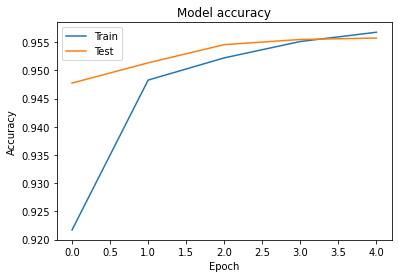

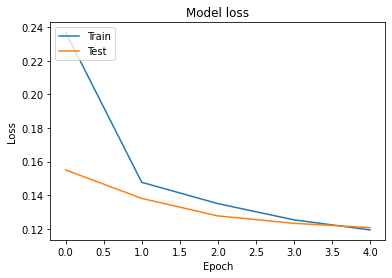

In [20]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Prediction

We can get the predictions for the validation data and check the confusion matrix to see the model's performance for each of the 5 classes. Because `tf.keras.Model.predict` method returns an n-d array for probabilities for each class, they can be converted to class labels using `np.argmax`.

In [21]:
y_pred = model.predict(validation_data)

  1/294 [..............................] - ETA: 39s

  4/294 [..............................] - ETA: 5s 

  7/294 [..............................] - ETA: 5s

 10/294 [>.............................] - ETA: 4s

 13/294 [>.............................] - ETA: 4s

 17/294 [>.............................] - ETA: 4s

 20/294 [=>............................] - ETA: 4s

 23/294 [=>............................] - ETA: 4s

 26/294 [=>............................] - ETA: 4s

 29/294 [=>............................] - ETA: 4s

 32/294 [==>...........................] - ETA: 4s

 35/294 [==>...........................] - ETA: 4s

 38/294 [==>...........................] - ETA: 4s

 41/294 [===>..........................] - ETA: 4s

 44/294 [===>..........................] - ETA: 4s

 47/294 [===>..........................] - ETA: 4s

 51/294 [====>.........................] - ETA: 4s

 54/294 [====>.........................] - ETA: 4s

 57/294 [====>.........................] - ETA: 4s

 60/294 [=====>........................] - ETA: 4s

 63/294 [=====>........................] - ETA: 4s

 66/294 [=====>........................] - ETA: 3s

 70/294 [======>.......................] - ETA: 3s

 73/294 [======>.......................] - ETA: 3s

 76/294 [======>.......................] - ETA: 3s

 79/294 [=======>......................] - ETA: 3s

 83/294 [=======>......................] - ETA: 3s

 87/294 [=======>......................] - ETA: 3s

 90/294 [========>.....................] - ETA: 3s

 93/294 [========>.....................] - ETA: 3s

 96/294 [========>.....................] - ETA: 3s

 99/294 [=========>....................] - ETA: 3s

102/294 [=========>....................] - ETA: 3s

105/294 [=========>....................] - ETA: 3s

108/294 [==========>...................] - ETA: 3s

111/294 [==========>...................] - ETA: 3s

114/294 [==========>...................] - ETA: 3s

117/294 [==========>...................] - ETA: 3s

120/294 [===========>..................] - ETA: 3s

124/294 [===========>..................] - ETA: 2s

127/294 [===========>..................] - ETA: 2s

130/294 [============>.................] - ETA: 2s

133/294 [============>.................] - ETA: 2s

136/294 [============>.................] - ETA: 2s

139/294 [=============>................] - ETA: 2s

142/294 [=============>................] - ETA: 2s

145/294 [=============>................] - ETA: 2s

148/294 [==============>...............] - ETA: 2s

151/294 [==============>...............] - ETA: 2s

154/294 [==============>...............] - ETA: 2s

157/294 [===============>..............] - ETA: 2s

160/294 [===============>..............] - ETA: 2s

163/294 [===============>..............] - ETA: 2s

166/294 [===============>..............] - ETA: 2s

169/294 [================>.............] - ETA: 2s

172/294 [================>.............] - ETA: 2s

175/294 [================>.............] - ETA: 2s

178/294 [=================>............] - ETA: 2s

181/294 [=================>............] - ETA: 1s

184/294 [=================>............] - ETA: 1s

187/294 [==================>...........] - ETA: 1s

190/294 [==================>...........] - ETA: 1s

193/294 [==================>...........] - ETA: 1s

196/294 [===================>..........] - ETA: 1s

199/294 [===================>..........] - ETA: 1s

202/294 [===================>..........] - ETA: 1s

205/294 [===================>..........] - ETA: 1s

208/294 [====================>.........] - ETA: 1s

211/294 [====================>.........] - ETA: 1s

214/294 [====================>.........] - ETA: 1s

217/294 [=====================>........] - ETA: 1s

220/294 [=====================>........] - ETA: 1s

223/294 [=====================>........] - ETA: 1s

226/294 [======================>.......] - ETA: 1s

229/294 [======================>.......] - ETA: 1s

233/294 [======================>.......] - ETA: 1s

237/294 [=======================>......] - ETA: 0s

240/294 [=======================>......] - ETA: 0s

243/294 [=======================>......] - ETA: 0s

246/294 [========================>.....] - ETA: 0s

249/294 [========================>.....] - ETA: 0s

252/294 [========================>.....] - ETA: 0s

256/294 [=========================>....] - ETA: 0s

259/294 [=========================>....] - ETA: 0s

263/294 [=========================>....] - ETA: 0s

266/294 [==========================>...] - ETA: 0s

269/294 [==========================>...] - ETA: 0s

272/294 [==========================>...] - ETA: 0s

275/294 [===========================>..] - ETA: 0s

279/294 [===========================>..] - ETA: 0s

282/294 [===========================>..] - ETA: 0s

285/294 [============================>.] - ETA: 0s

288/294 [============================>.] - ETA: 0s

291/294 [============================>.] - ETA: 0s

294/294 [==============================] - 5s 17ms/step


In [22]:
y_pred = np.argmax(y_pred, axis=1)

In [23]:
samples = file_paths[0:3]
for i, sample in enumerate(samples):
  f = open(sample)
  text = f.read()
  print(text[0:100])
  print("True Class: ", sample.split("/")[0])
  print("Predicted Class: ", dir_names[y_pred[i]])
  f.close()
  


ভারতীয় হাইকমিশনের গুলশানের ইন্দিরা গান্ধী সাংস্কৃতিক কেন্দ্রে গতকাল ছিল শিল্পী সাজেদ আকবর ও সালমা আ
True Class:  entertainment
Predicted Class:  state

ইলেকশন ওয়ার্কিং গ্রুপের (ইডব্লিউজি) পর্যবেক্ষণে বলা হয়েছে, তৃতীয় ধাপের উপজেলা পরিষদ নির্বাচনে সহিংস
True Class:  state
Predicted Class:  state

প্রথম টেনিস খেলোয়াড় হিসেবে রিও অলিম্পিকে ব্রিটেনের পতাকা বহন করেছেন অ্যান্ডি মারে। এবার কোর্টের সাফ
True Class:  sports
Predicted Class:  state


## Compare Performance

Now we can take the correct labels for the validation data from `labels` and compare them with our predictions to get a [classification_report](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html). 

In [24]:
y_true = np.array(labels[train_size:])

In [25]:
print(classification_report(y_true, y_pred, target_names=dir_names))

               precision    recall  f1-score   support

      economy       0.78      0.82      0.80      3897
       sports       0.99      0.98      0.98     10204
entertainment       0.92      0.93      0.92      6256
        state       0.97      0.97      0.97     48512
international       0.95      0.91      0.93      6377

     accuracy                           0.96     75246
    macro avg       0.92      0.92      0.92     75246
 weighted avg       0.96      0.96      0.96     75246



We can also compare our model's performance with the published results obtained in the original [paper](https://www.researchgate.net/publication/328214545_BARD_Bangla_Article_Classification_Using_a_New_Comprehensive_Dataset), which had a 0.96 precision .The original authors described many preprocessing steps performed on the dataset, such as dropping punctuations and digits, removing top 25 most frequest stop words. As we can see in the `classification_report`, we also manage to obtain a 0.96 precision and accuracy after training for only 5 epochs without any preprocessing! 

In this example, when we created the Keras layer from our embedding module, we set the parameter`trainable=False`, which means the embedding weights will not be updated during training. Try setting it to `True` to reach around 97% accuracy using this dataset after only 2 epochs. 